# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [ ]:
# code here
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
print(len(train_dataset))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False)

print(len(train_loader))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
50000
1000


torch.Size([50, 3, 32, 32])
torch.Size([50])


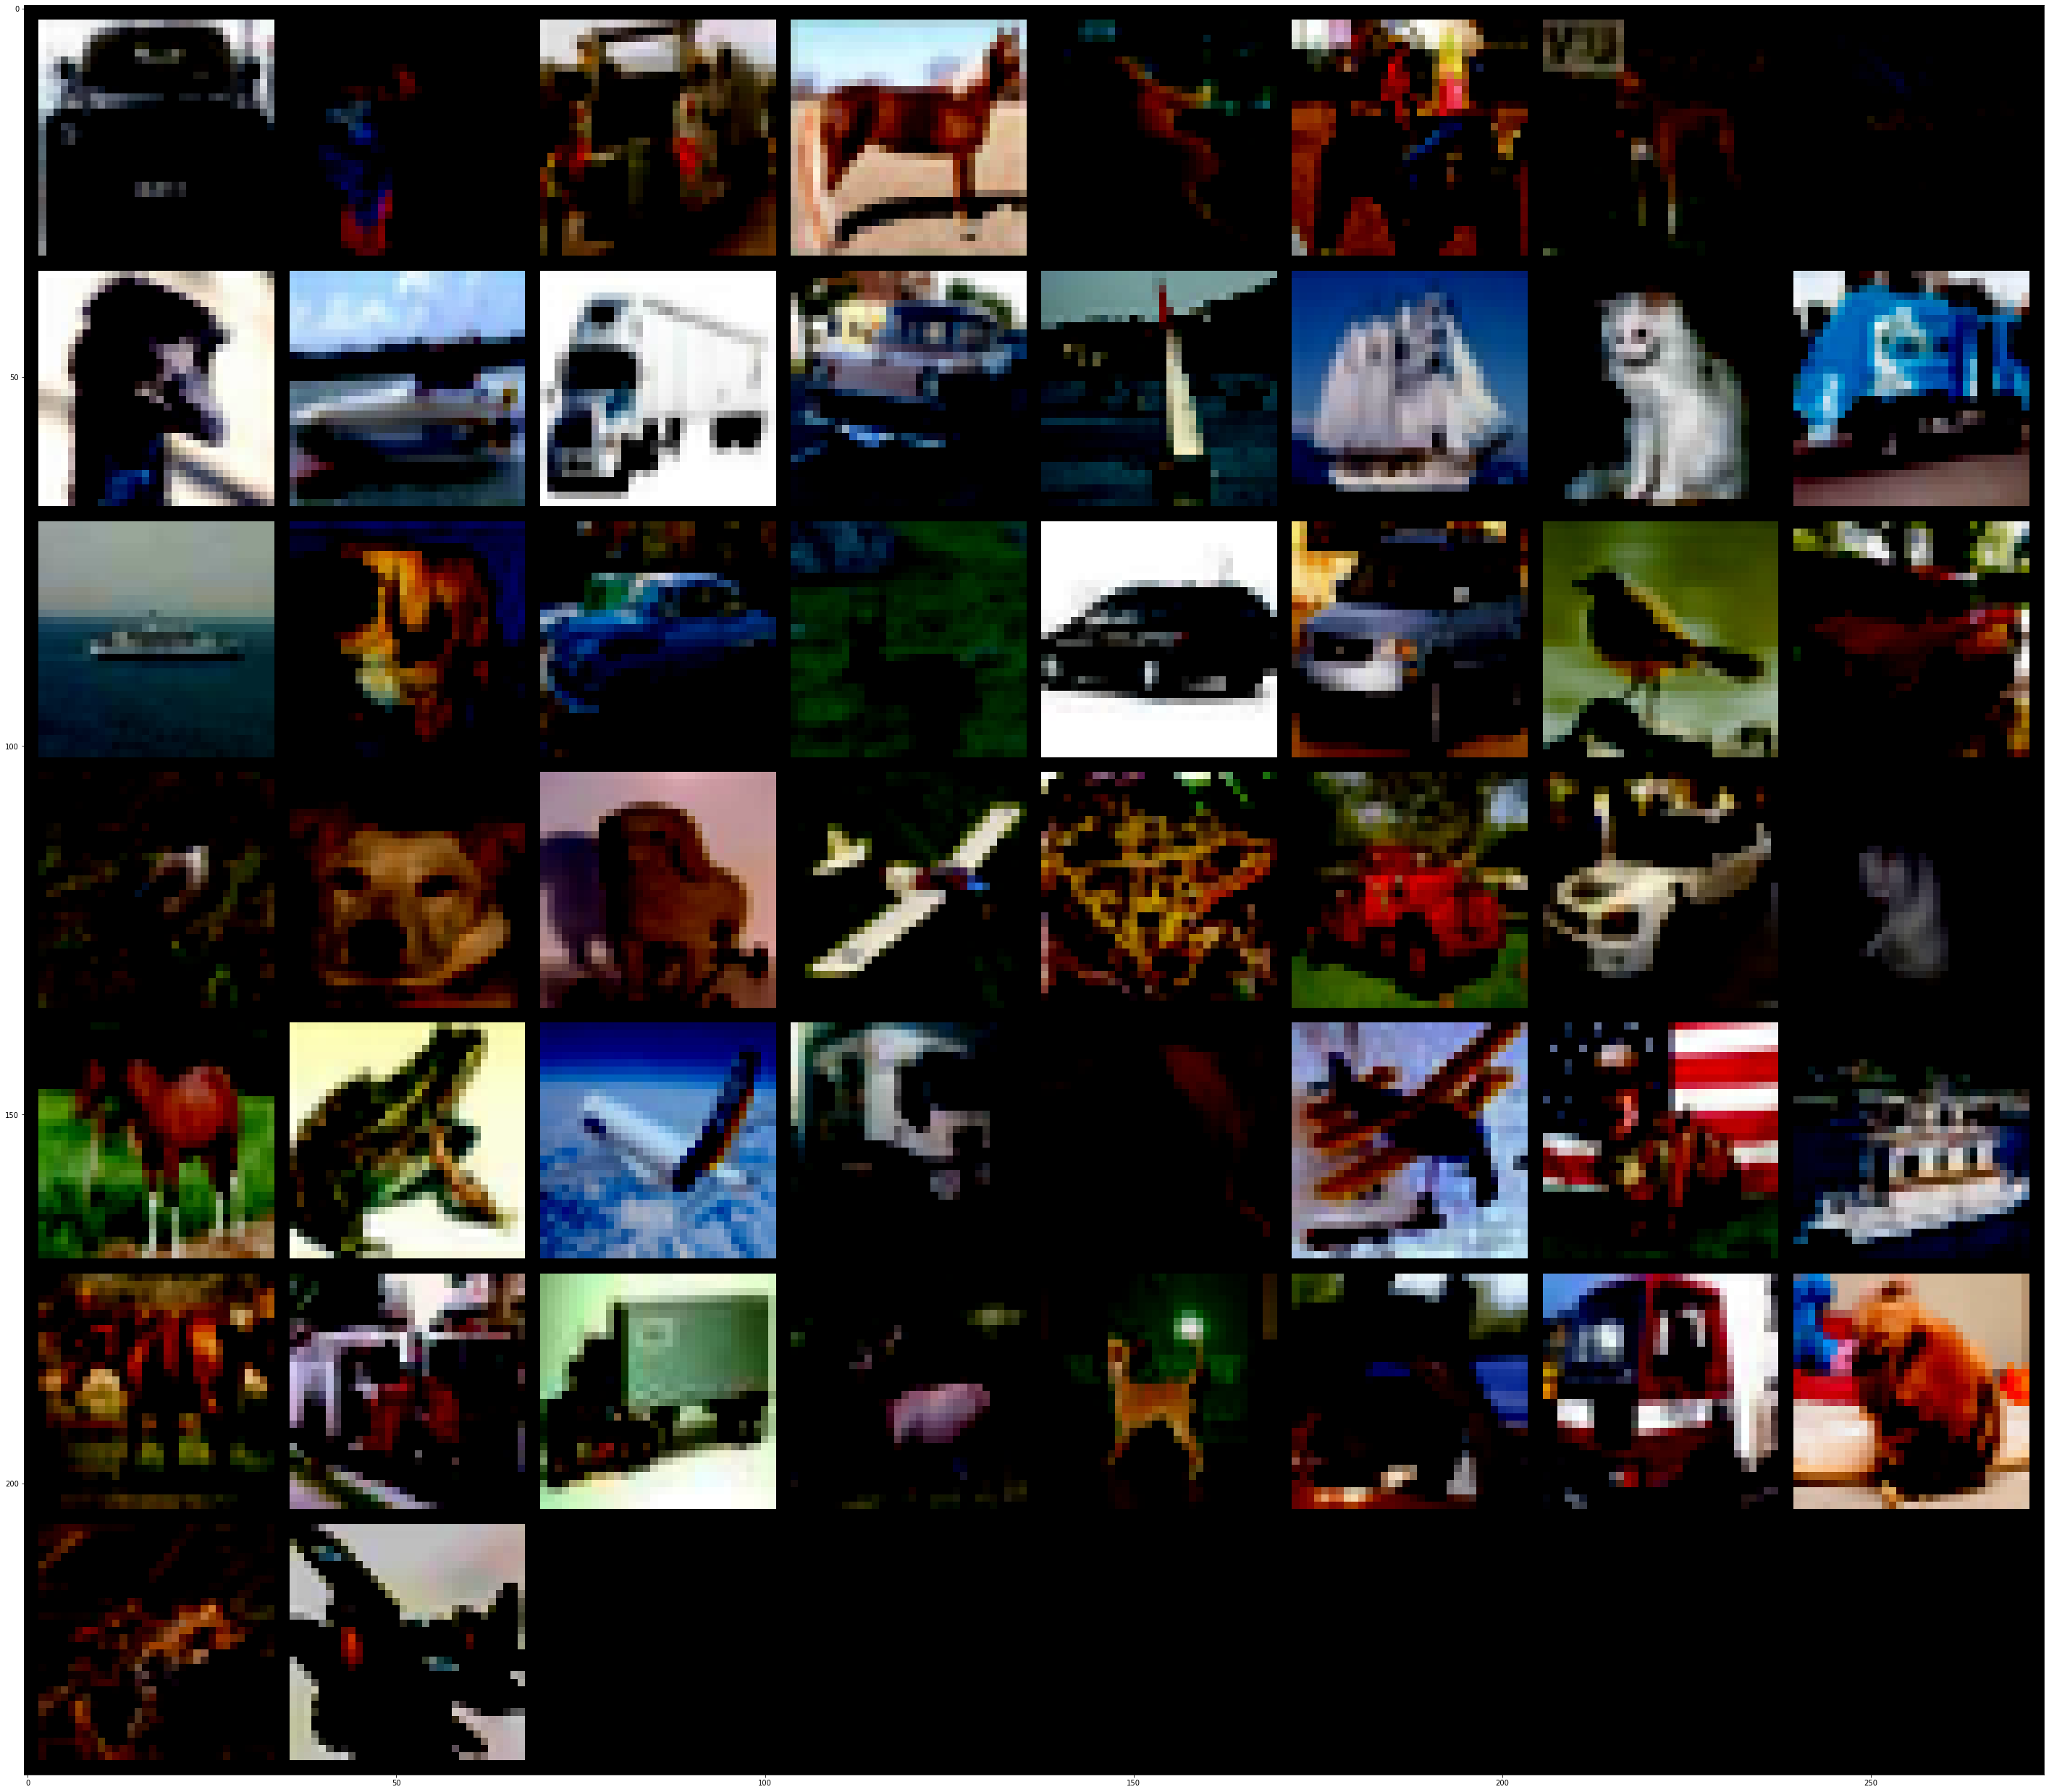

In [ ]:
def imshow(img):
    img = img 
    npimg = img.numpy()
    plt.figure(figsize=(50,50))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class MLPEncoder(nn.Module):
    def __init__(self, input_size=3072, hidden_size=256, output_size=32):
        super(MLPEncoder, self).__init__()
        self.linear_transform_encoding=  nn.ModuleList()
        self.linear_transform_dencoding=  nn.ModuleList()
        self.linear_transform_encoding.append(nn.Linear(input_size, hidden_size))
        self.linear_transform_encoding.append(nn.ReLU())
        self.linear_transform_encoding.append(nn.Linear(hidden_size, output_size))
        self.linear_transform_encoding.append(nn.ReLU())
        self.linear_transform_encoding.append(nn.Linear(output_size, output_size))
        self.linear_transform_encoding.append(nn.ReLU())

        self.linear_transform_dencoding.append(nn.Linear(output_size, output_size))
        self.linear_transform_dencoding.append(nn.ReLU())
        self.linear_transform_dencoding.append(nn.Linear(output_size, hidden_size))
        self.linear_transform_dencoding.append(nn.ReLU())
        self.linear_transform_dencoding.append(nn.Linear(hidden_size, input_size))
        self.linear_transform_dencoding.append(nn.Sigmoid())

  
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in self.linear_transform_encoding:
          x=i(x)
        #decoding
        for i in self.linear_transform_dencoding:
          x=i(x)
        return x



class ComboEncoder(nn.Module):
  def __init__(self, code_size=32):
    super(ComboEncoder, self).__init__()
    self.cnn_layers = nn.ModuleList()
    self.linear_transform=  nn.ModuleList()
    self.revcnn_layers = nn.ModuleList()

    self.cnn_layers.append(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1))
    self.cnn_layers.append(nn.ReLU())
    self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    self.cnn_layers.append(nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1))
    self.cnn_layers.append(nn.ReLU())
    self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    self.cnn_layers.append(nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1))
    self.cnn_layers.append(nn.ReLU())
    self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    self.linear_transform.append(nn.Flatten())
    self.linear_transform.append(nn.Linear(4*4*4, code_size))
    self.linear_transform.append(nn.ReLU())
    self.linear_transform.append(nn.Linear(code_size, 4*4*4))
    self.linear_transform.append(nn.ReLU())
    self.linear_transform.append(nn.Unflatten(1, (4, 4, 4)))

    self.revcnn_layers.append(nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1))
    self.revcnn_layers.append(nn.ReLU())

    self.revcnn_layers.append(nn.ConvTranspose2d( 8,16, kernel_size=3, stride=2, padding=1, output_padding=1))
    self.cnn_layers.append(nn.ReLU())

    self.revcnn_layers.append(nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1))
    self.cnn_layers.append(nn.ReLU())
     
  def forward(self, x):
      for i in self.cnn_layers:
        x=i(x)
      for i in self.linear_transform:
        x=i(x)
      for i in self.revcnn_layers:
        x=i(x)
      
      return x






class CNNencoder(nn.Module):
    def __init__(self):
        super(CNNencoder, self).__init__()

        self.cnn_layers = nn.ModuleList()
        self.linear_transform=  nn.ModuleList()
        self.revcnn_layers = nn.ModuleList()

        self.cnn_layers.append(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1))
        self.cnn_layers.append(nn.ReLU())
        self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.cnn_layers.append(nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1))
        self.cnn_layers.append(nn.ReLU())
        self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.cnn_layers.append(nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1))
        self.cnn_layers.append(nn.ReLU())
        self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        

        self.revcnn_layers.append(nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1))
        self.revcnn_layers.append(nn.ReLU())

        self.revcnn_layers.append(nn.ConvTranspose2d( 8,16, kernel_size=3, stride=2, padding=1, output_padding=1))
        self.cnn_layers.append(nn.ReLU())

        self.revcnn_layers.append(nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1))
        self.cnn_layers.append(nn.ReLU())
          
    def forward(self, x):
        for i in self.cnn_layers:
          x=i(x)
        
        for i in self.revcnn_layers:
          x=i(x)
        
        return x


In [ ]:
# sample code for a autoencoder:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: 3072
        # Number of Layers for encoder: 1
        # Number of Layers for decoder: 1
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Flatten(), # 12x16x16 -> 3072
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (12, 16, 16)), # 3072 -> 12x16x16
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    losses = 0
  
    for (images, label) in (train_loader):
       
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        imagesx= images.reshape(images.shape[0], -1)
        outputsx= outputs.reshape(outputs.shape[0], -1)
        
        loss = criterion(outputsx, imagesx)
        loss.backward()
        optimizer.step()
        losses += loss.item()

    return losses / len(train_loader)

### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [ ]:
# code here

import time



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mlp_model = MLPEncoder().to(device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

mlpLosses = []
start_time = time.time()
res=[]


for epoch in range(5):
    print(epoch)
    losses = train(mlp_model, train_loader, optimizer, criterion, device)
    mlpLosses.append(losses)
    if epoch==4:
      res.append({'model': 'mlp_model', 
                        'epoch': epoch+1, 
                        'loss': losses, 
                        'size': sum(p.numel() for p in mlp_model.parameters()),
                        'params': sum(p.numel() for p in mlp_model.parameters() if p.requires_grad),
                        'time': time.time() - start_time})

    print(f"Epoch {epoch+1}: Train Loss: {losses:.4f}")
    


cnnMlpModel = ComboEncoder().to(device)
optimizer = torch.optim.Adam(cnnMlpModel.parameters(), lr=0.001)
criterion = nn.MSELoss()

cnnMlpLosses = []
start_time = time.time()
for epoch in range(5):
    losses = train(cnnMlpModel, train_loader, optimizer, criterion, device)
    cnnMlpLosses.append(losses)
    if epoch==4:
      res.append({'model': 'cnn_mlp_model', 
                        'epoch': epoch+1, 
                        'loss': losses, 
                        'size': sum(p.numel() for p in cnnMlpModel.parameters()),
                        'params': sum(p.numel() for p in cnnMlpModel.parameters() if p.requires_grad),
                        'time': time.time() - start_time})
    print(f"Epoch {epoch+1}: Train Loss: {losses:.4f}")


cnnModel = CNNencoder().to(device)
optimizer = torch.optim.Adam(cnnModel.parameters(), lr=0.001)
criterion = nn.MSELoss()

cnn_losses = []
start_time = time.time()
for epoch in range(5):
    losses = train(cnnModel, train_loader, optimizer, criterion, device)
    cnn_losses.append(losses)
    if epoch==4:
      res.append({'model': 'cnn_model', 
                        'epoch': epoch+1, 
                        'loss': losses, 
                        'size': sum(p.numel() for p in cnnModel.parameters()),
                        'params': sum(p.numel() for p in cnnModel.parameters() if p.requires_grad),
                        'time': time.time() - start_time})
    print(f"Epoch {epoch+1}: Train Loss: {losses:.4f}")
    






cuda
0
Epoch 1: Train Loss: 0.1983
1
Epoch 2: Train Loss: 0.1785
2
Epoch 3: Train Loss: 0.1749
3
Epoch 4: Train Loss: 0.1733
4
Epoch 5: Train Loss: 0.1719
Epoch 1: Train Loss: 0.1211
Epoch 2: Train Loss: 0.0929
Epoch 3: Train Loss: 0.0886
Epoch 4: Train Loss: 0.0859
Epoch 5: Train Loss: 0.0842
Epoch 1: Train Loss: 0.0892
Epoch 2: Train Loss: 0.0619
Epoch 3: Train Loss: 0.0570
Epoch 4: Train Loss: 0.0554
Epoch 5: Train Loss: 0.0546


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


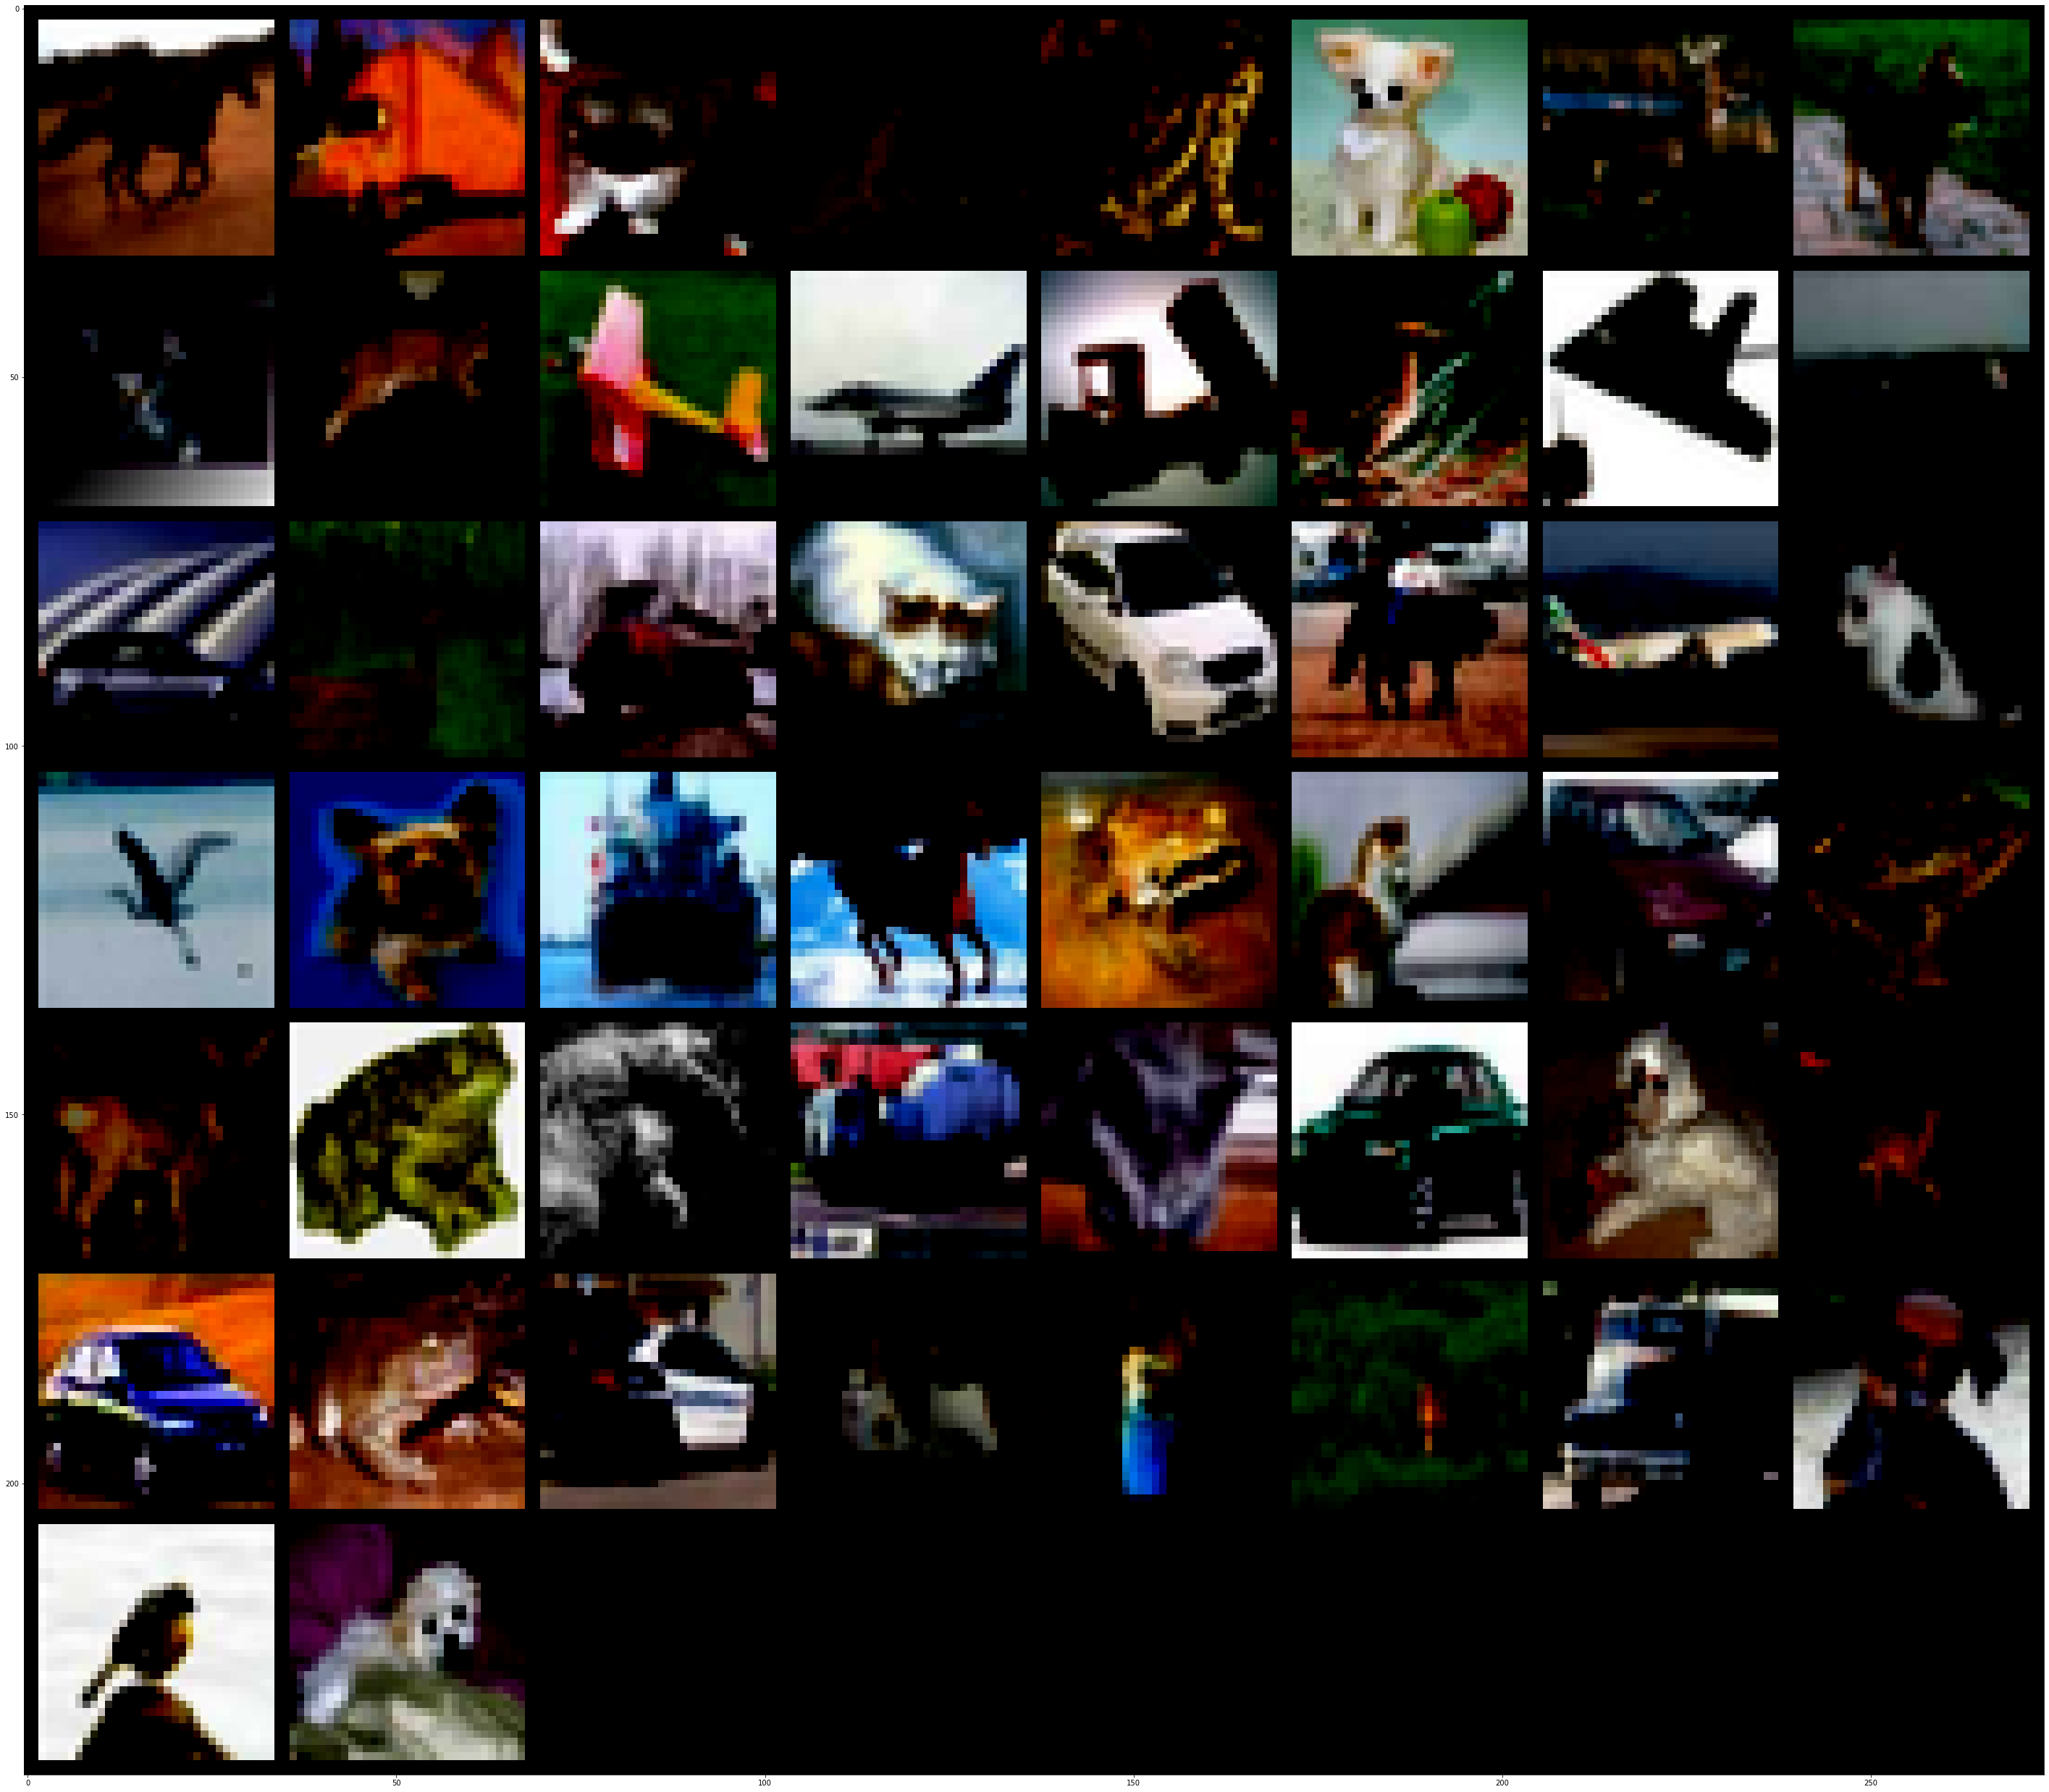

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


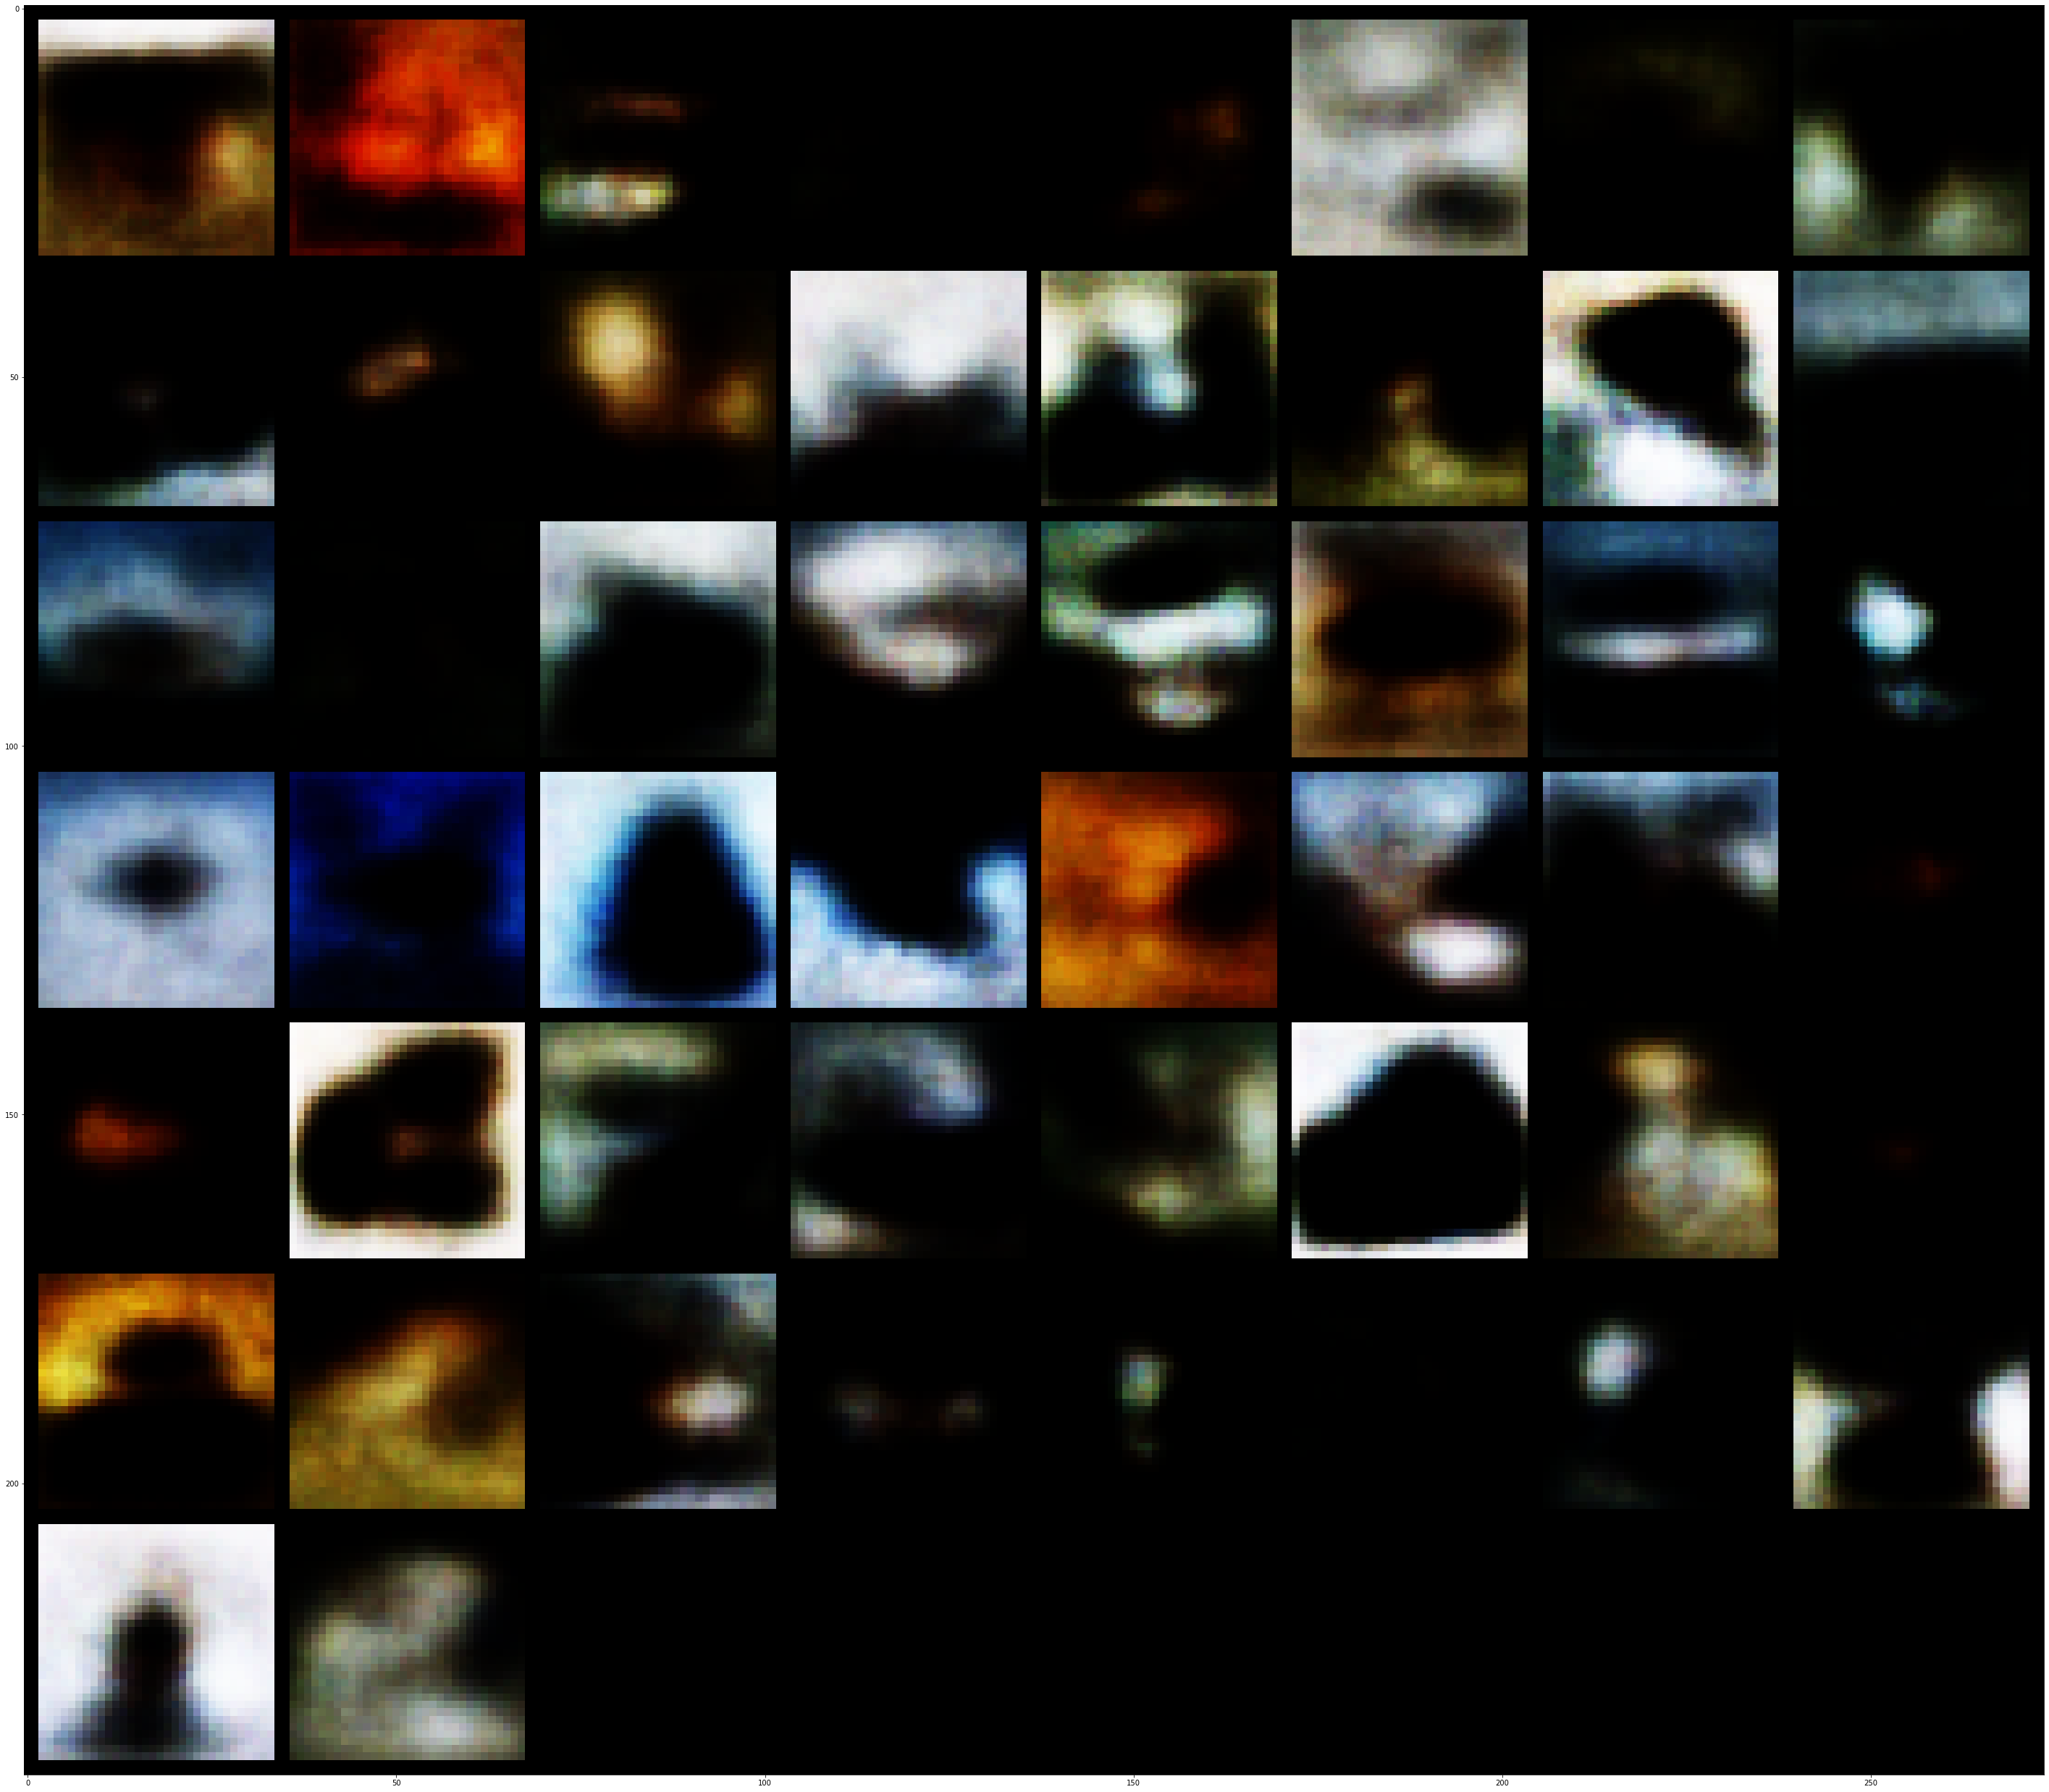

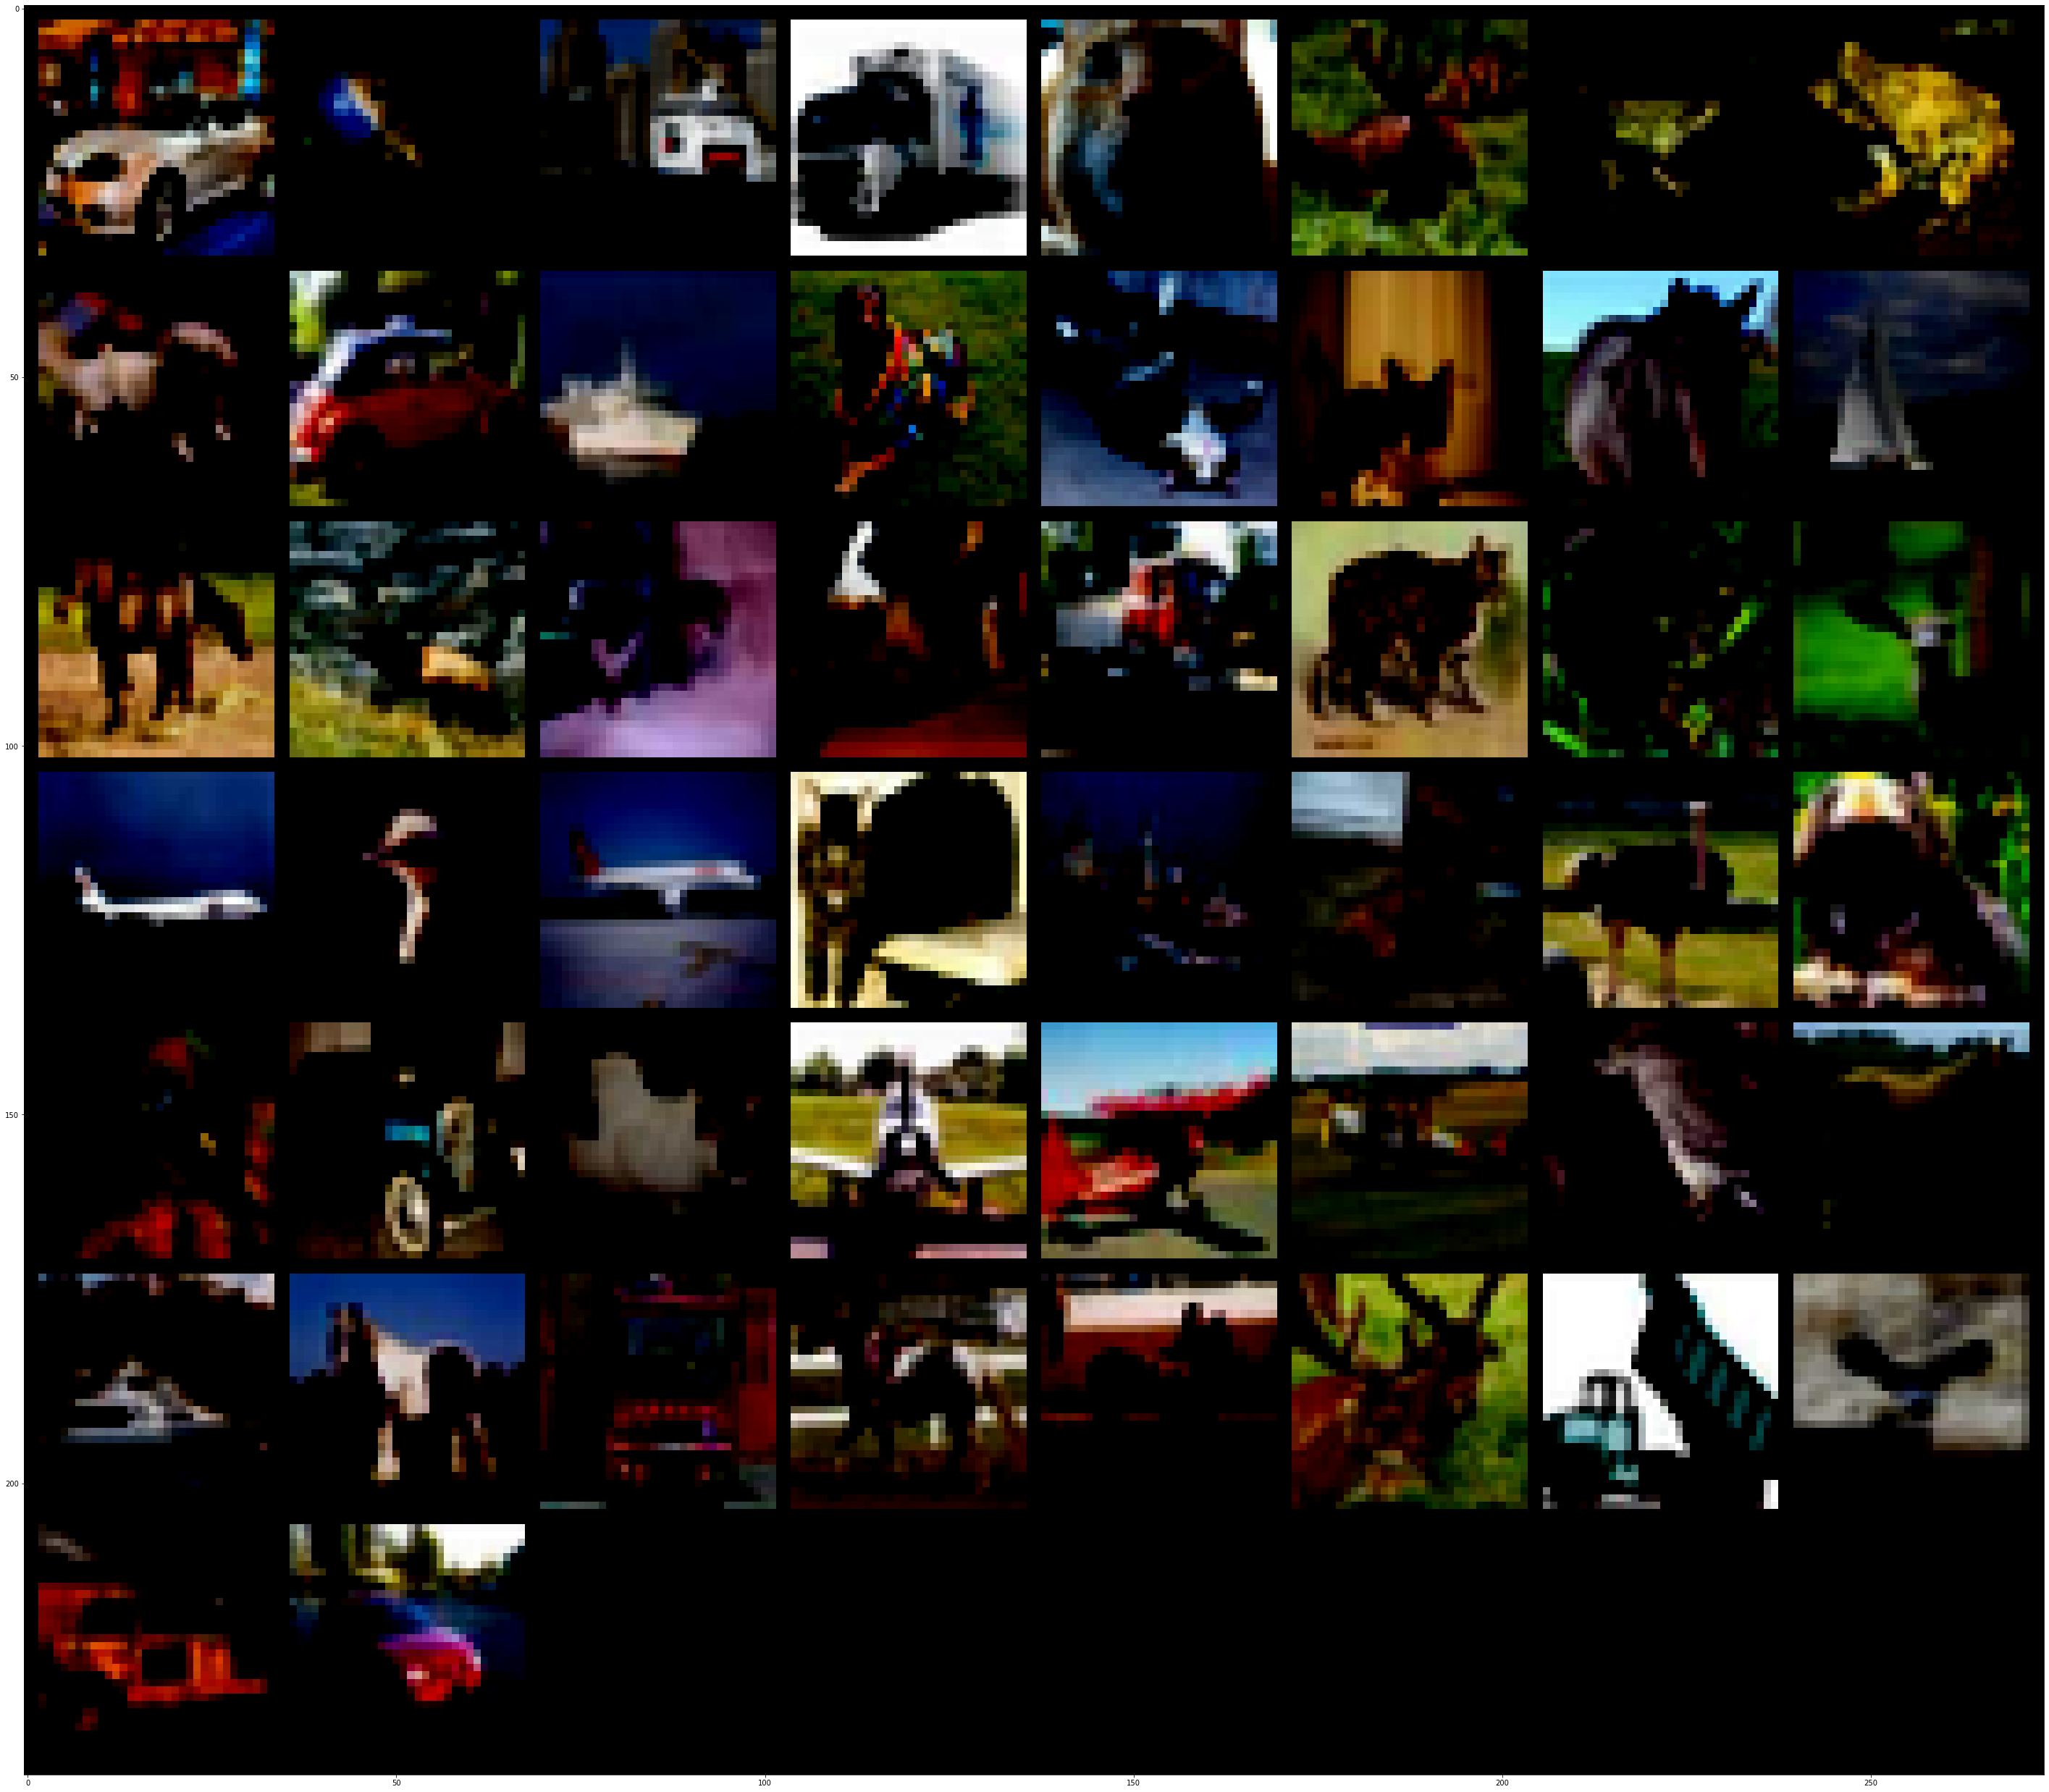

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


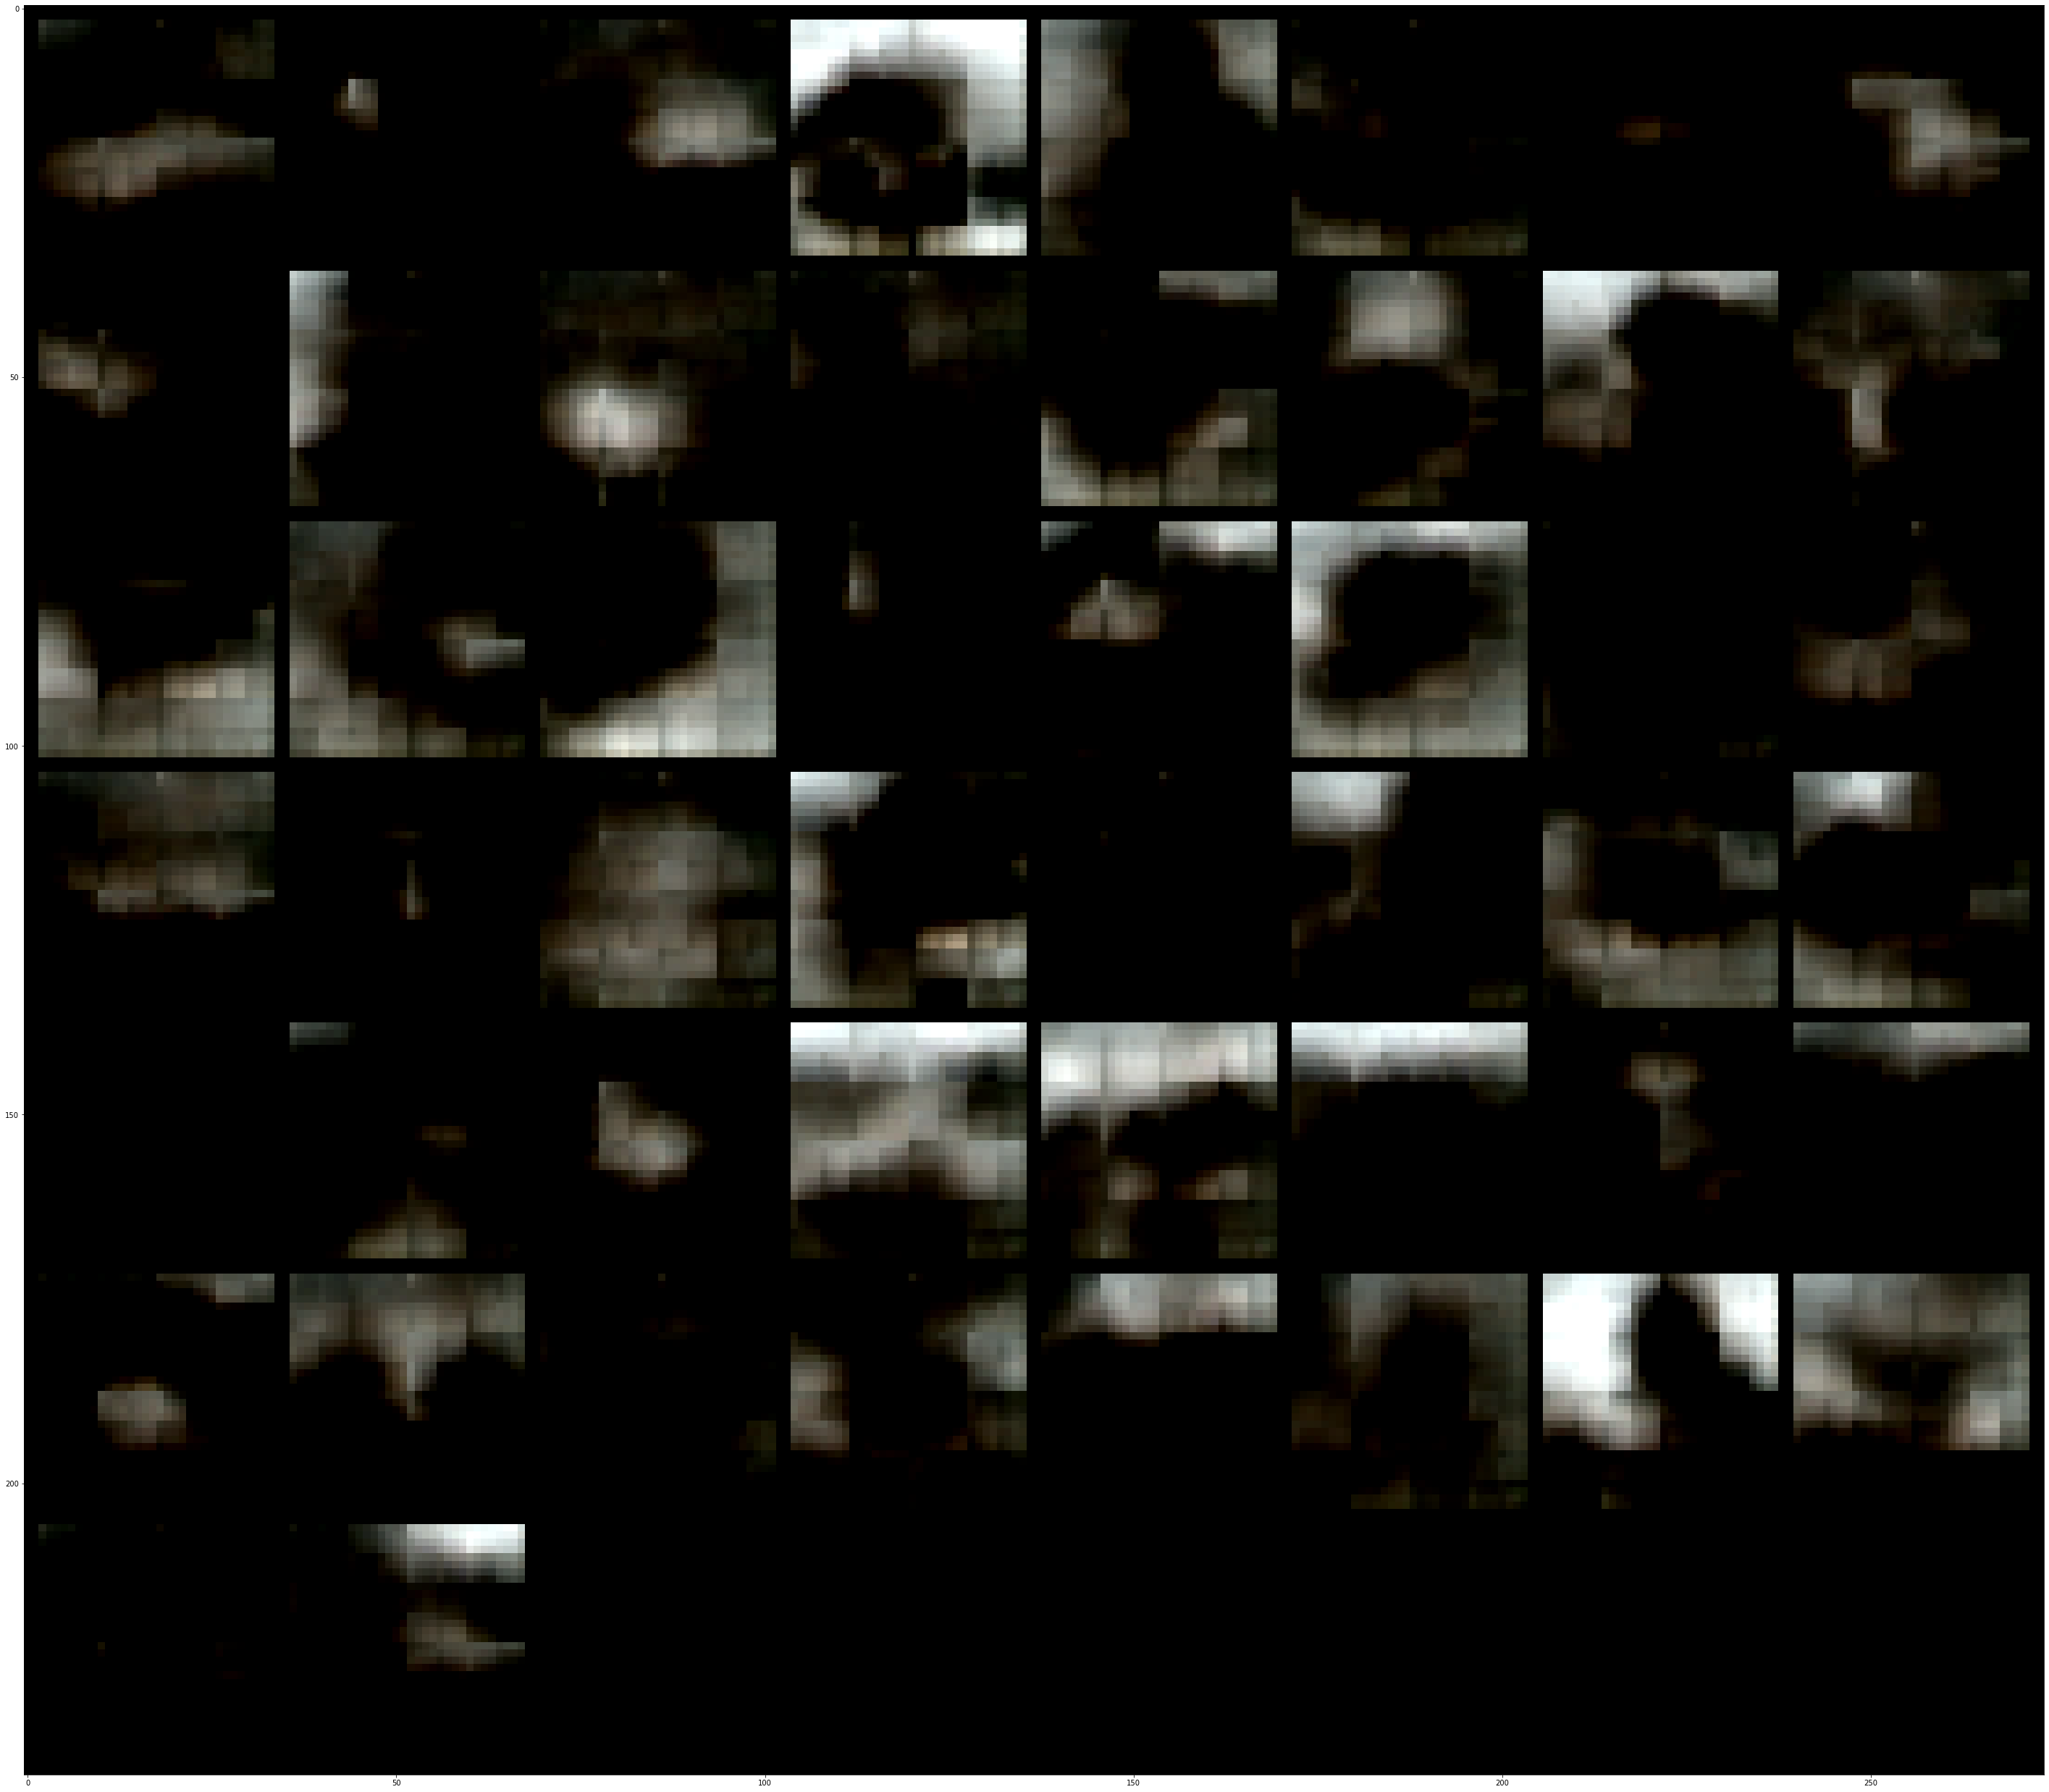

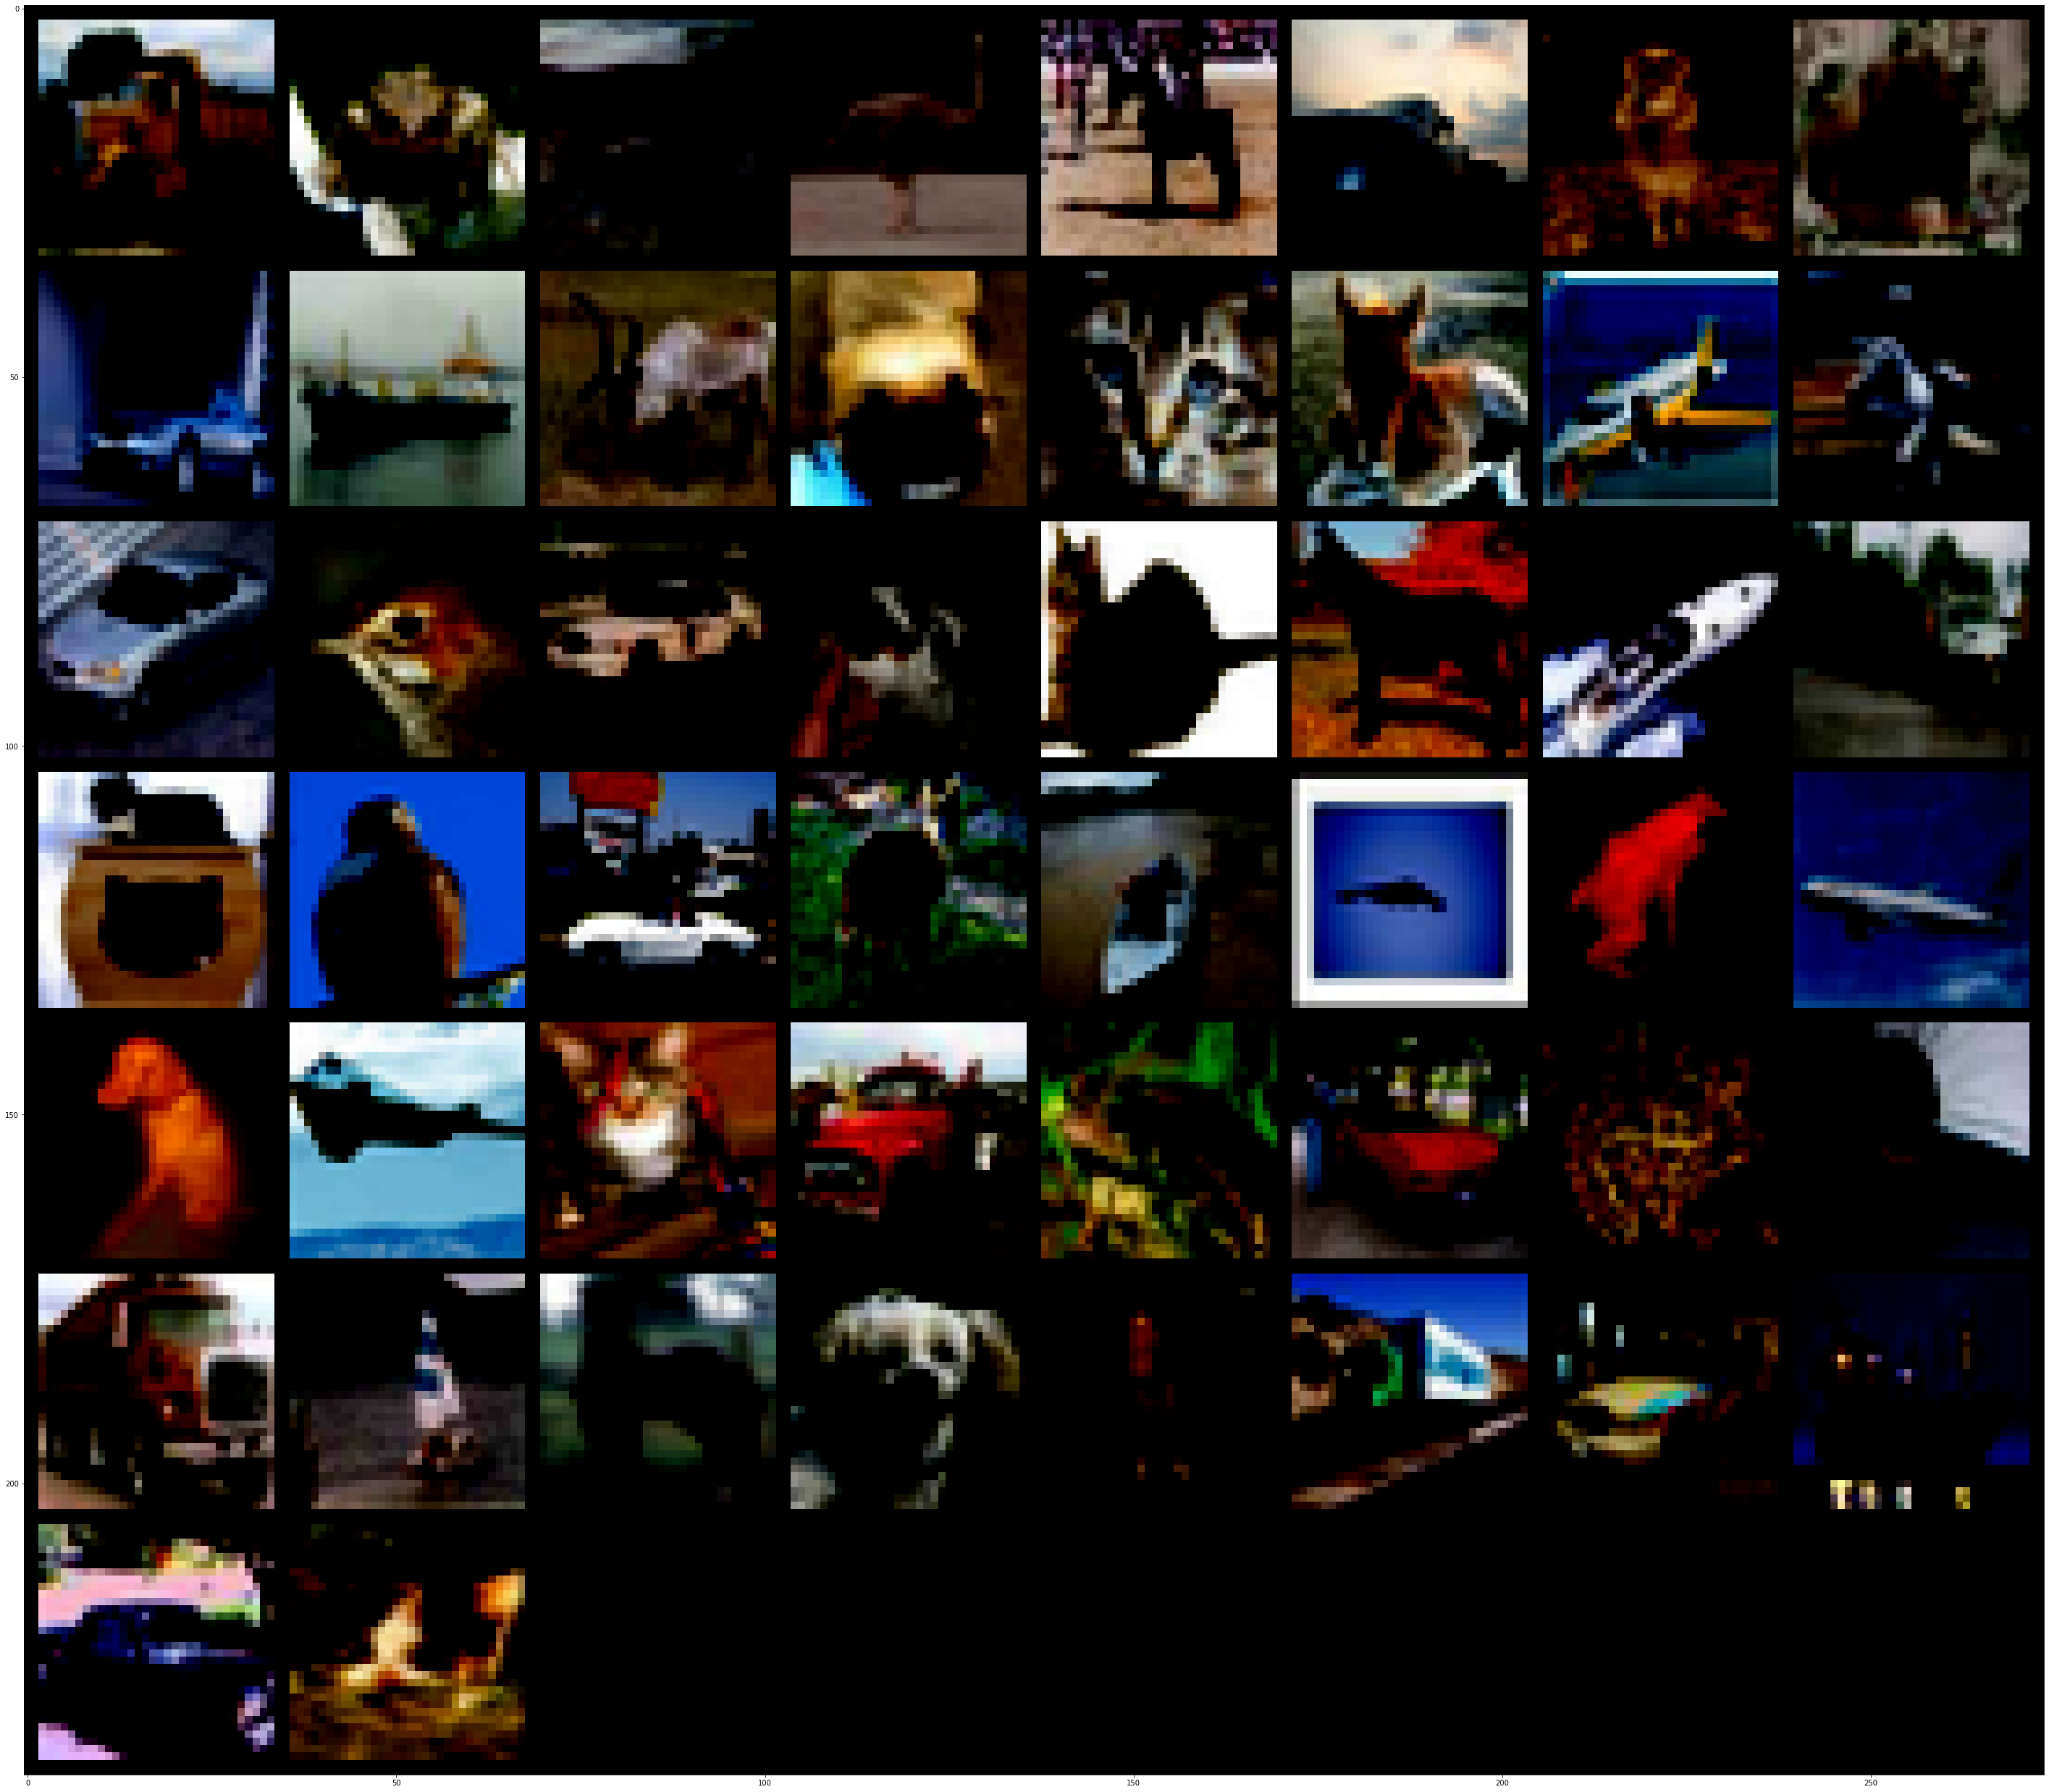

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


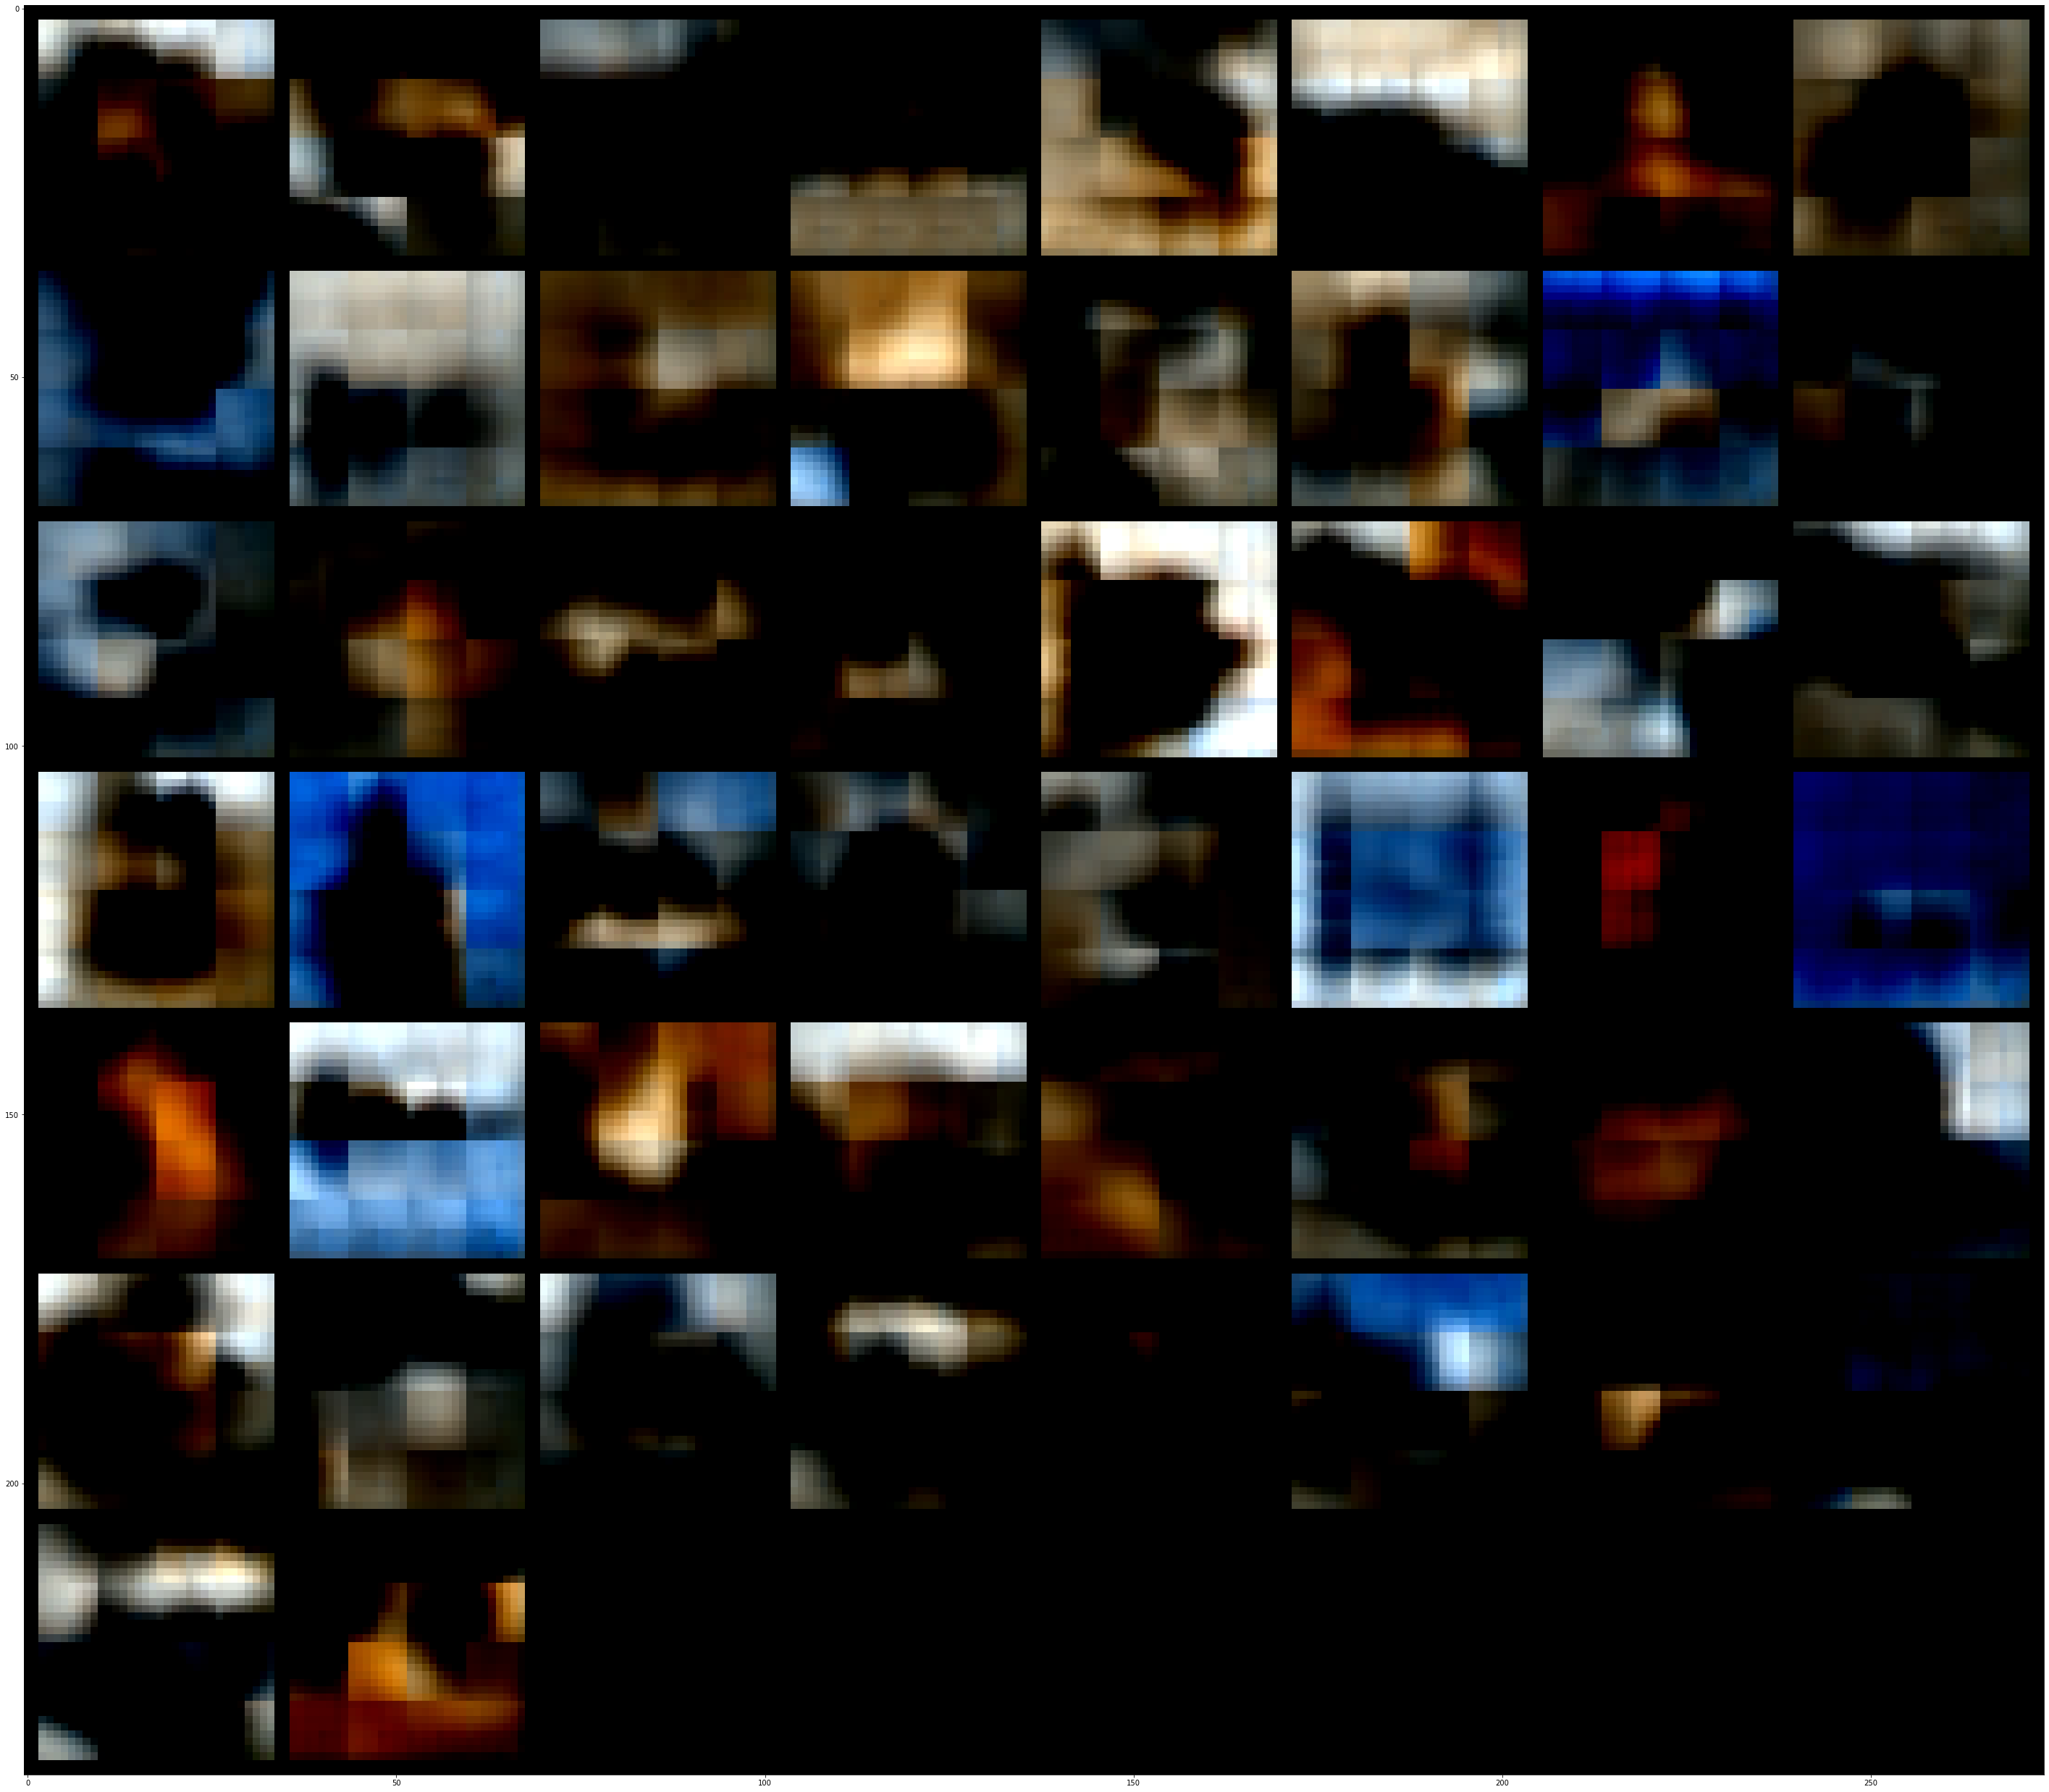

In [ ]:
# Utilize the following code
#--------------MLP--------------#
import torch
import torch.autograd as autograd
import time

print(testset )
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = autograd.Variable(images)

print("Reconstructed image")
print(images.shape)
images = images.cuda()
decoded_imgs = mlp_model.forward(images)
decoded_imgs=decoded_imgs.view(-1, 3, 32, 32)
print(decoded_imgs.shape)
decoded_imgs = decoded_imgs.to('cpu')

imshow(torchvision.utils.make_grid(decoded_imgs))


#
#--------------Combo--------------#
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = autograd.Variable(images)

print("Reconstructed image")
print(images.shape)
images = images.cuda()
decoded_imgs = cnnMlpModel.forward(images)
decoded_imgs=decoded_imgs.view(-1, 3, 32, 32)
print(decoded_imgs.shape)
decoded_imgs = decoded_imgs.to('cpu')

imshow(torchvision.utils.make_grid(decoded_imgs))
#--------------CNN--------------#

dataiter = iter(train_loader)
images, labels = next(dataiter)
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = autograd.Variable(images)

print("Reconstructed image")
print(images.shape)
images = images.cuda()
decoded_imgs =  cnnModel.forward(images)
decoded_imgs=decoded_imgs.view(-1, 3, 32, 32)
print(decoded_imgs.shape)
decoded_imgs = decoded_imgs.to('cpu')

imshow(torchvision.utils.make_grid(decoded_imgs))

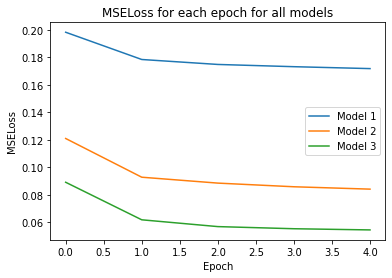

           model  epoch      loss     size   params       time
0      mlp_model      5  0.171869  1594976  1594976  85.838521
1  cnn_mlp_model      5  0.084226     7991     7991  91.392406
2      cnn_model      5  0.054573     3799     3799  82.117103


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax = plt.subplots()

ax.plot(mlpLosses, label='Model 1')
ax.plot(cnnMlpLosses, label='Model 2')
ax.plot(cnn_losses, label='Model 3')

ax.set_title('MSELoss for each epoch for all models')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSELoss')

ax.legend()

plt.show()





# convert results to a dataframe
df = pd.DataFrame(res)
print(df)



### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

Epoch 1: Train Loss: 0.0947
Epoch 2: Train Loss: 0.0651
Epoch 3: Train Loss: 0.0529
Epoch 4: Train Loss: 0.0497


Epoch 5: Train Loss: 0.0479


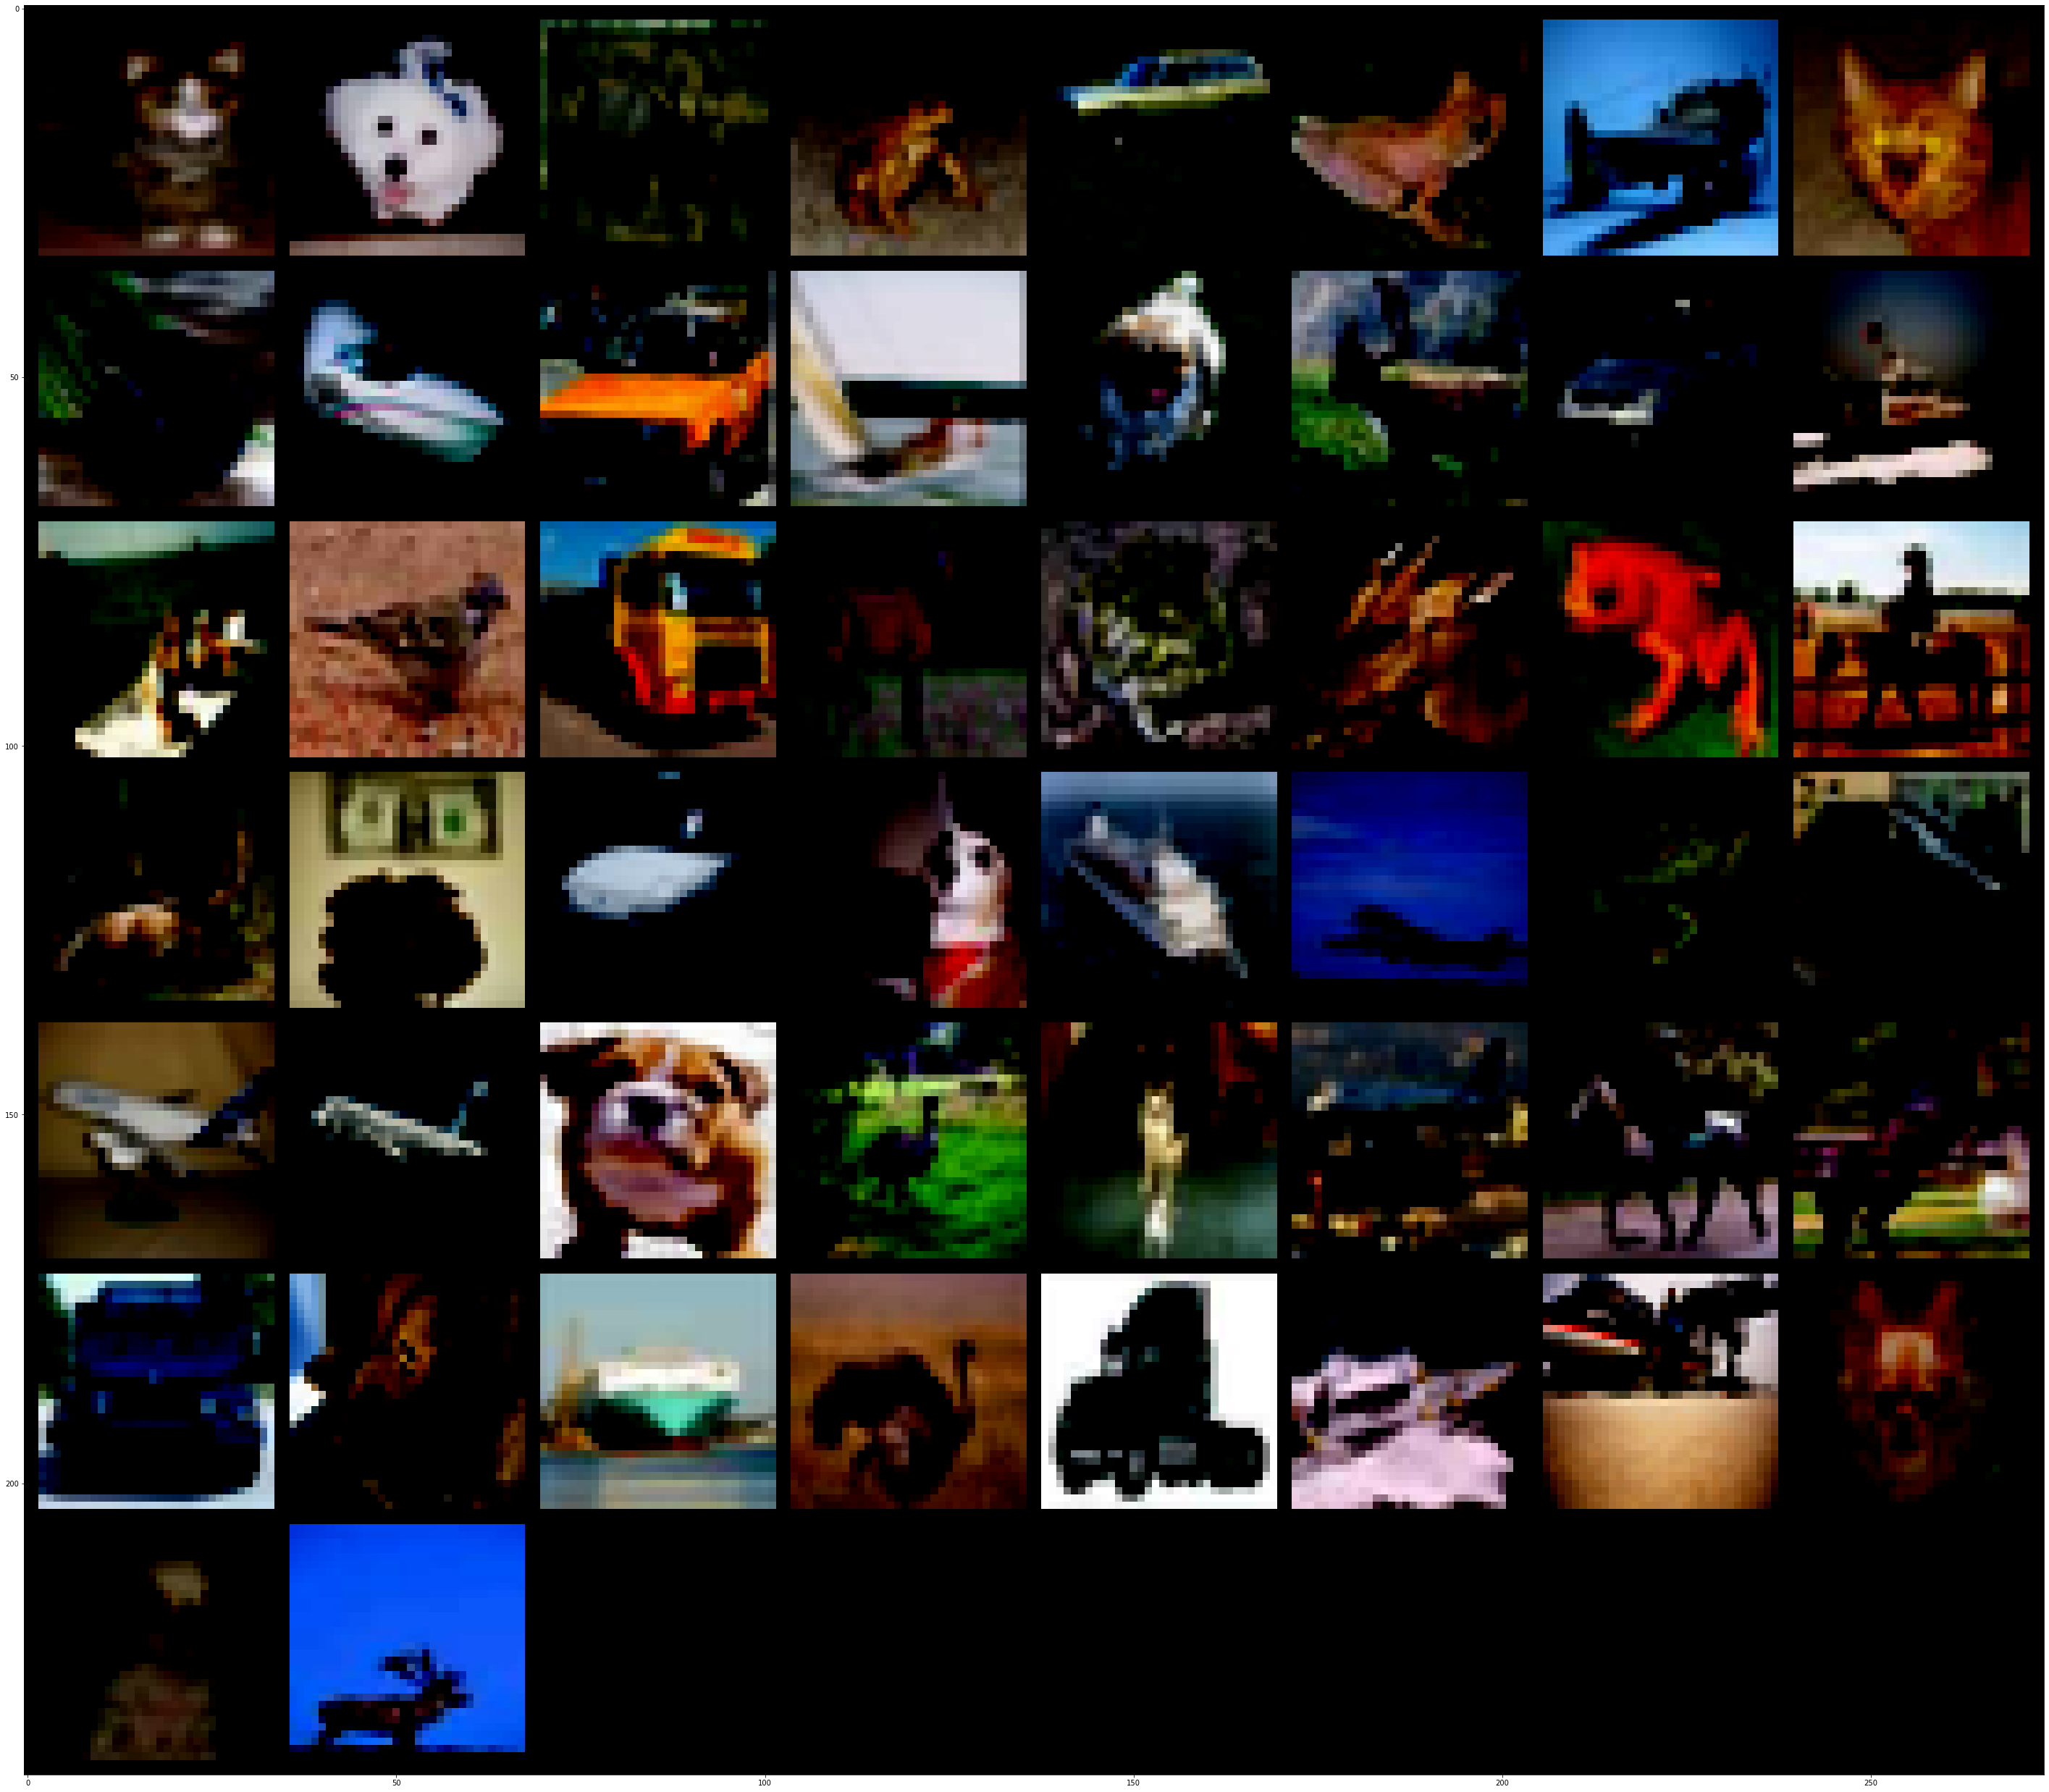

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


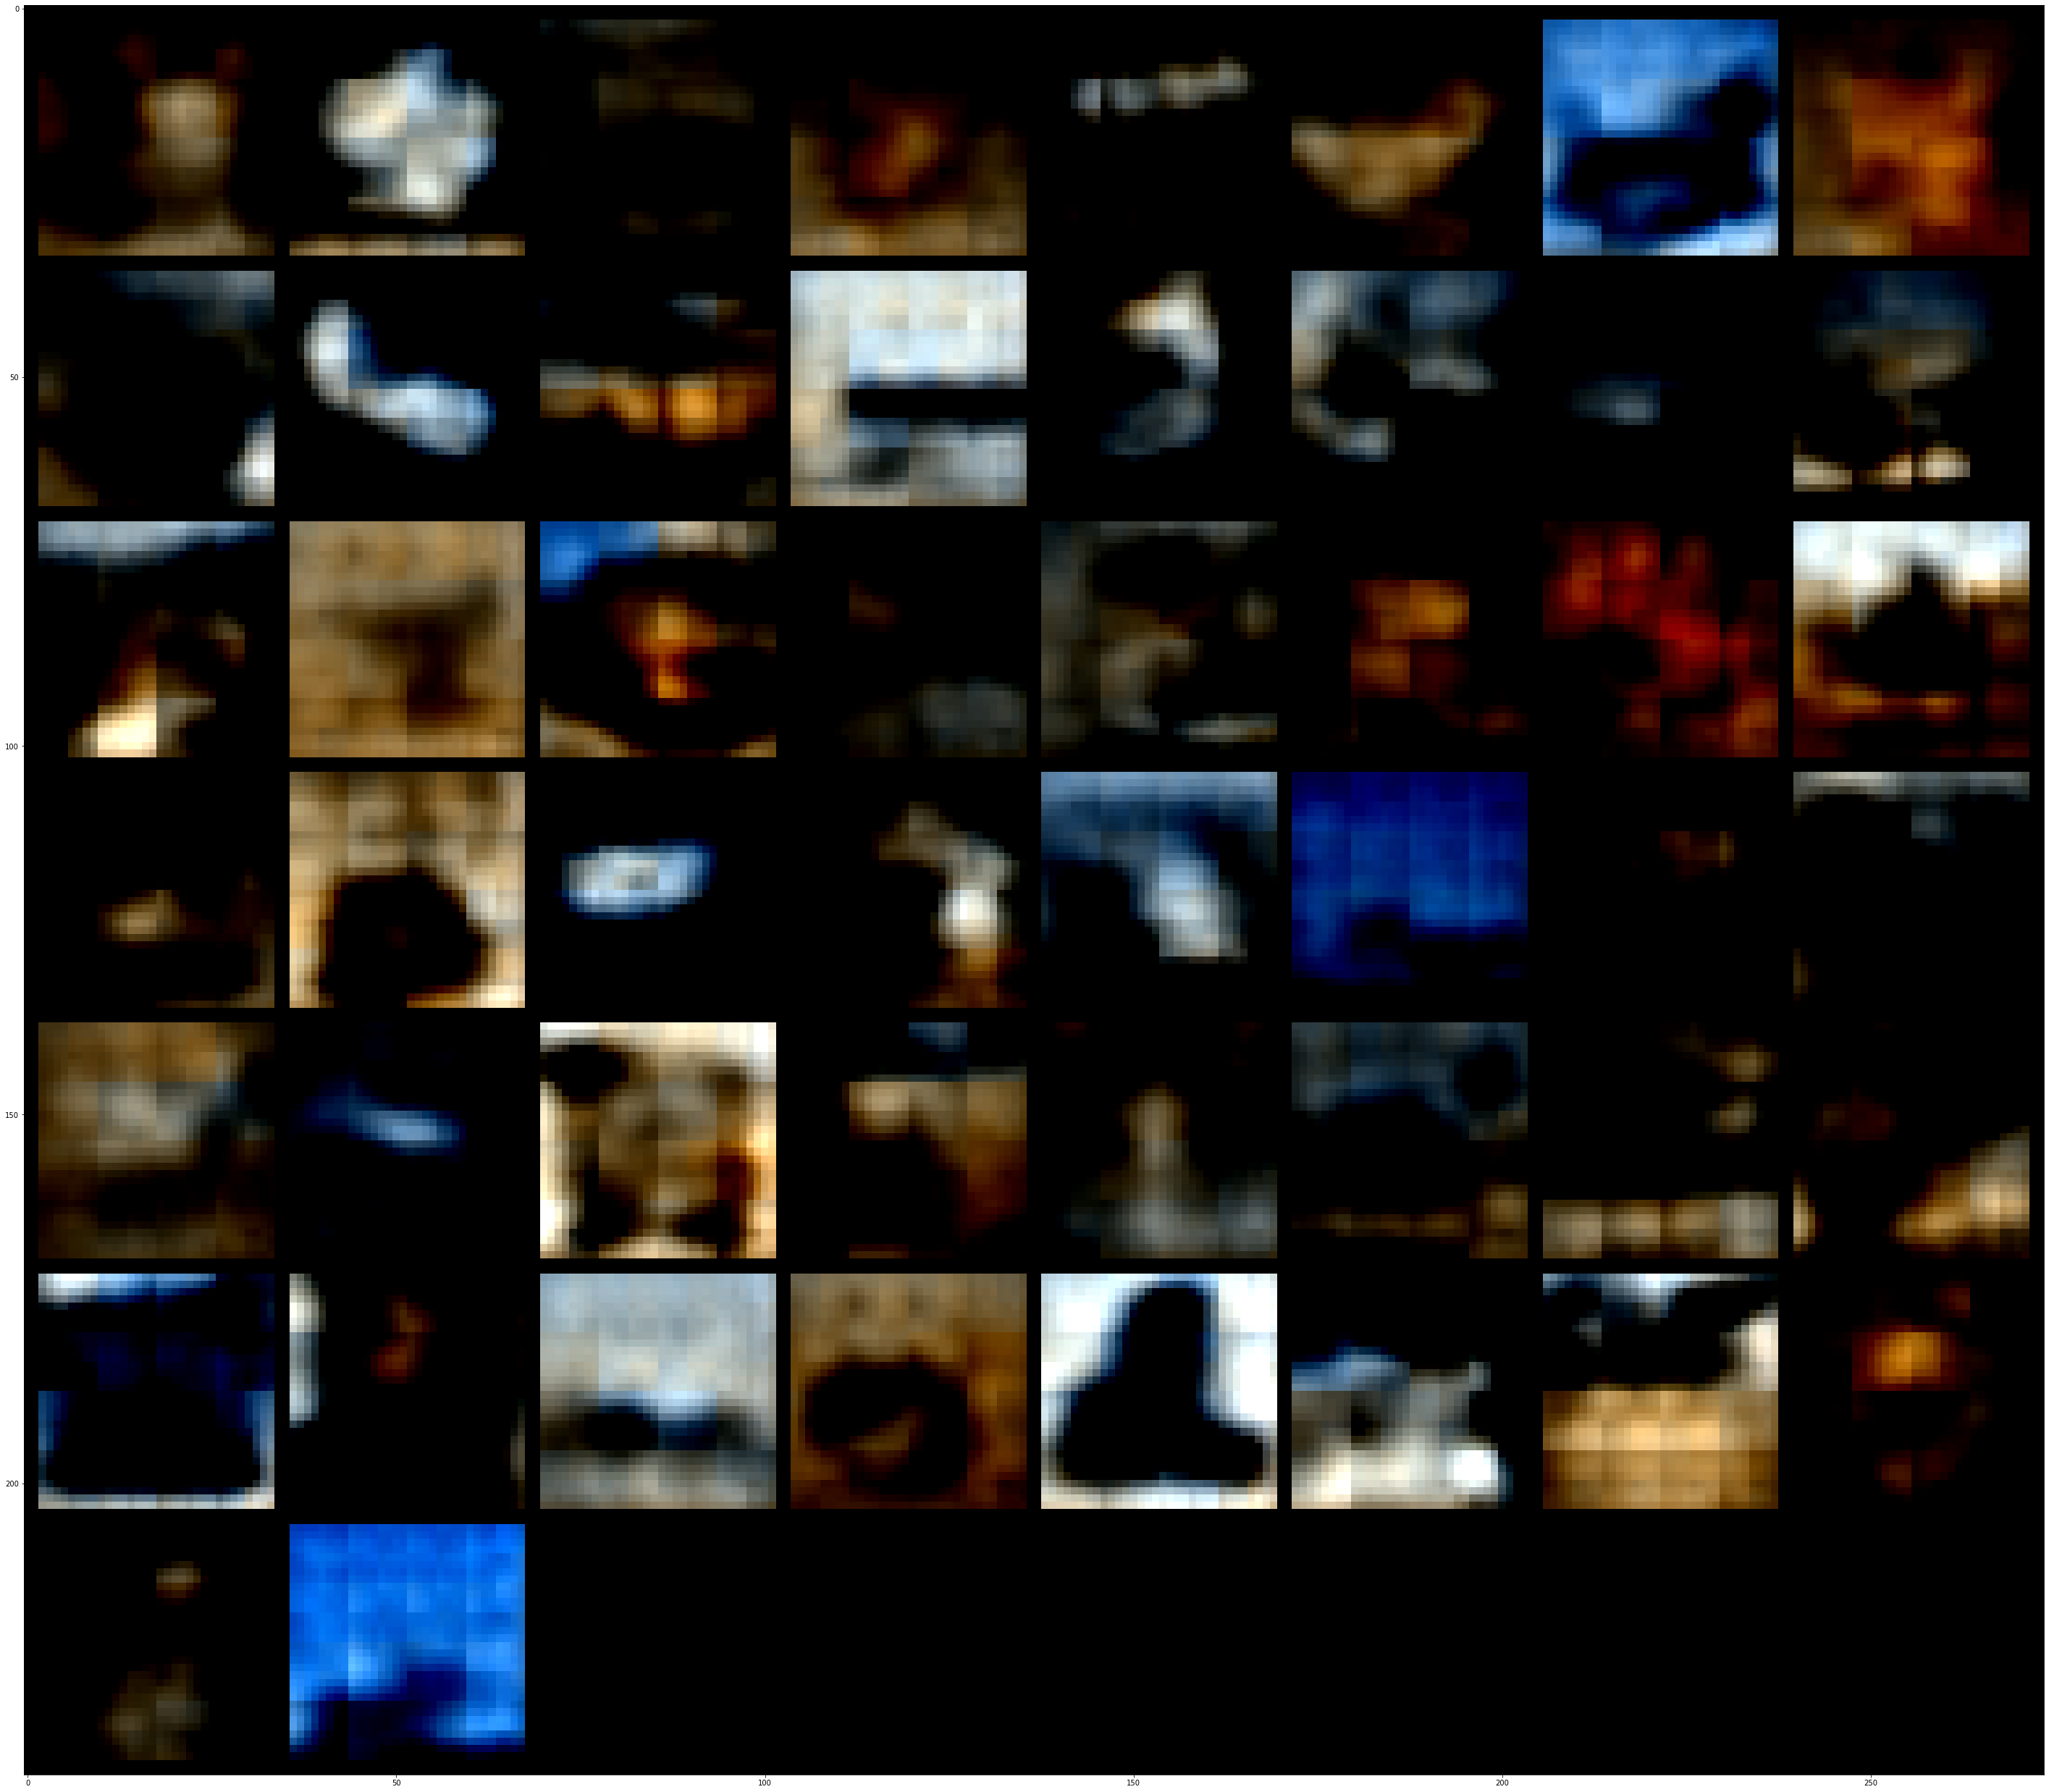

Epoch 1: Train Loss: 0.0852
Epoch 2: Train Loss: 0.0464
Epoch 3: Train Loss: 0.0419
Epoch 4: Train Loss: 0.0400


Epoch 5: Train Loss: 0.0390


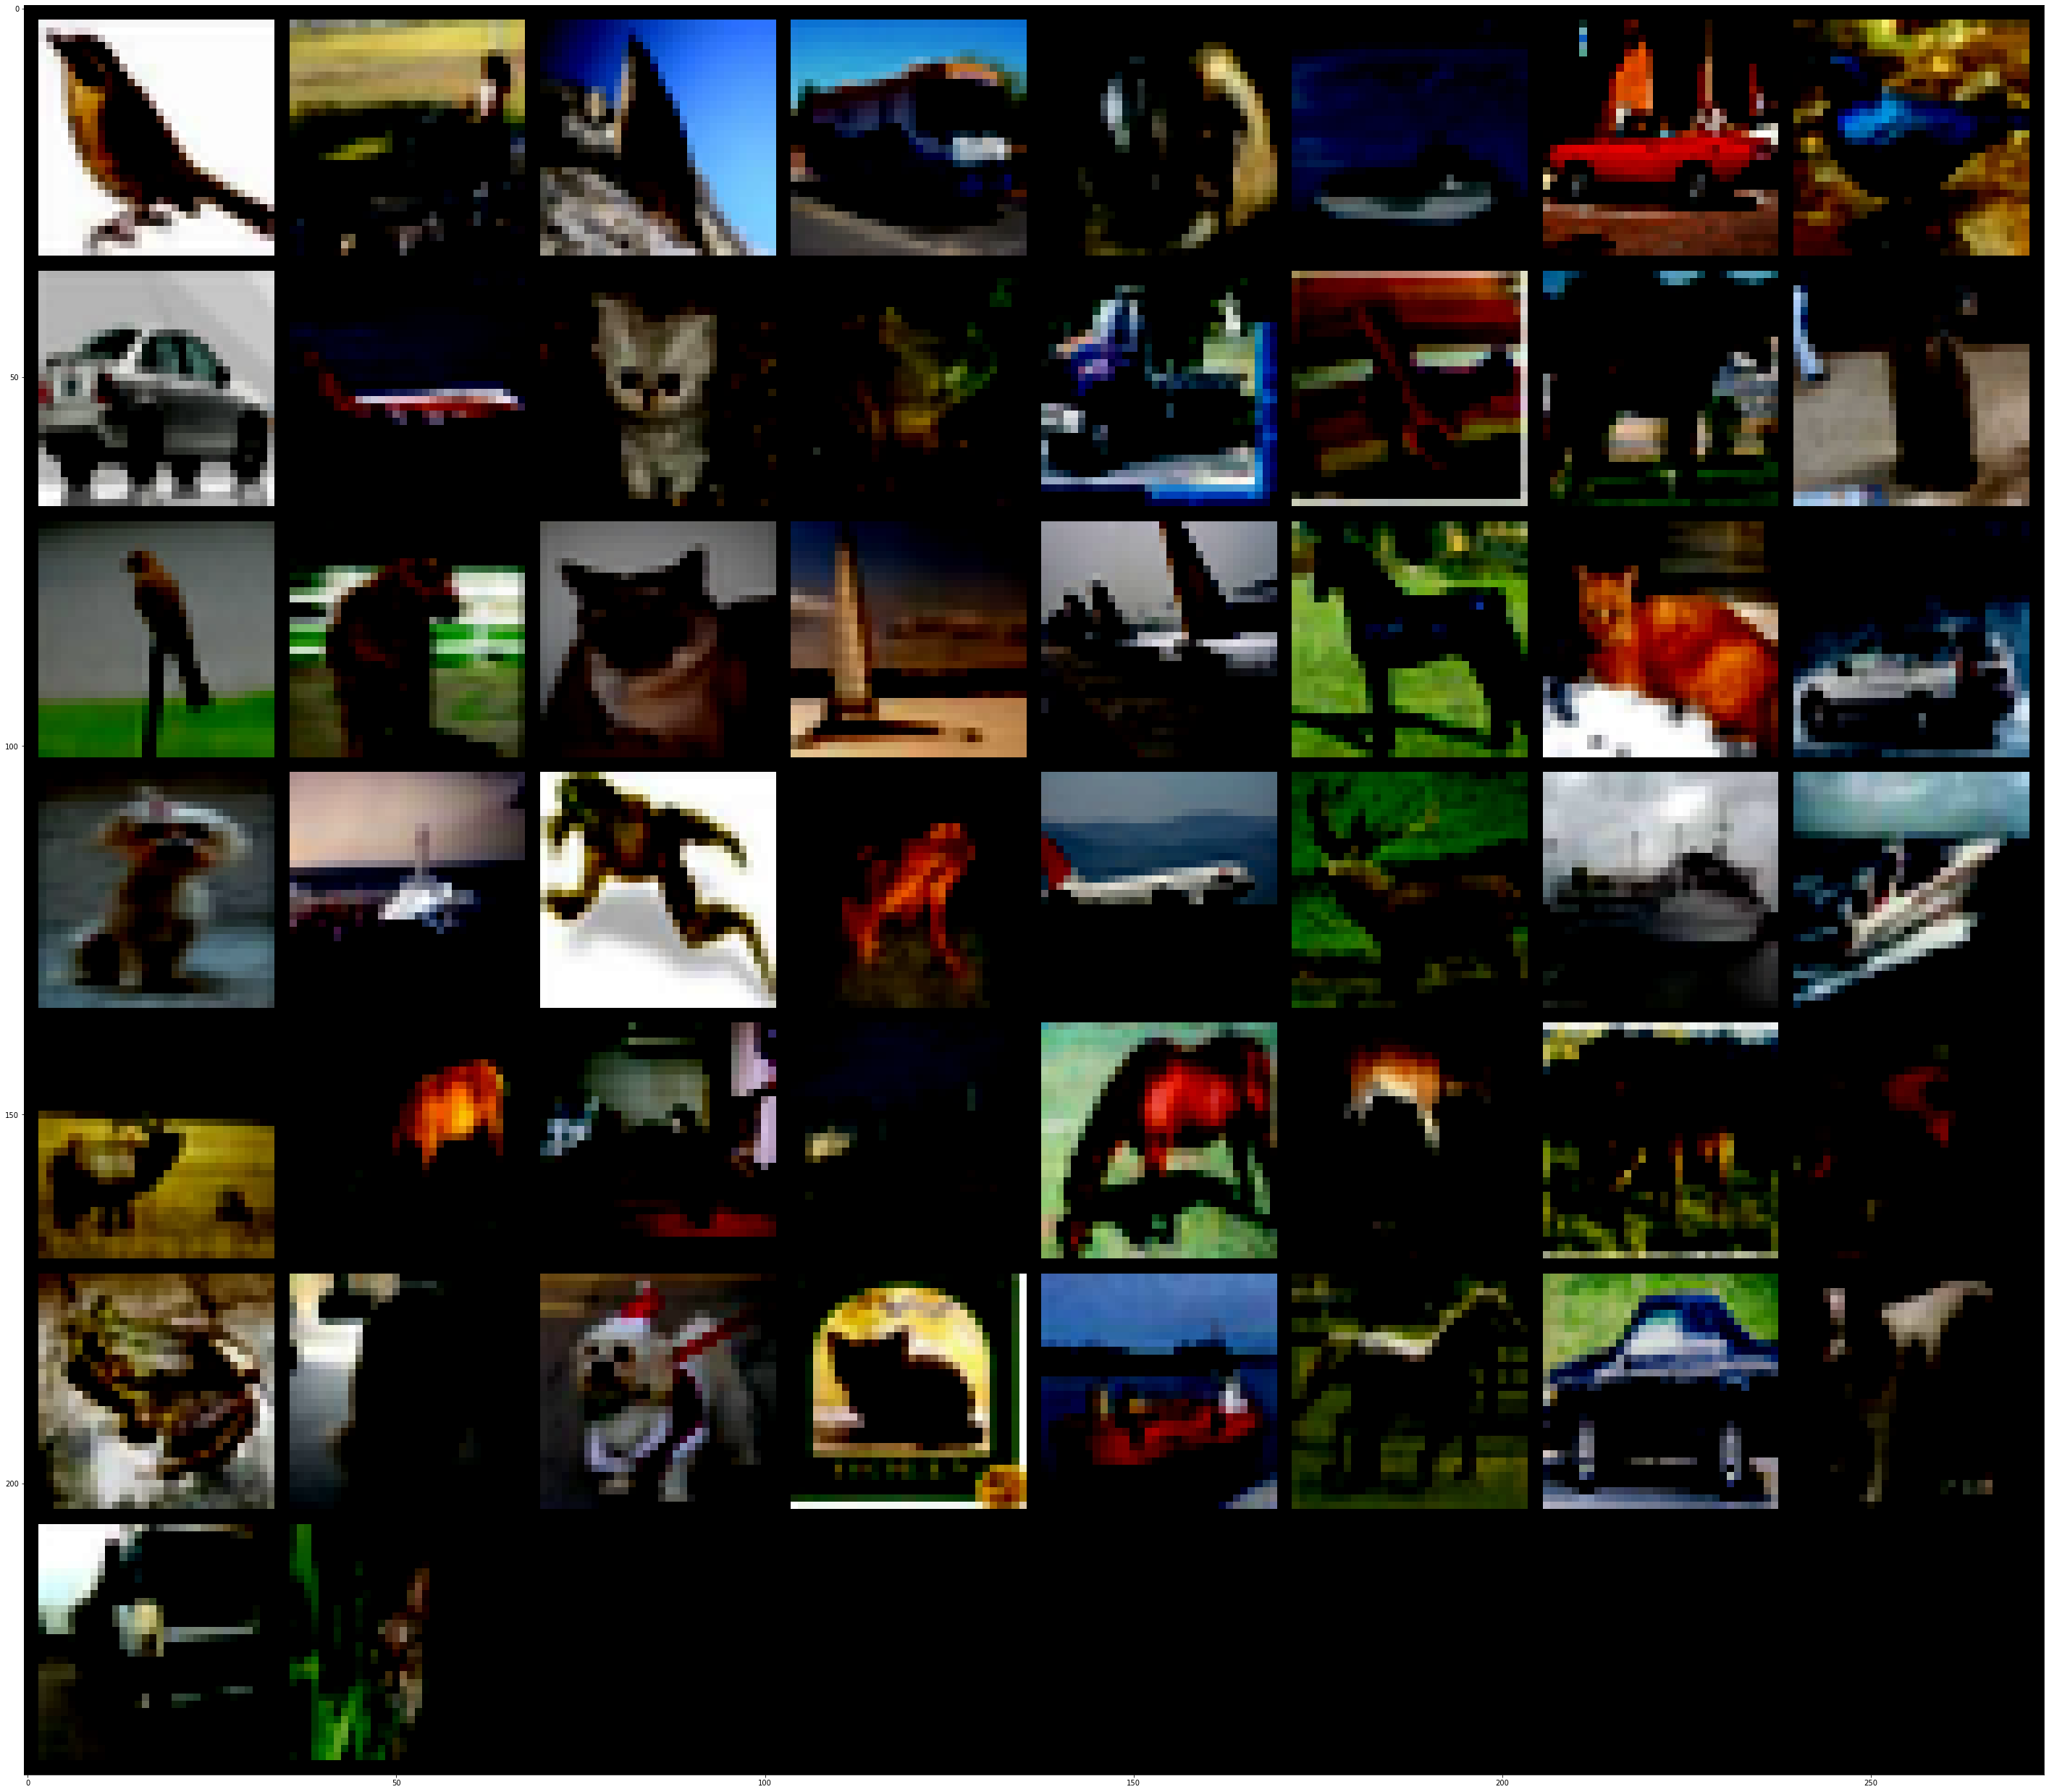

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


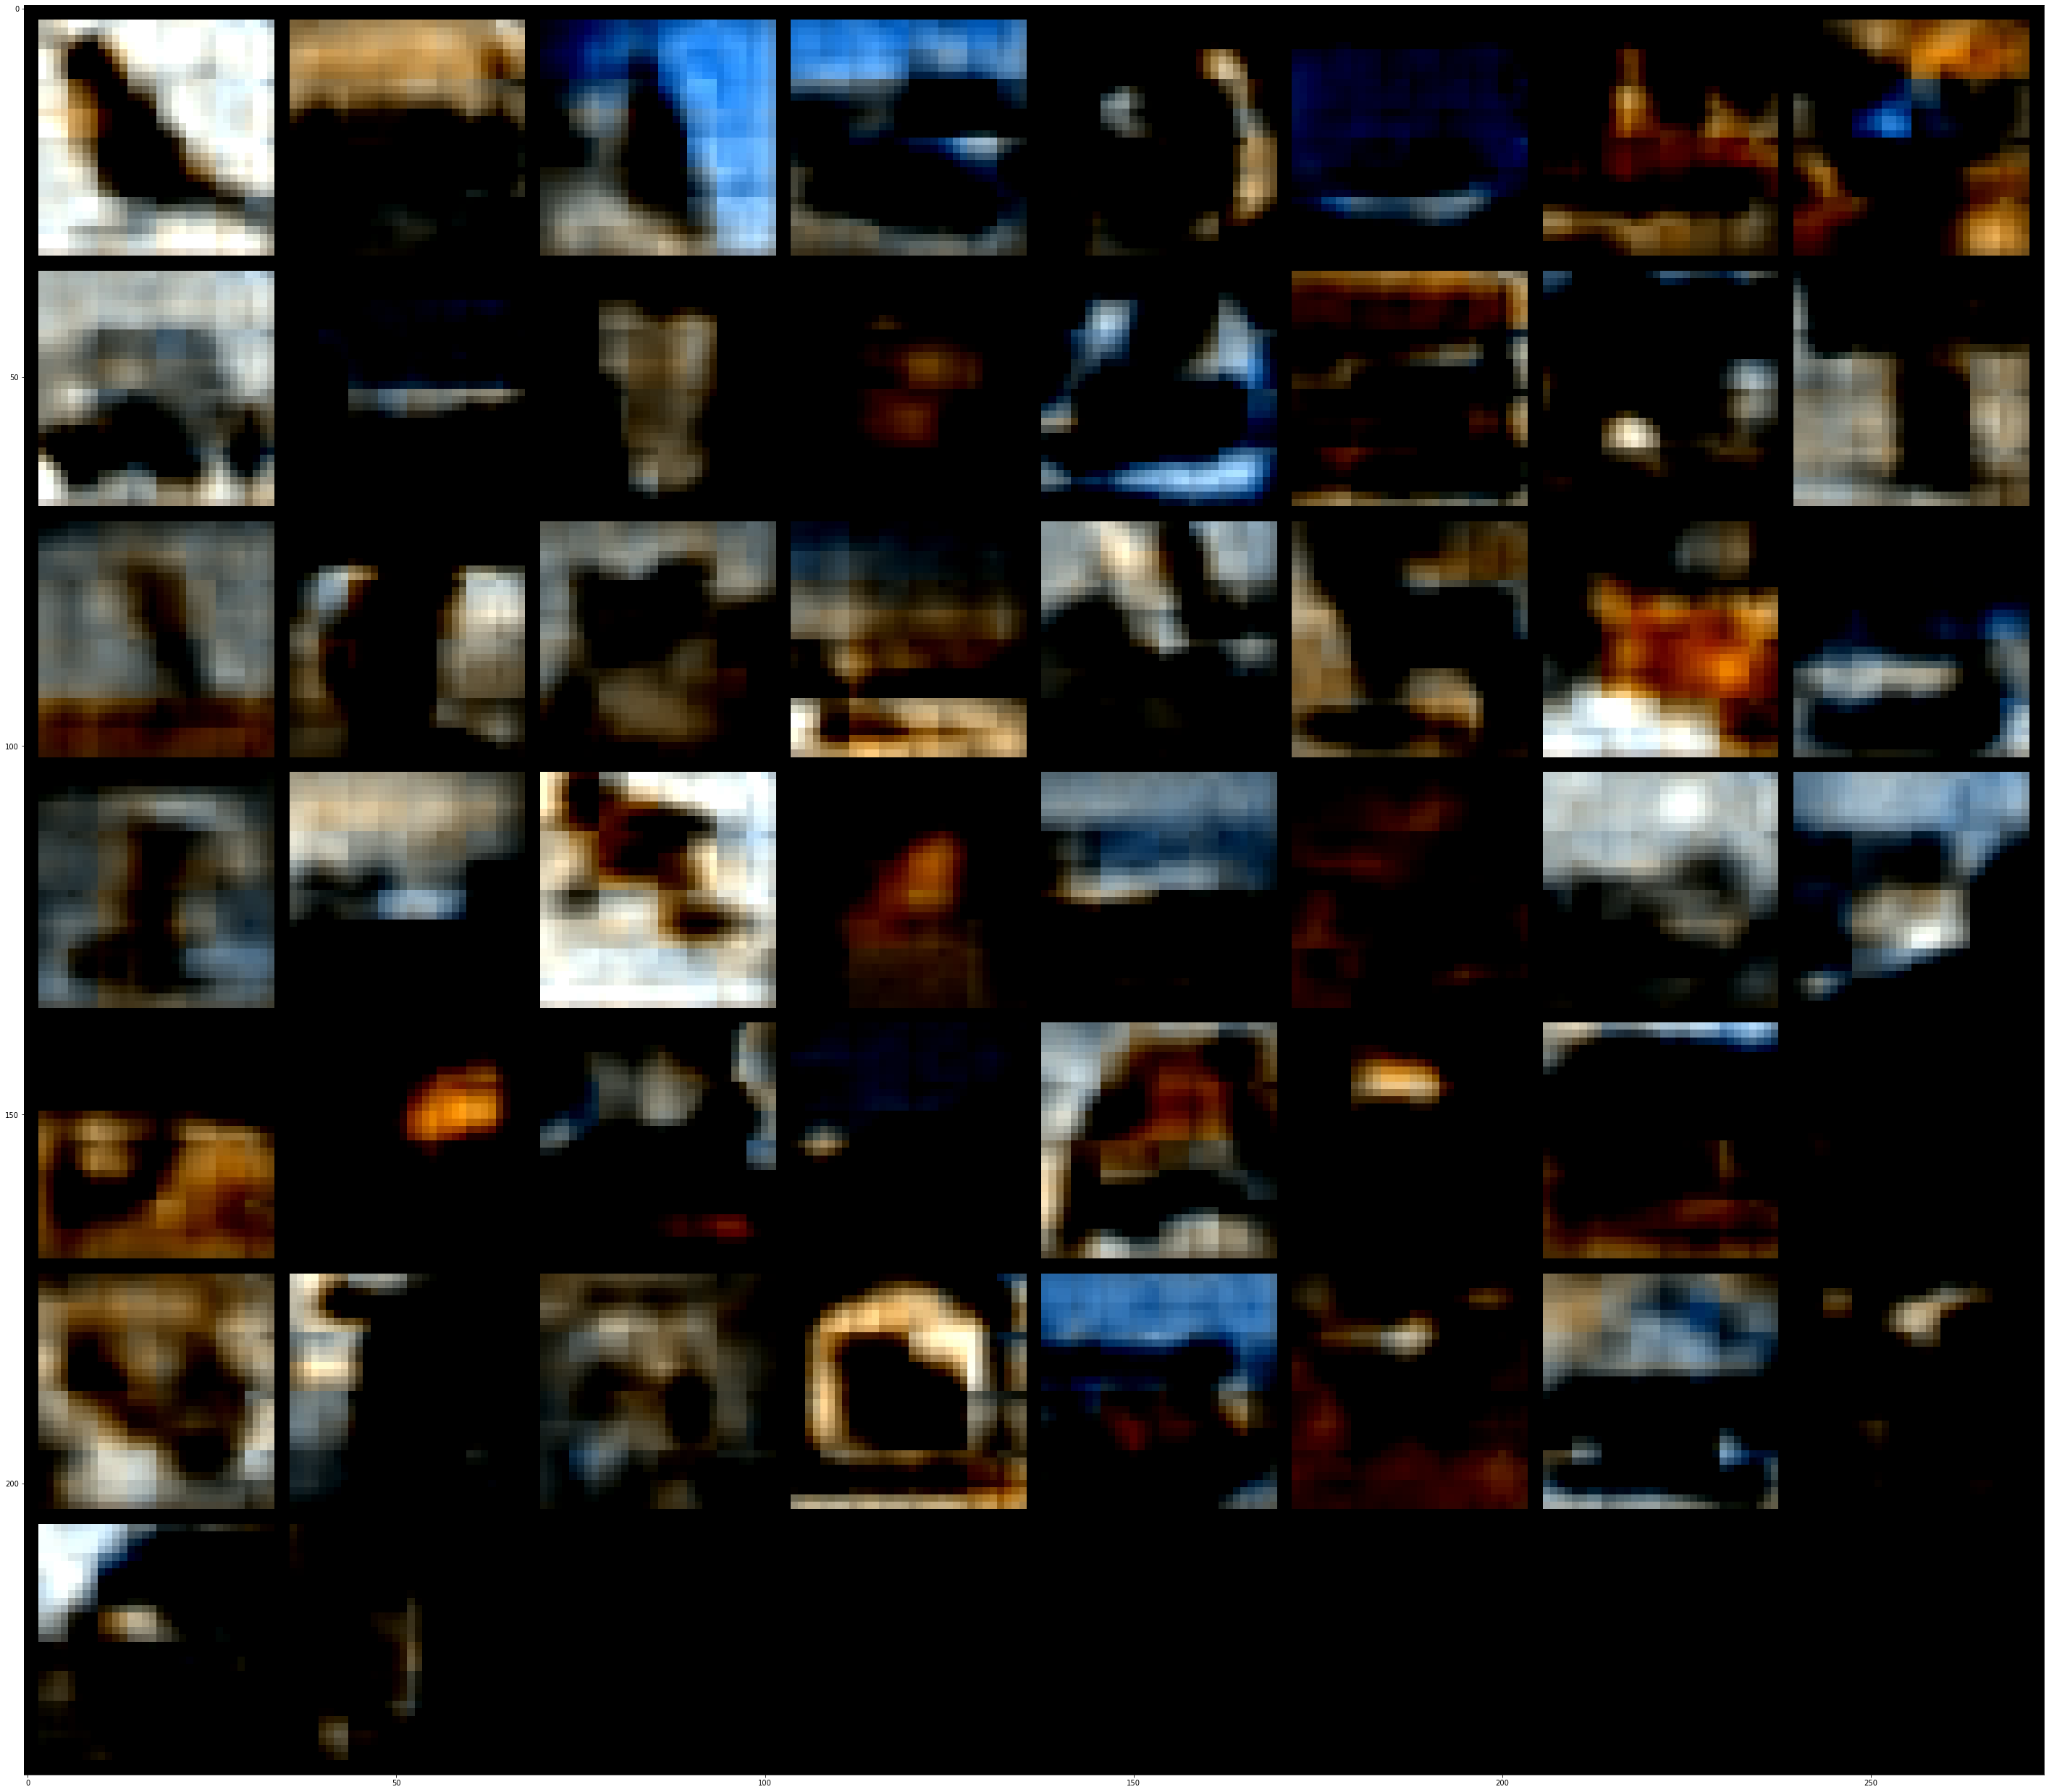

Epoch 1: Train Loss: 0.0703
Epoch 2: Train Loss: 0.0388
Epoch 3: Train Loss: 0.0349
Epoch 4: Train Loss: 0.0332


Epoch 5: Train Loss: 0.0321


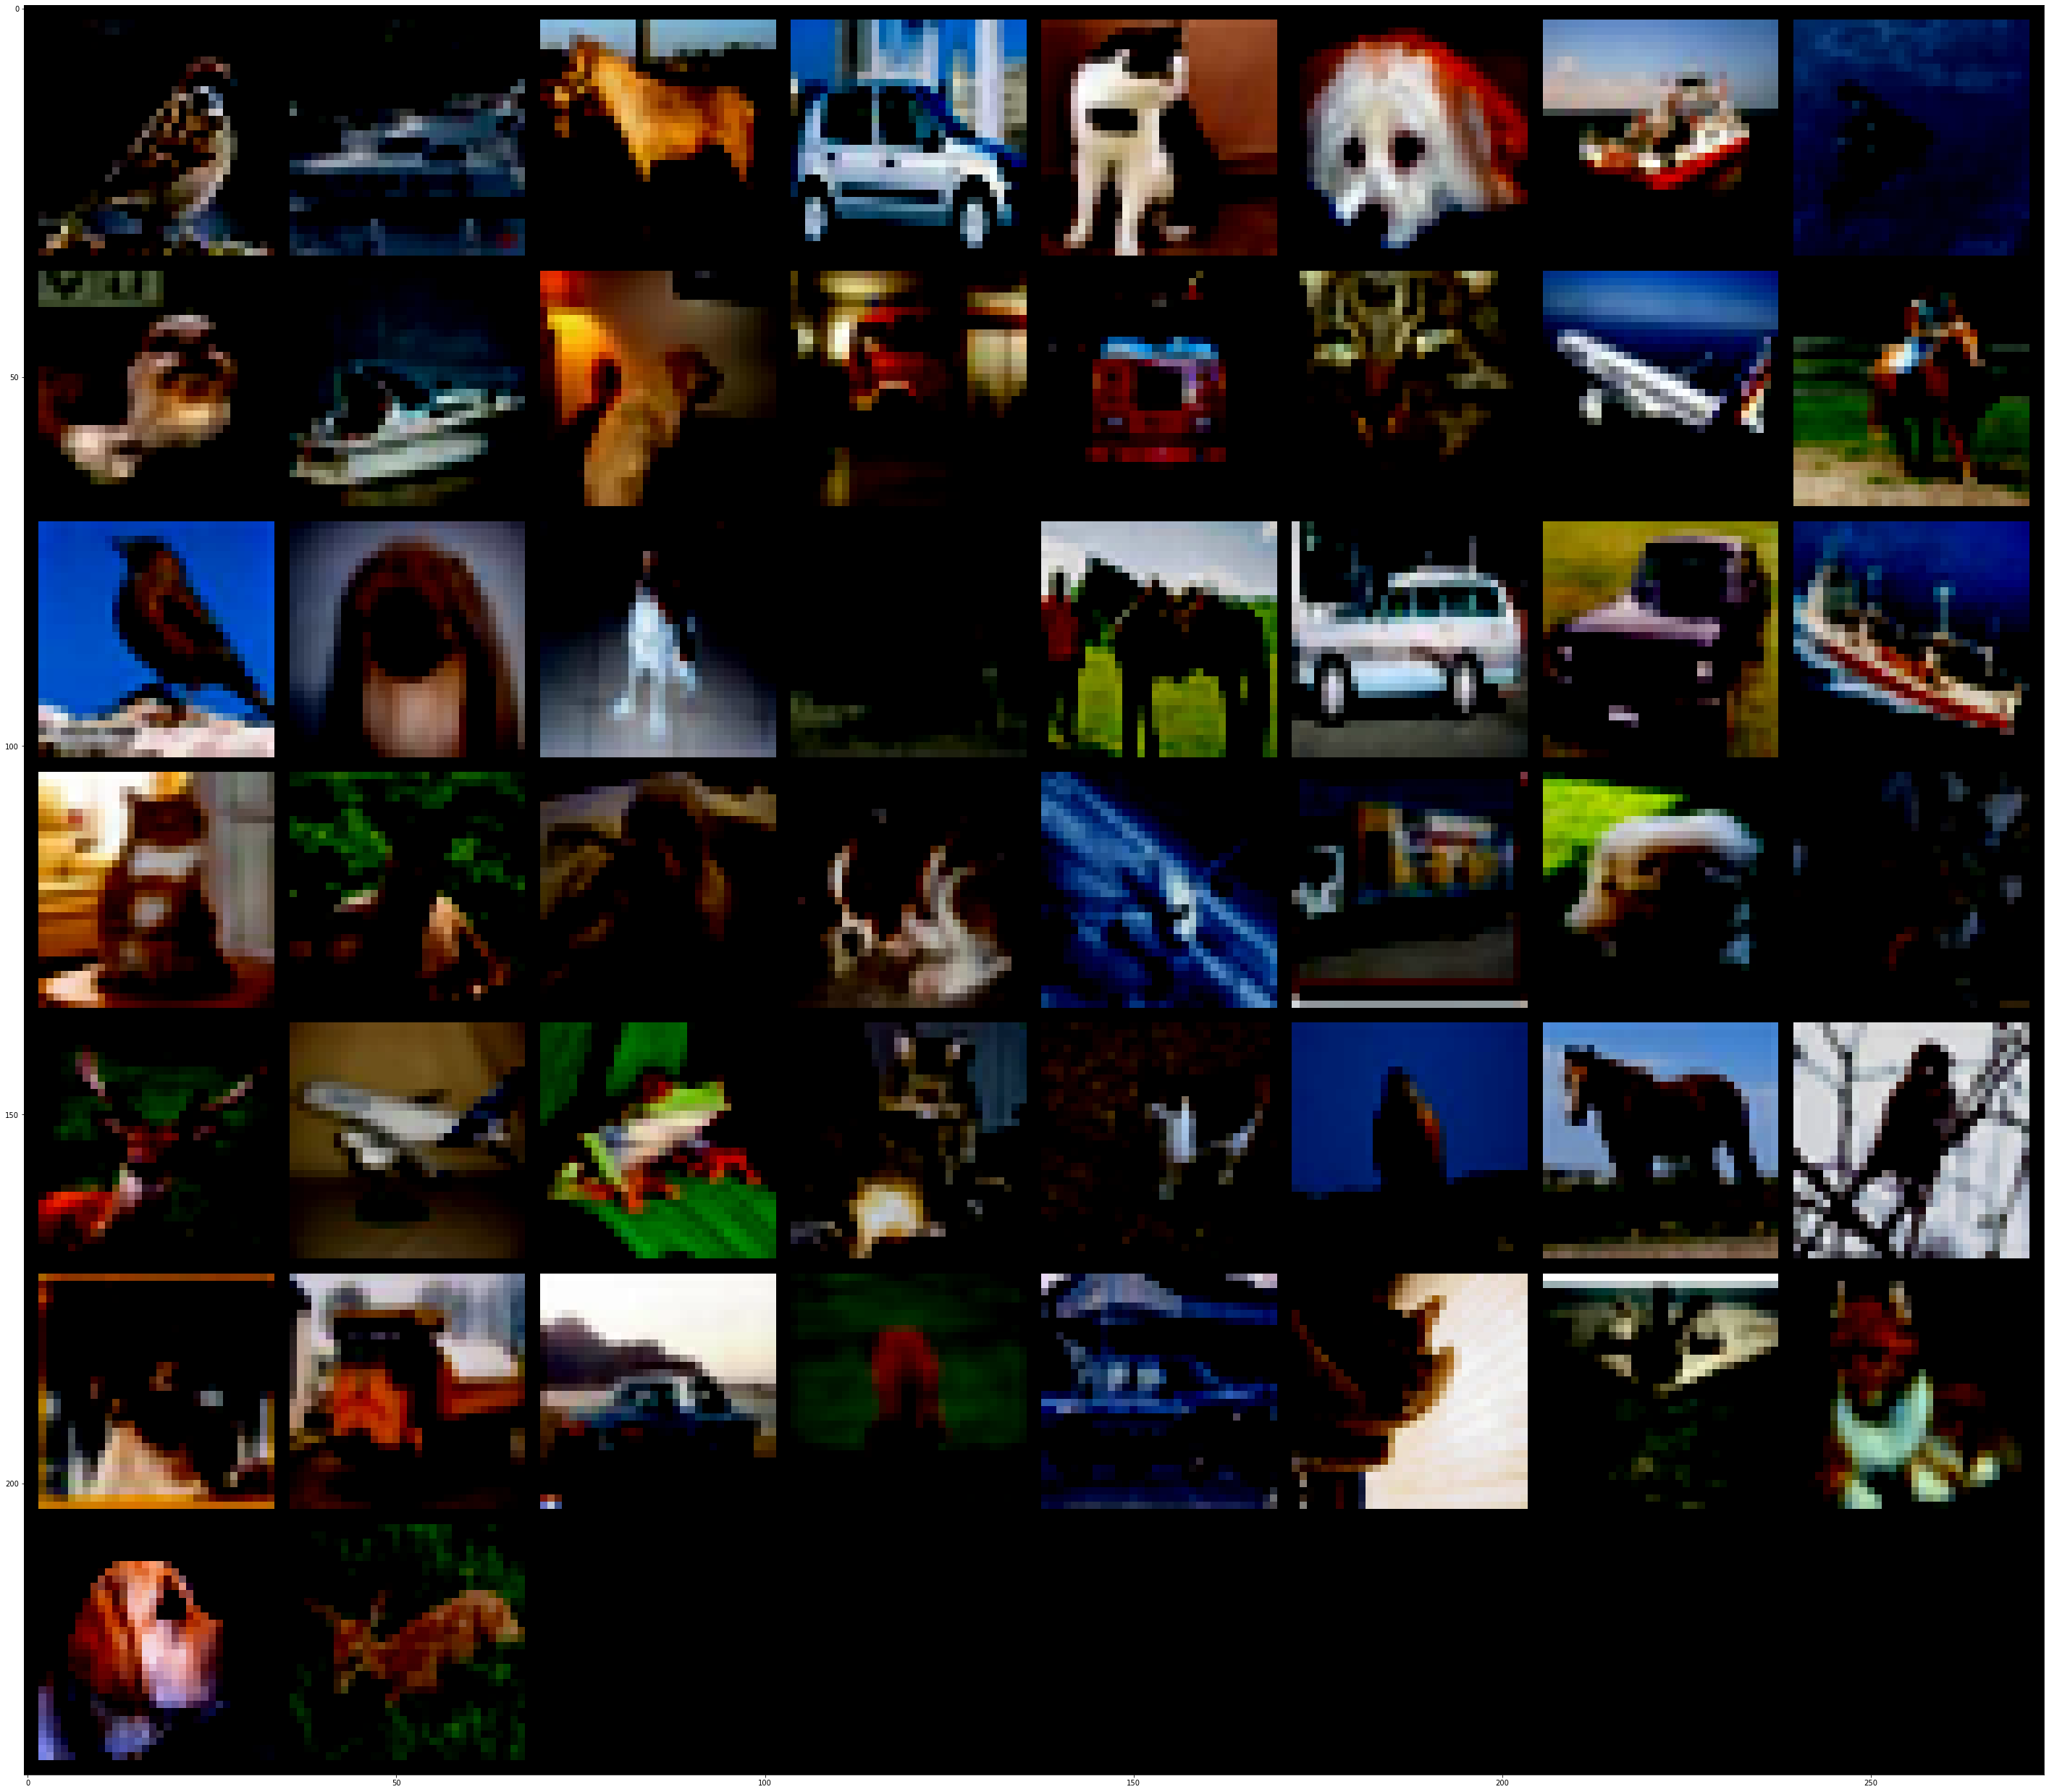

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


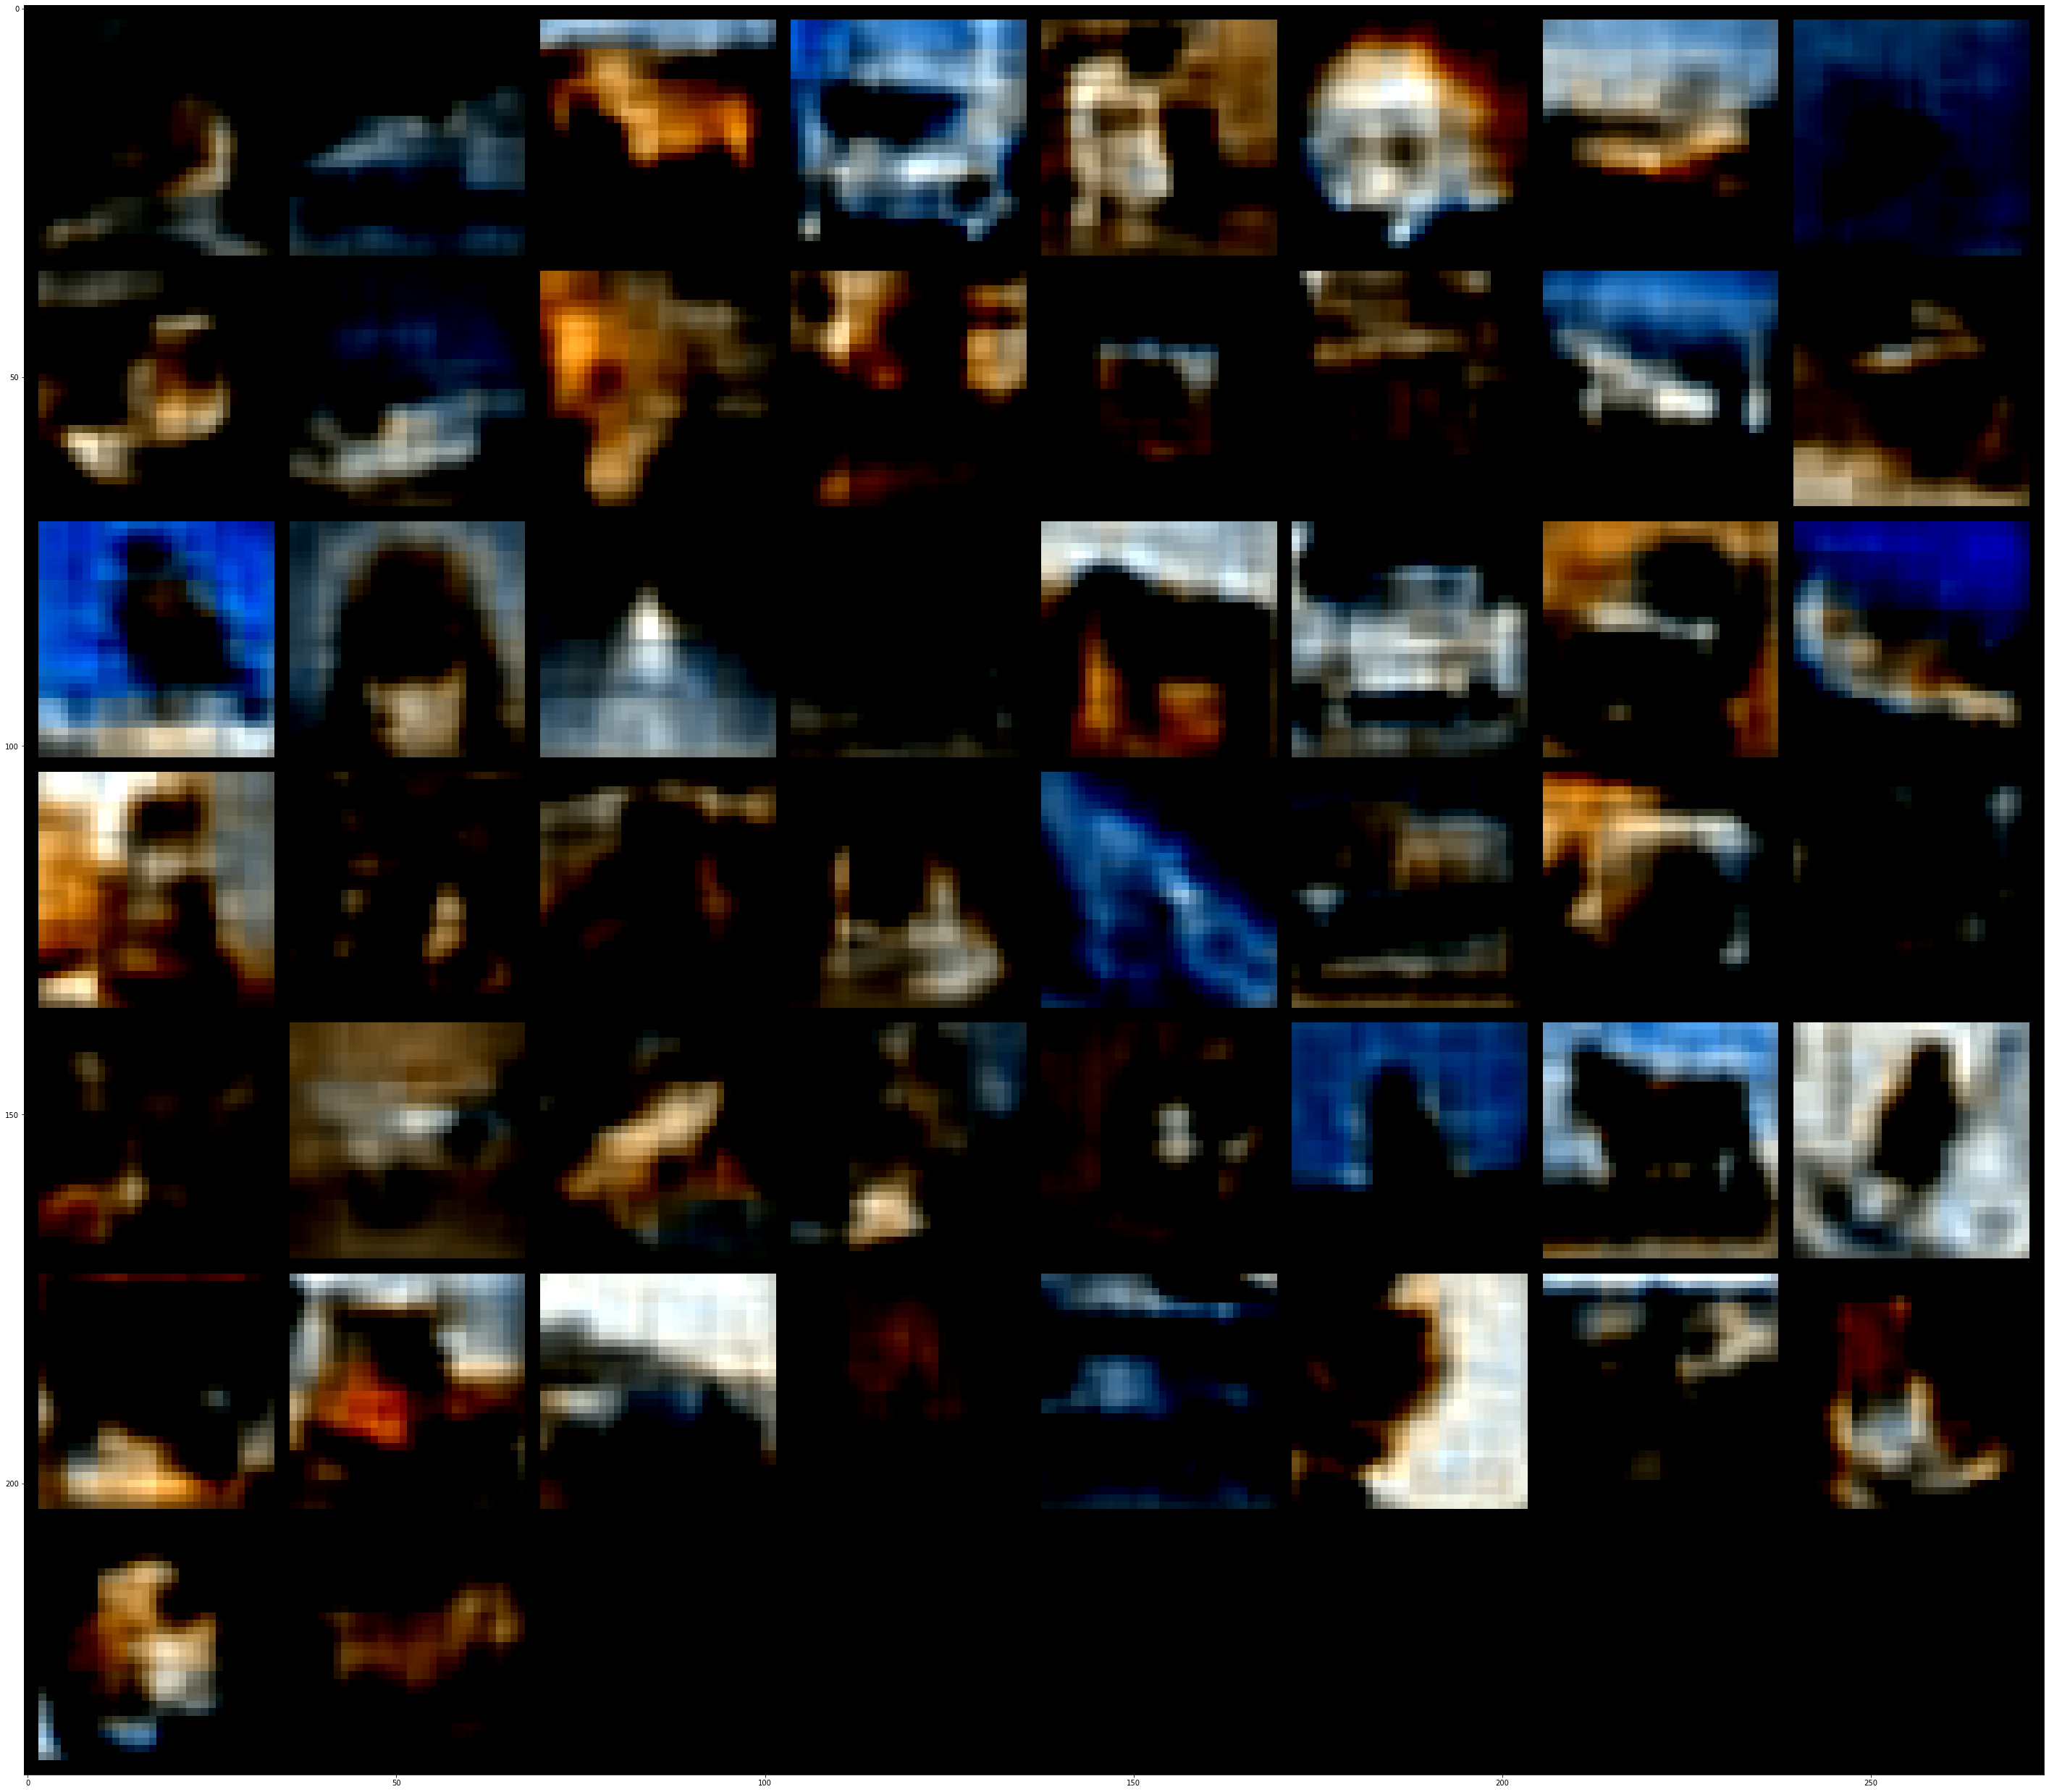

Epoch 1: Train Loss: 0.0702
Epoch 2: Train Loss: 0.0416
Epoch 3: Train Loss: 0.0333
Epoch 4: Train Loss: 0.0312


Epoch 5: Train Loss: 0.0300


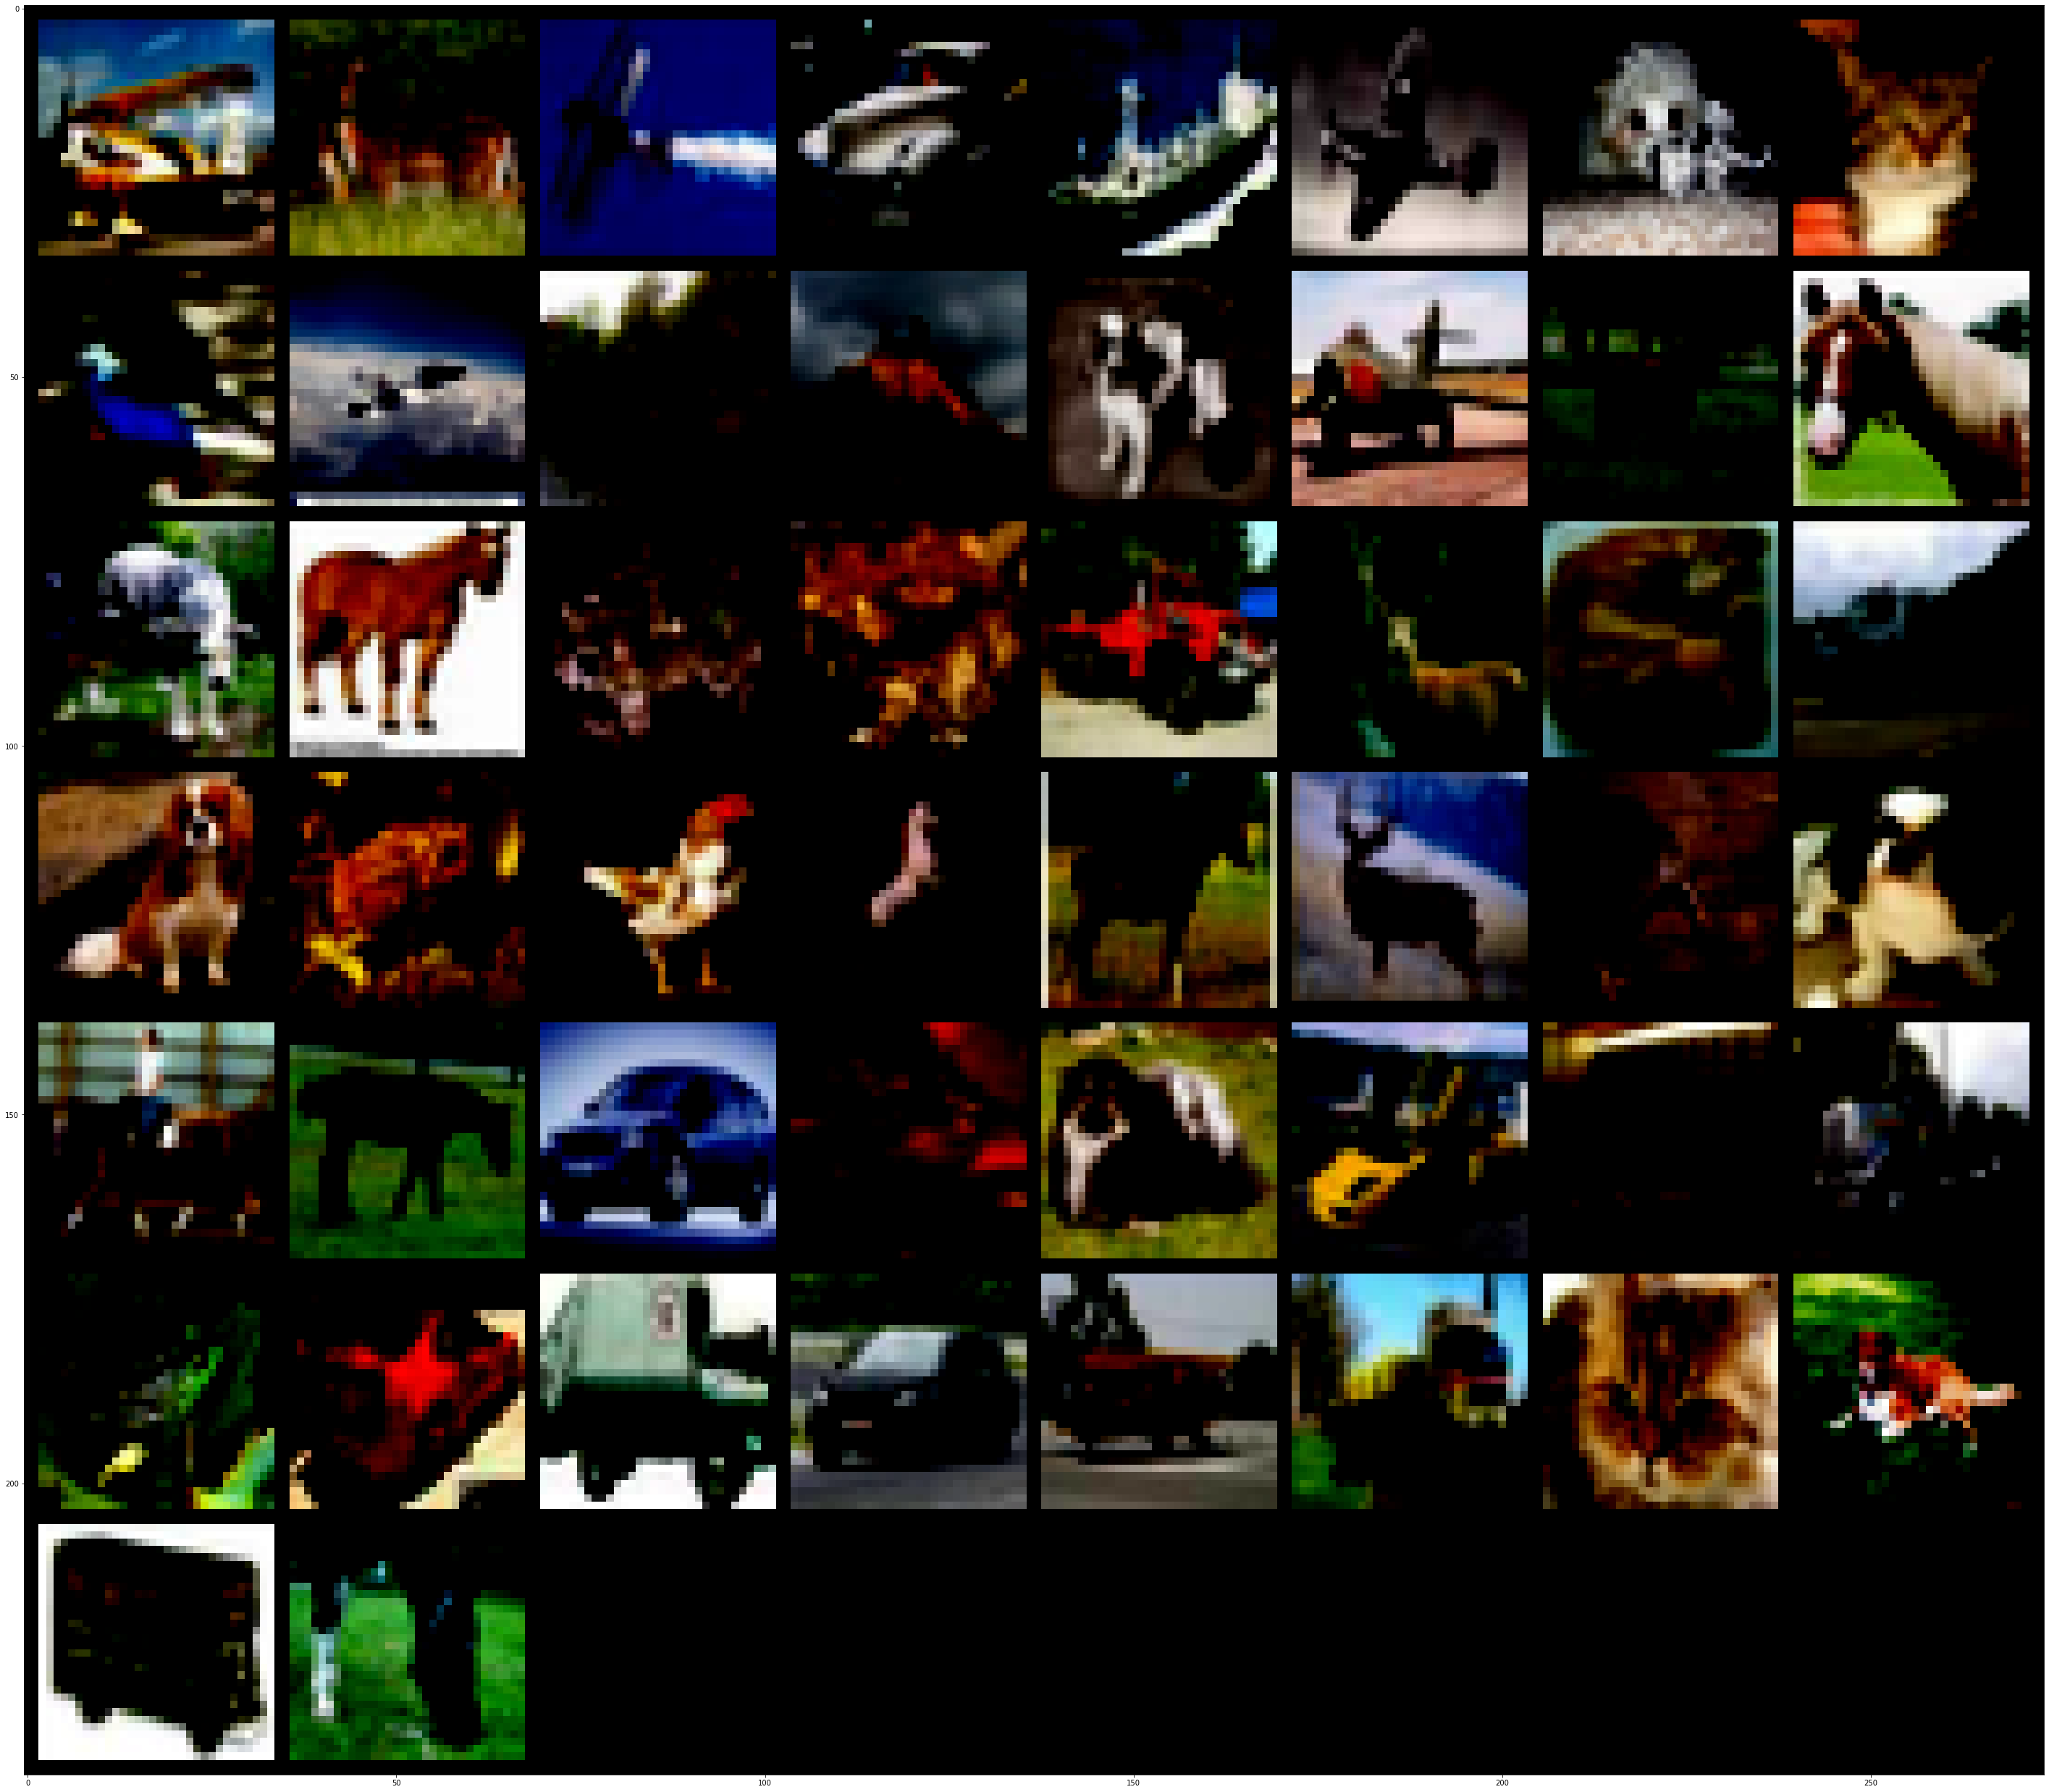

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


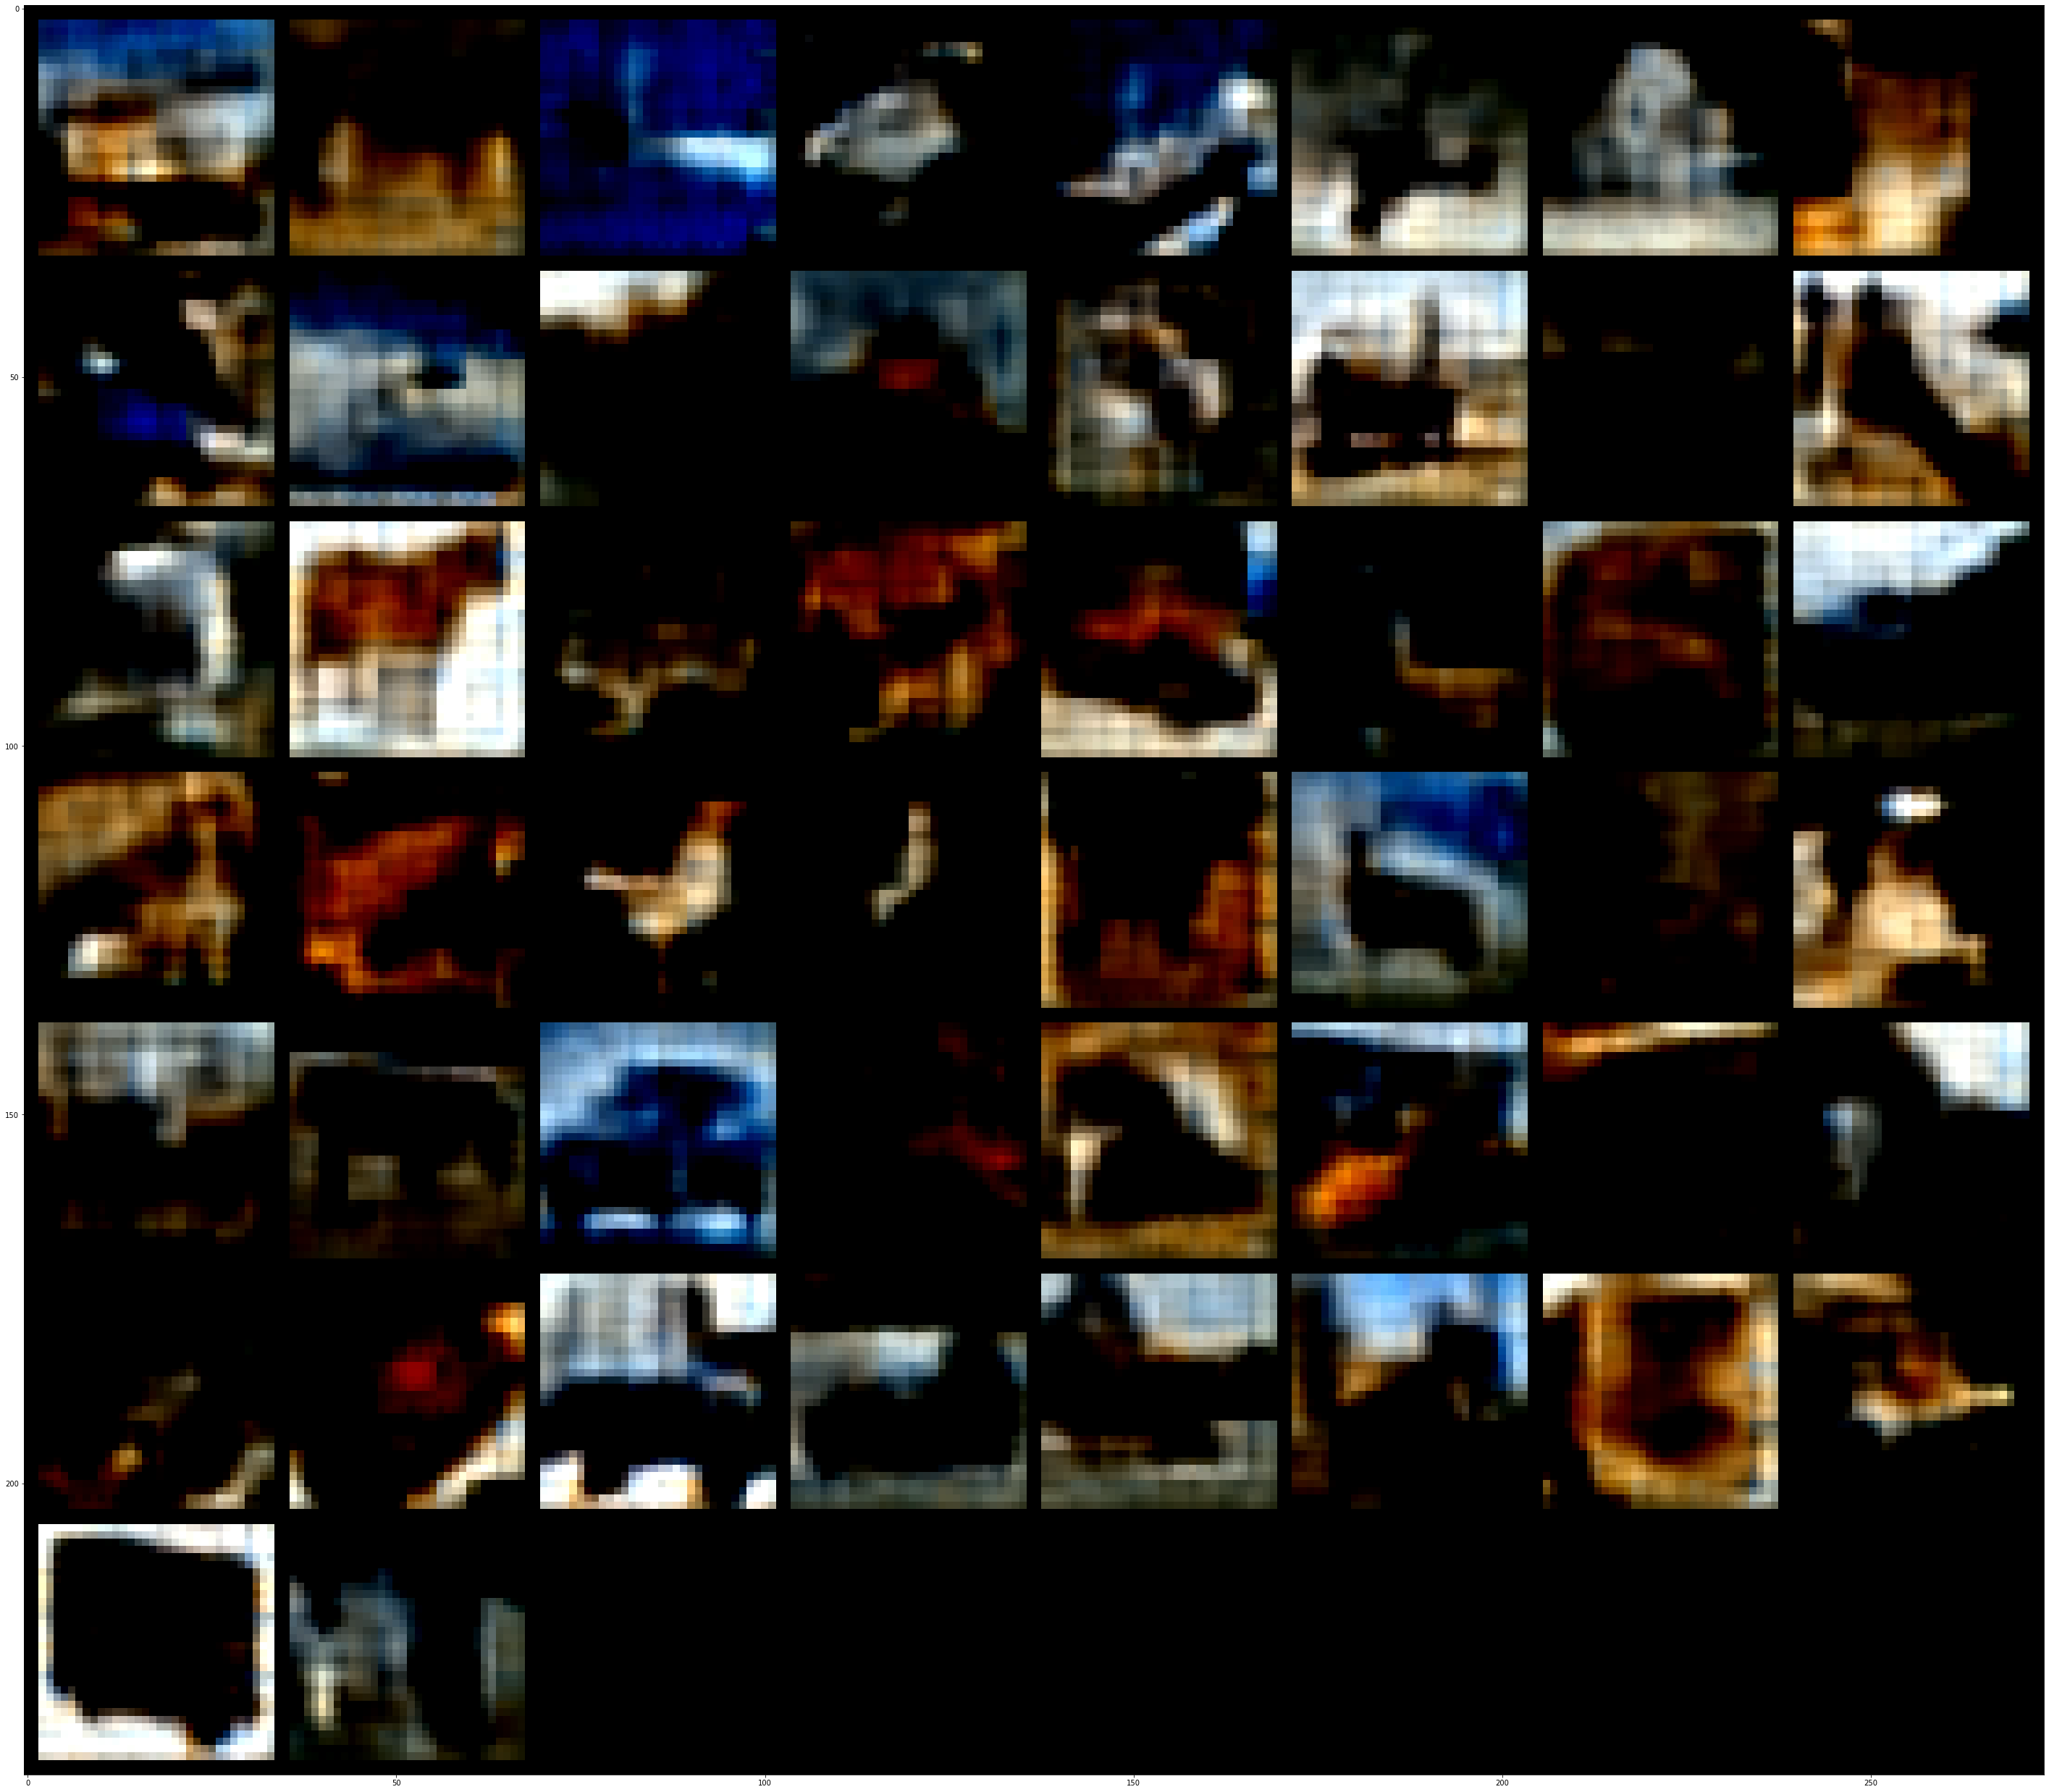

In [ ]:
# code and analysis here

class CNN_Autoencoder_with_rtsize(nn.Module):
    def __init__(self,outputchannel):
        super(CNN_Autoencoder_with_rtsize, self).__init__()
        self.outputchannel=outputchannel
        # Encoder layers
        self.cnn_layers = nn.ModuleList()
        self.linear_transform=  nn.ModuleList()
        self.revcnn_layers = nn.ModuleList()

        self.cnn_layers.append(nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1))
        self.cnn_layers.append(nn.ReLU())
        self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.cnn_layers.append(nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1))
        self.cnn_layers.append(nn.ReLU())
        self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.cnn_layers.append(nn.Conv2d(8, self.outputchannel, kernel_size=3, stride=1, padding=1))
        self.cnn_layers.append(nn.ReLU())
        self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        

        self.revcnn_layers.append(nn.ConvTranspose2d(self.outputchannel, 8, kernel_size=3, stride=2, padding=1, output_padding=1))
        self.revcnn_layers.append(nn.ReLU())

        self.revcnn_layers.append(nn.ConvTranspose2d( 8,4, kernel_size=3, stride=2, padding=1, output_padding=1))
        self.cnn_layers.append(nn.ReLU())

        self.revcnn_layers.append(nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1, output_padding=1))
        self.cnn_layers.append(nn.ReLU())
    def encoding(self,x):
      print(x.shape)
      for i in self.cnn_layers:
          x=i(x)
      return x
    def decoding(self,x):
      for i in self.revcnn_layers:
          x=i(x)
      return x
          
    def forward(self, x):
        x=self.encoding(x)
        x=self.decoding(x)
        return x


l=[10,32,100,1000]
cnnmodellist=[]
for i in l:
  cnn_model_with_rt = CNN_Autoencoder_with_rtsize(i).to(device)
  cnn_optimizer = torch.optim.Adam(cnn_model_with_rt.parameters(), lr=0.001)
  cnn_criterion = nn.MSELoss()


  cnn_losses = []
  for epoch in range(5):
      train_loss = train(cnn_model_with_rt, train_loader, cnn_optimizer, cnn_criterion, device)
      cnn_losses.append(train_loss)
      print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}")


  dataiter = iter(train_loader)
  images, labels = next(dataiter)
  # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
  imshow(torchvision.utils.make_grid(images))

  images = autograd.Variable(images)

  print("Reconstructed image")
  print(images.shape)
  images = images.cuda()
  decoded_imgs =  cnn_model_with_rt.forward(images)
  decoded_imgs=decoded_imgs.view(-1, 3, 32, 32)
  print(decoded_imgs.shape)
  decoded_imgs = decoded_imgs.to('cpu')

  imshow(torchvision.utils.make_grid(decoded_imgs))
  cnnmodellist.append(cnn_model_with_rt)


### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [ ]:
# code and analysis here\


import time
import torch
import torch.autograd as autograd

class CNN_Autoencoder(nn.Module):
    def __init__(self , nlayer):
        super(CNN_Autoencoder, self).__init__()
        self.representation_size=3
        # Encoder layers
        self.nlayer=nlayer
        self.conv_layers = nn.ModuleList()
        self.revconv_layers = nn.ModuleList()
        x=3
        y=2*x
        i=0
        self.pix=32
# stride=2, padding=1, output_padding=1
        while i <self.nlayer:
          self.conv_layers.append(nn.Conv2d(x,y, kernel_size=3, stride=1, padding=1))
          self.conv_layers.append(nn.ReLU())
          self.revconv_layers.append(nn.ReLU())
          st=2
          ot=1
          if i>=3:
            ot=0
            st=1
          self.revconv_layers.append(nn.ConvTranspose2d(y,x, kernel_size=3, stride=st, padding=1, output_padding=ot))
          if i<3:
            self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.pix= self.pix//2
          x=y
          if i<2:
            y=y*2
          i=i+1
          self.representation_size=x
        self.revconv_layers= nn.ModuleList(reversed(self.revconv_layers))

        self.flatten = nn.Flatten()
        

    def forward(self, x):
      for layer in self.conv_layers:
        x = layer(x)
      x = self.flatten(x)

      x = x.view(-1, self.representation_size, self.pix, self.pix)
      for layer in self.revconv_layers:
        x = layer(x)
      return x

      

cuda
Epoch 1: Train Loss: 0.1648
Epoch 2: Train Loss: 0.1547
Epoch 3: Train Loss: 0.1537
Epoch 4: Train Loss: 0.1532


Epoch 5: Train Loss: 0.1531


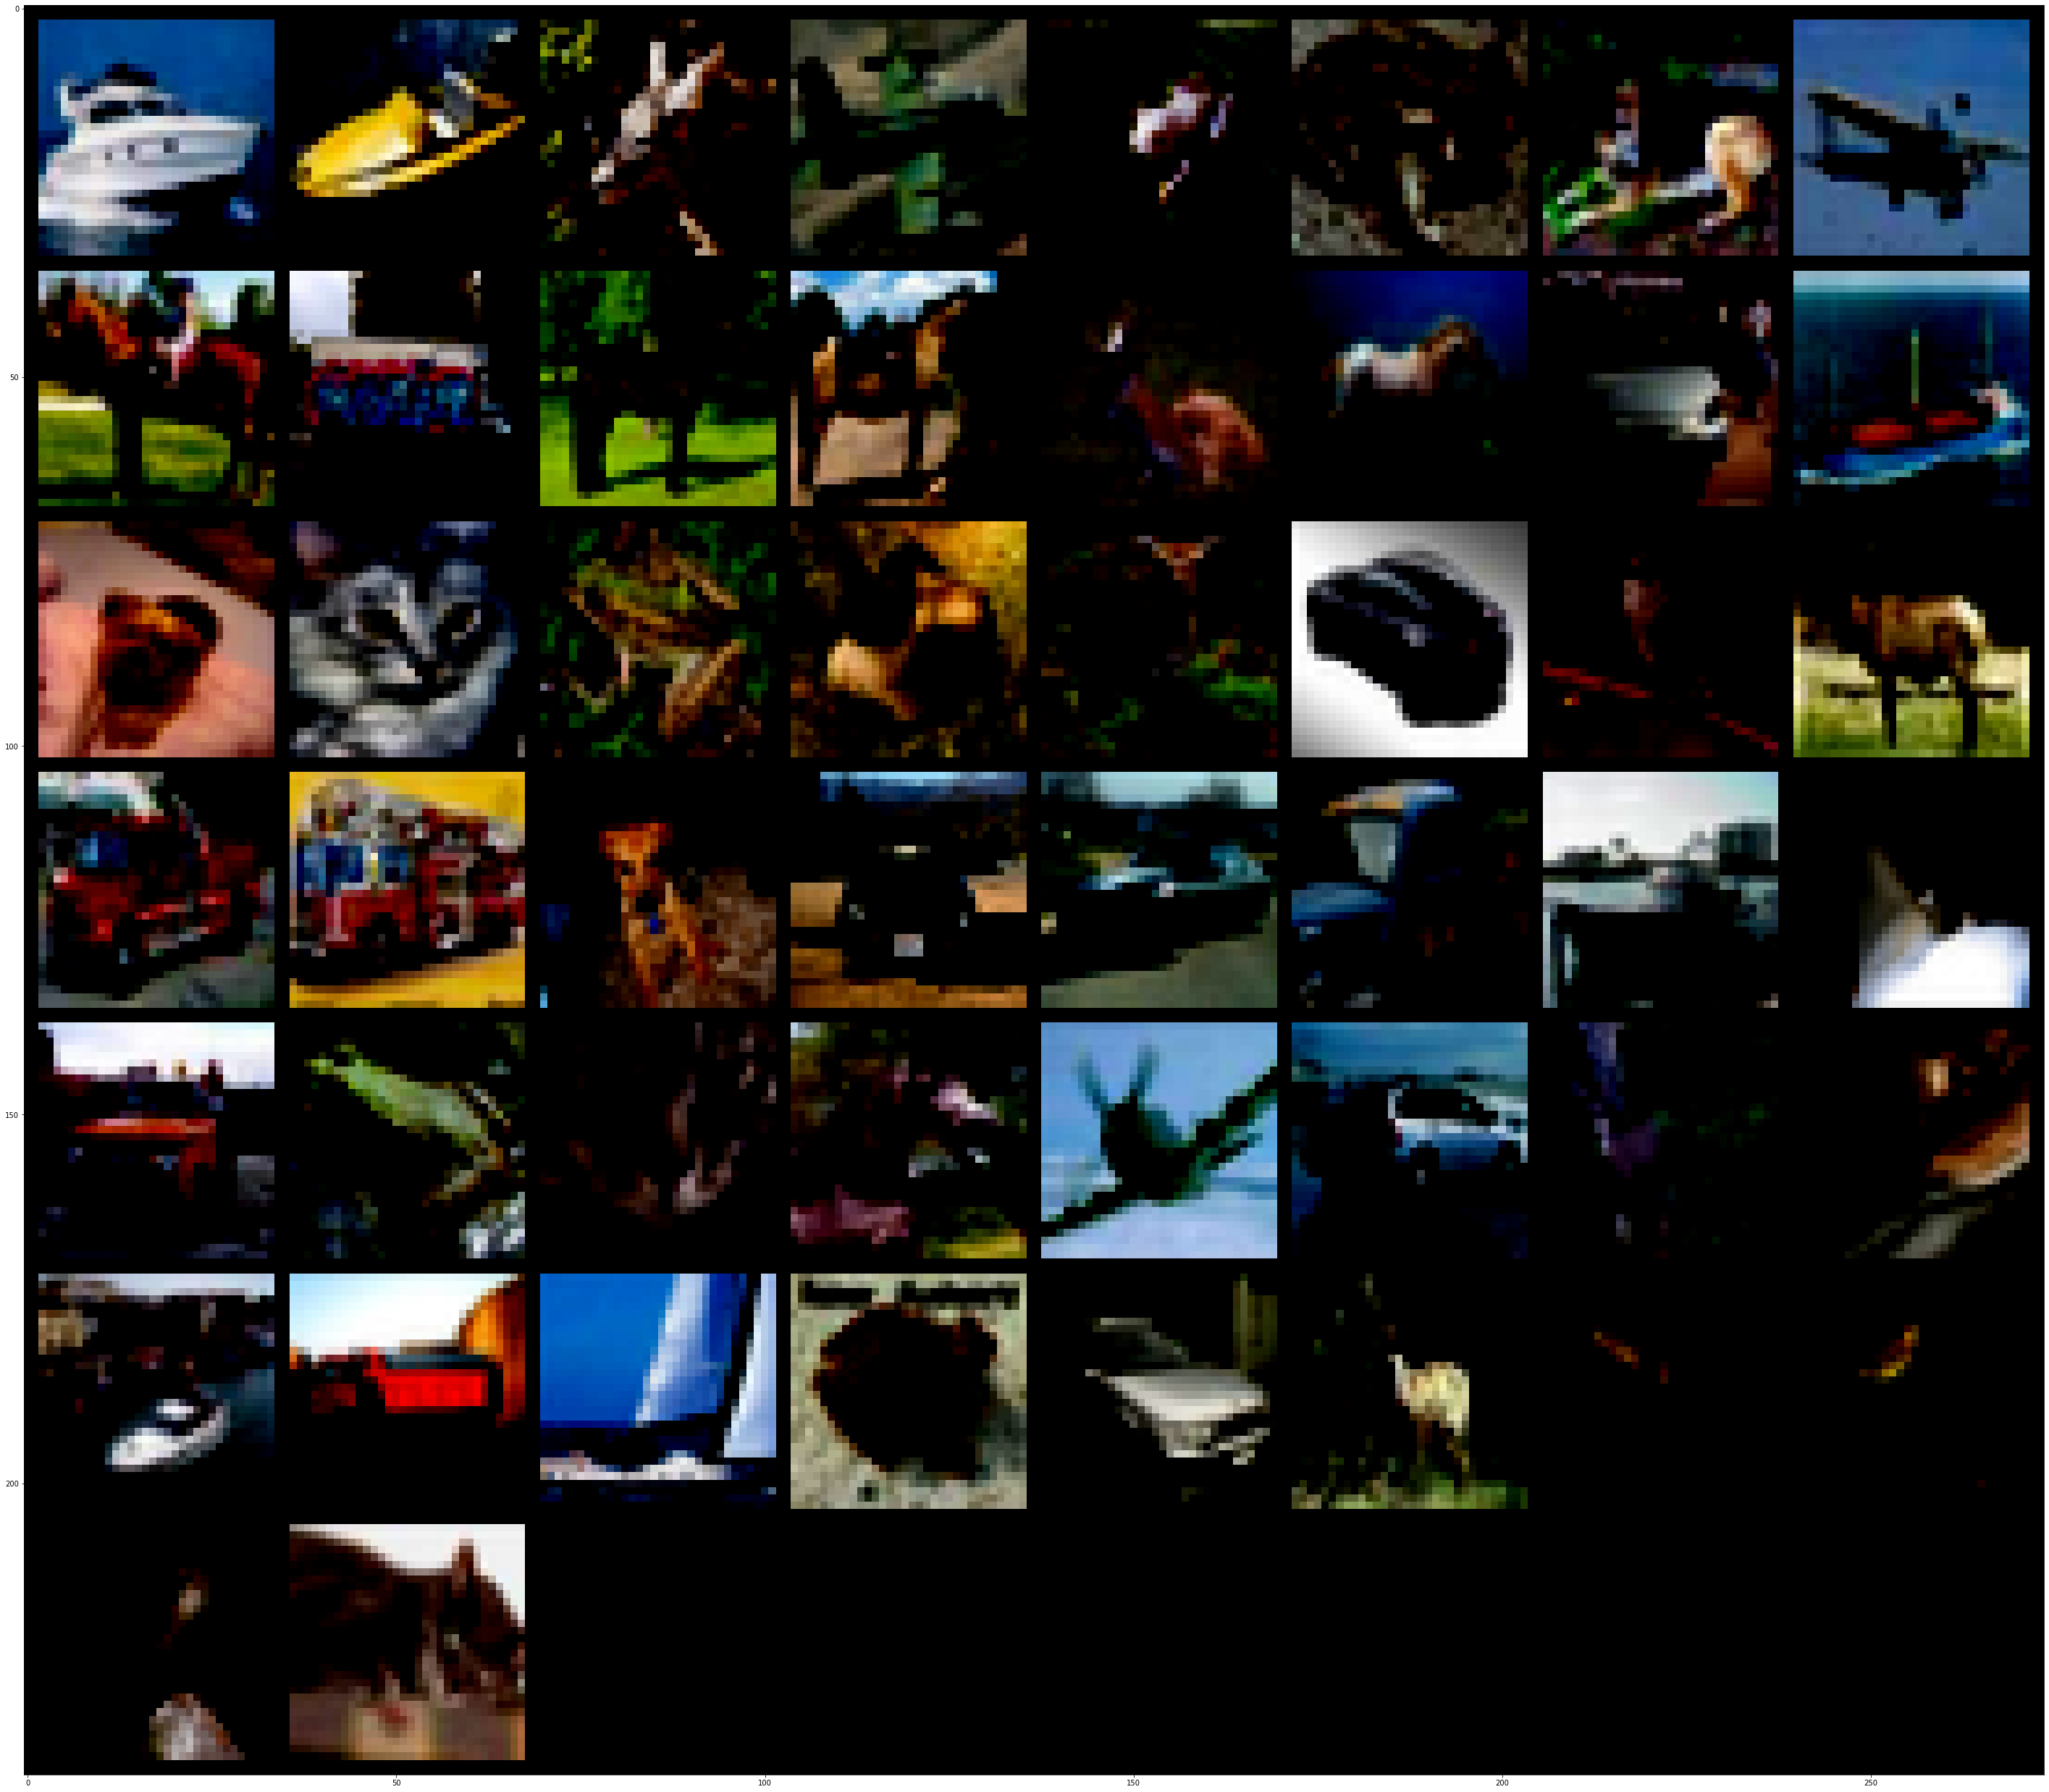

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


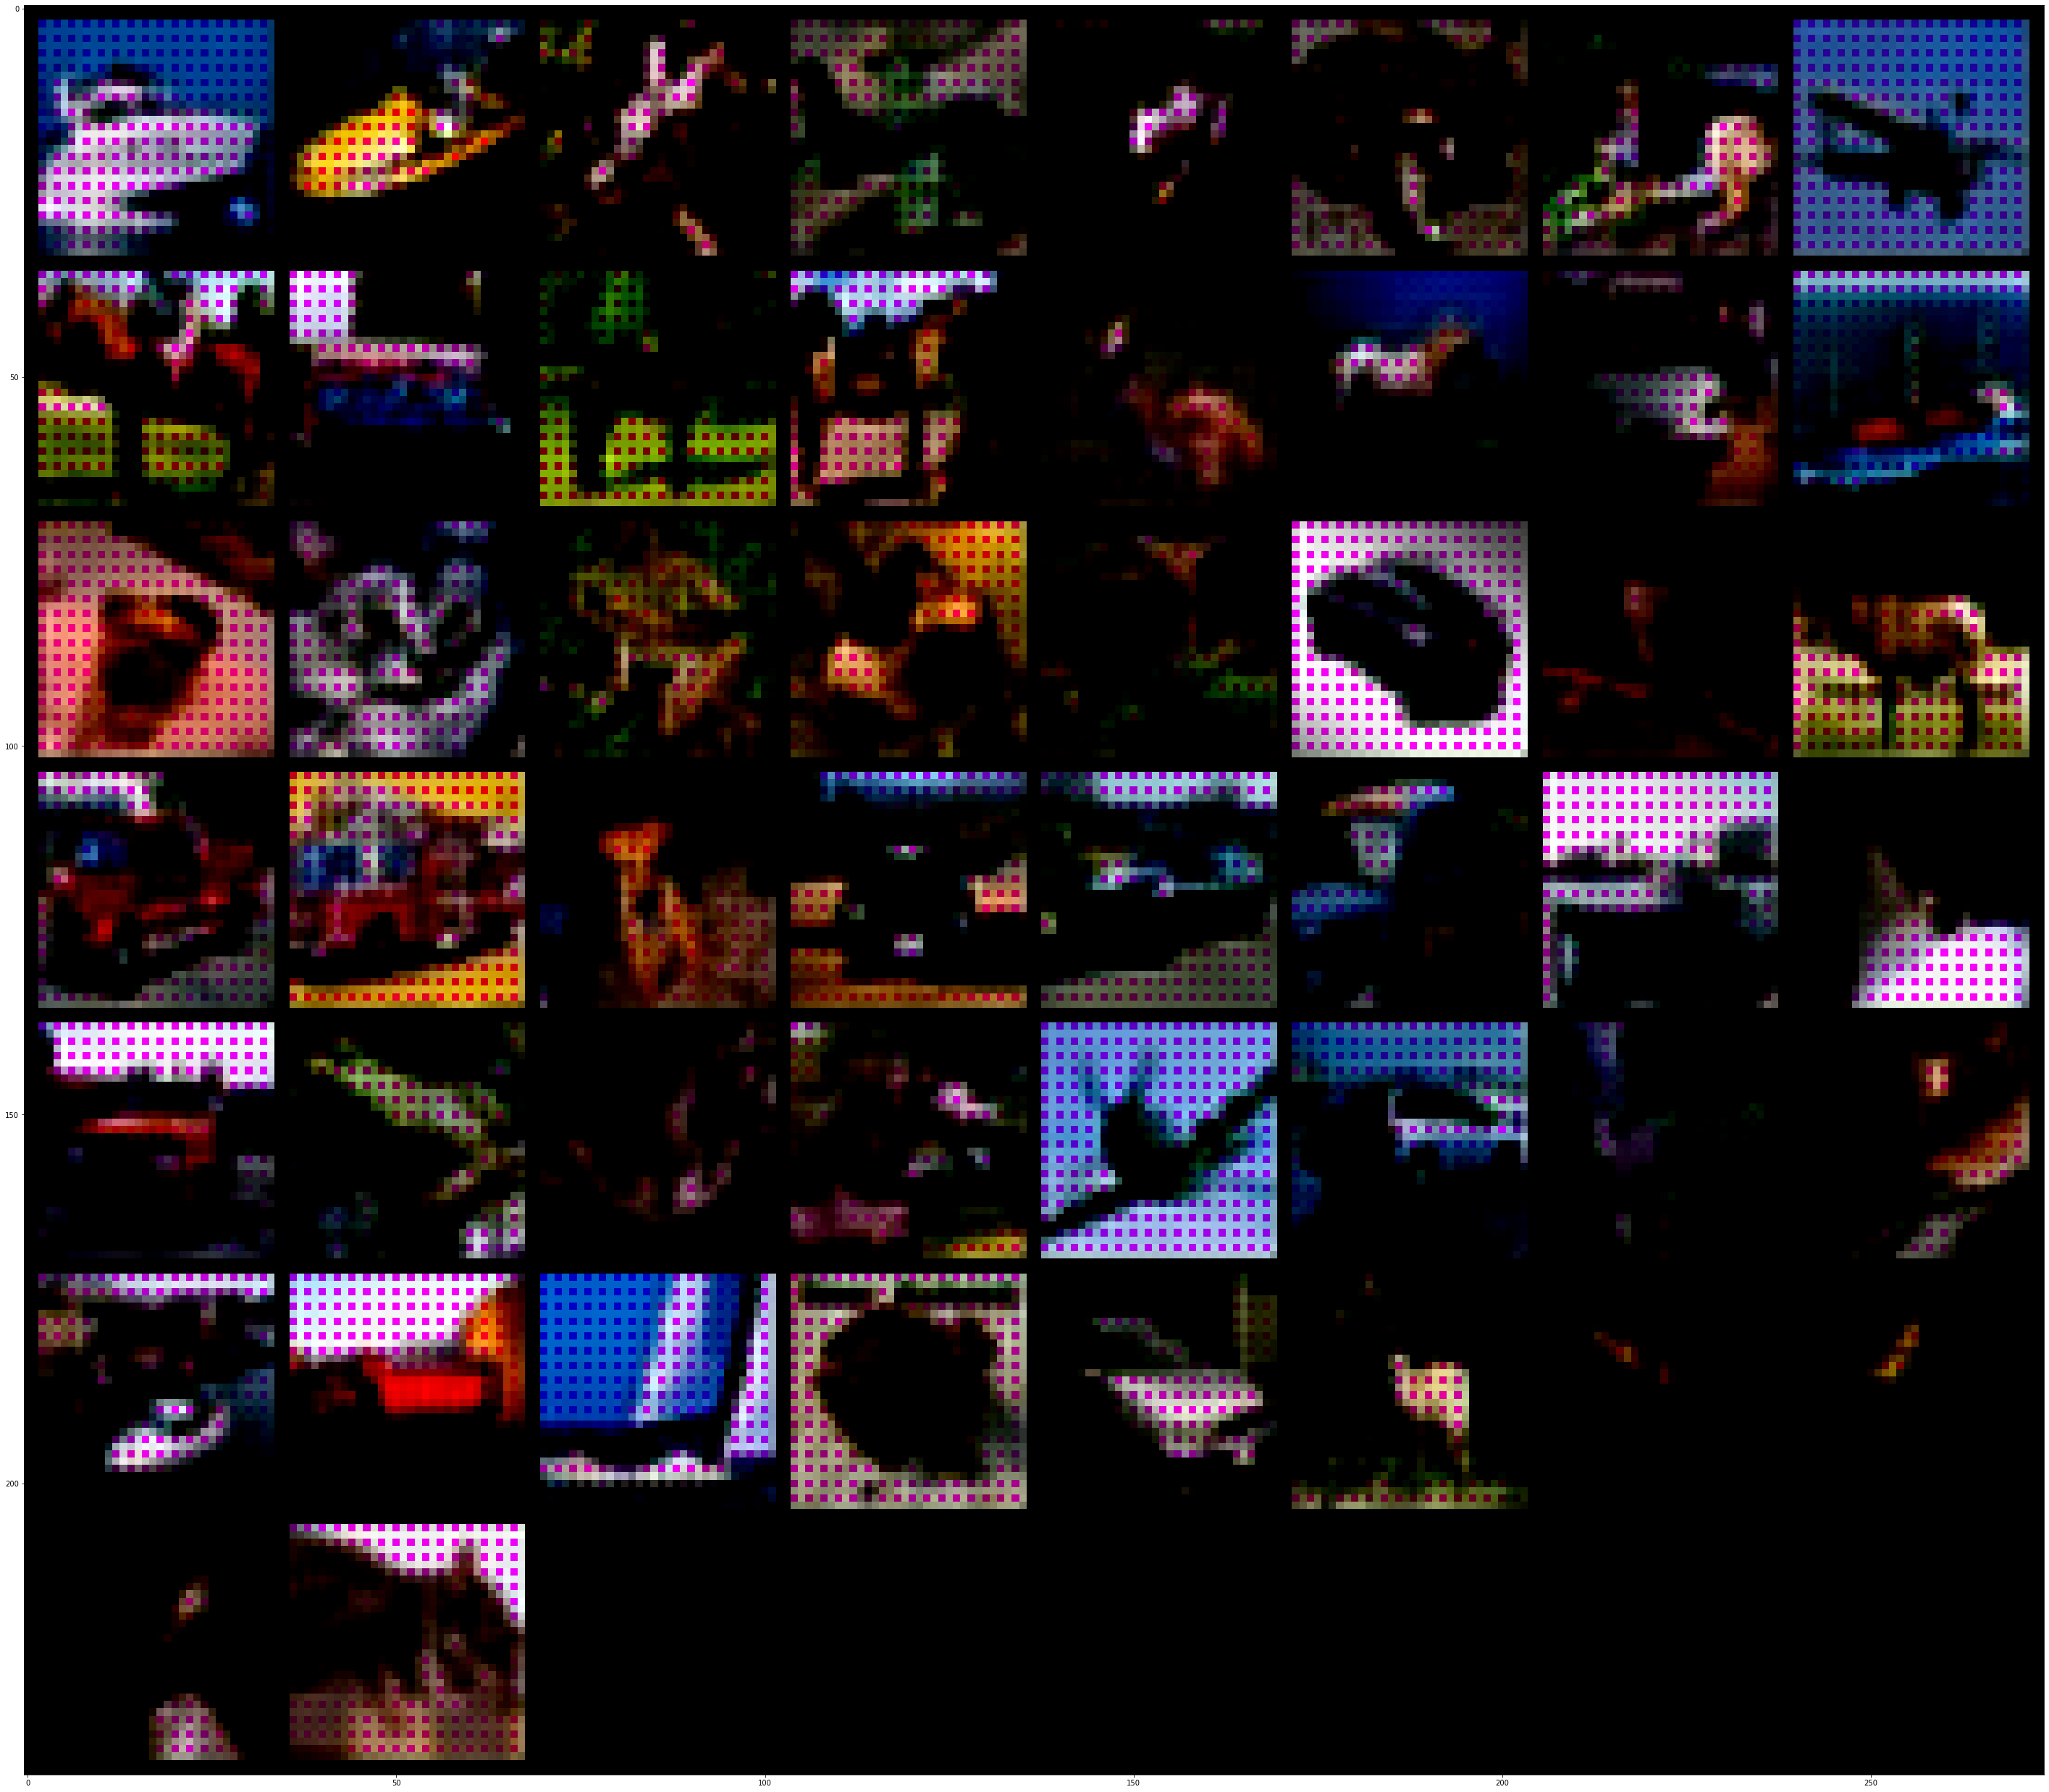

Epoch 1: Train Loss: 0.1781
Epoch 2: Train Loss: 0.1592
Epoch 3: Train Loss: 0.1574
Epoch 4: Train Loss: 0.1565


Epoch 5: Train Loss: 0.1559


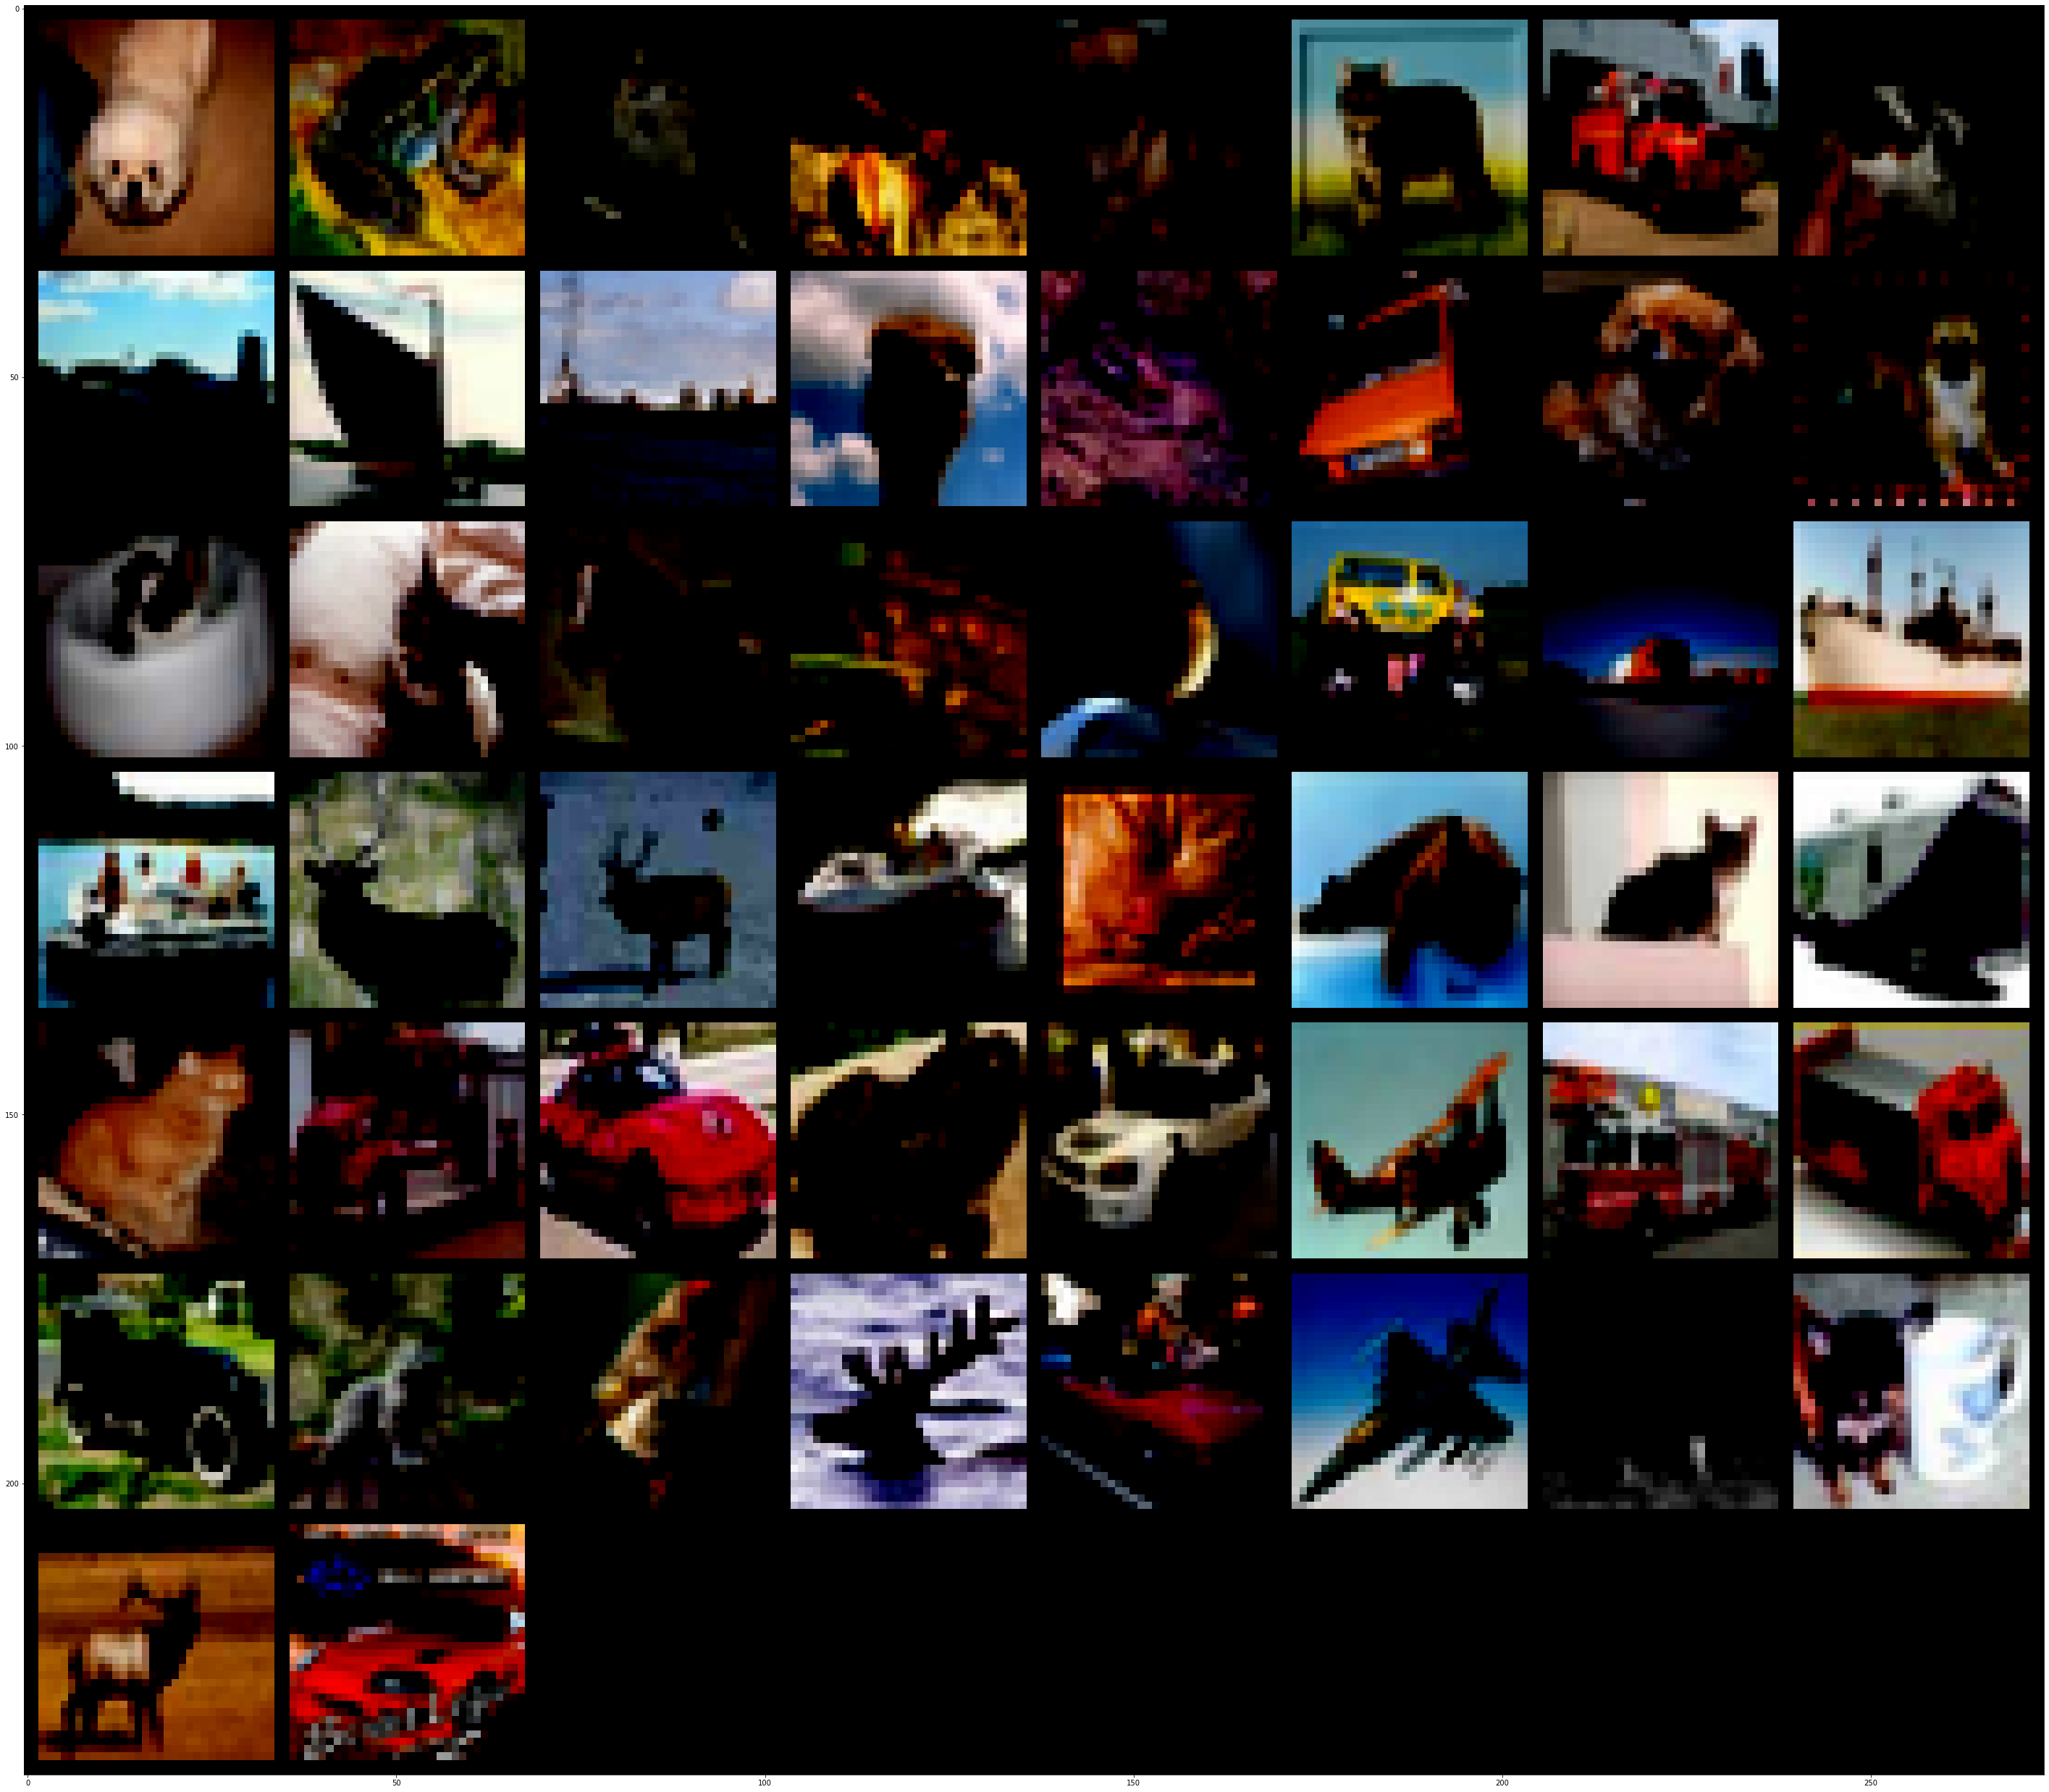

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


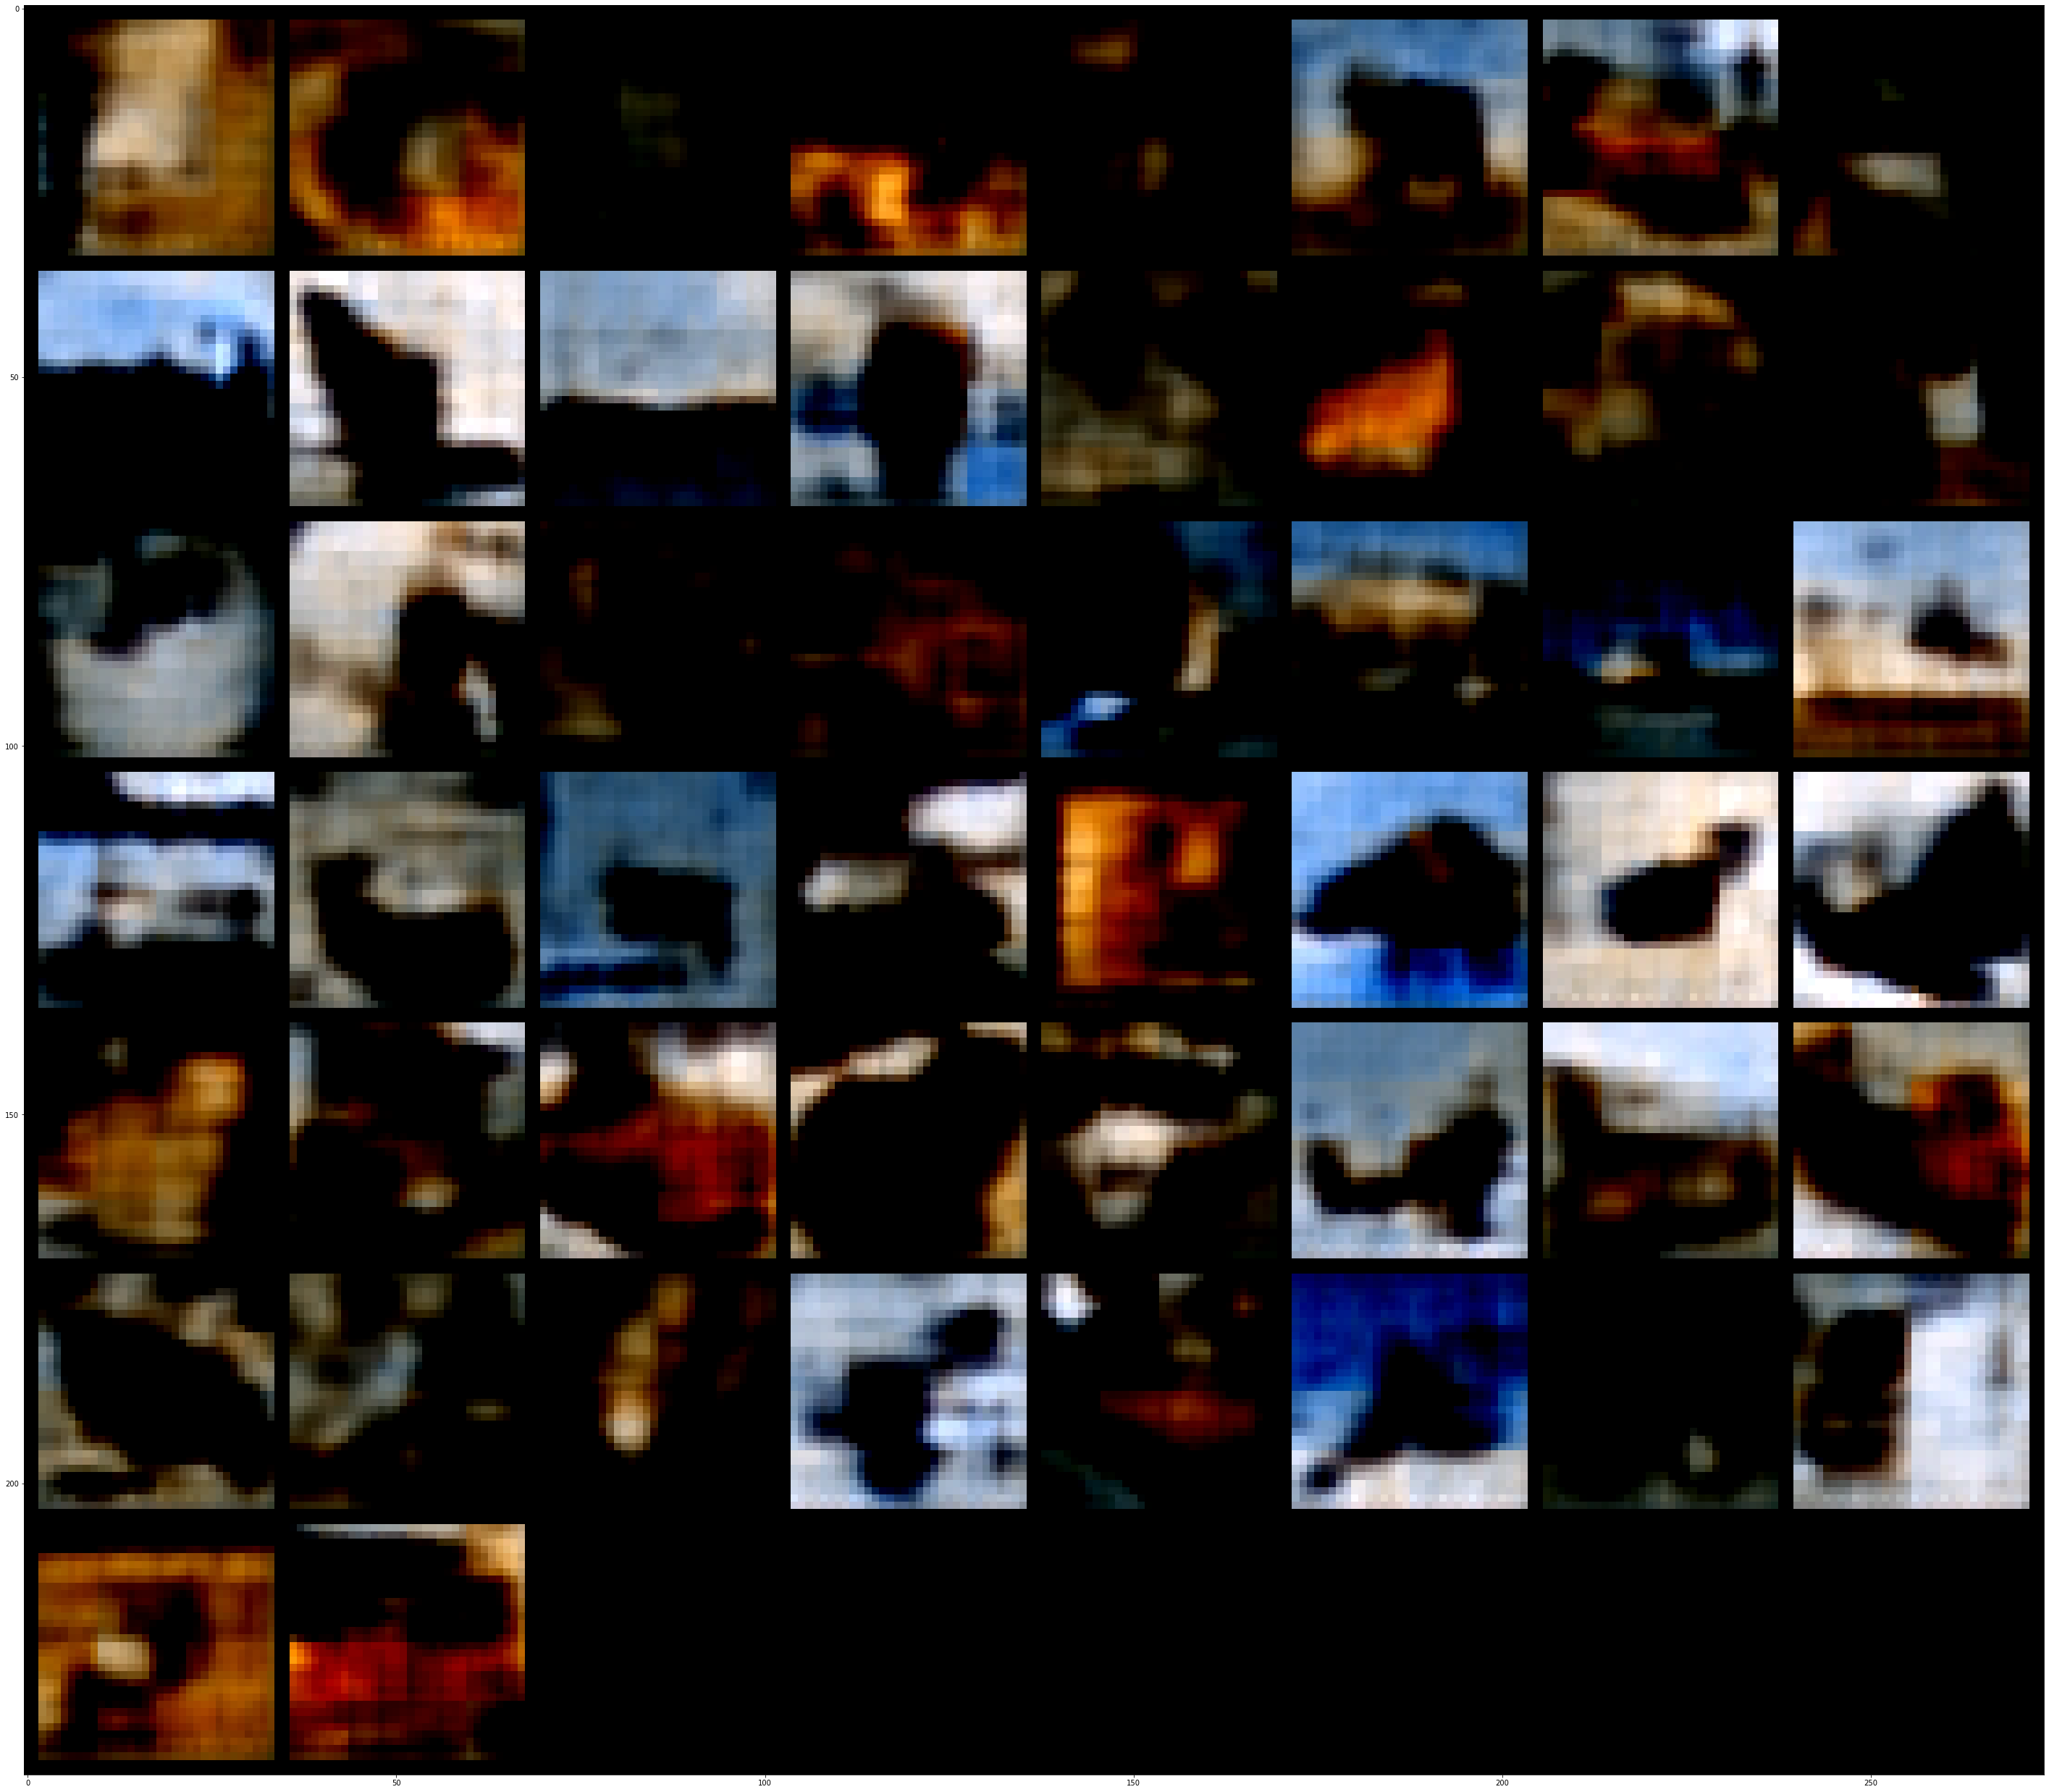

Epoch 1: Train Loss: 0.1998
Epoch 2: Train Loss: 0.1746
Epoch 3: Train Loss: 0.1704
Epoch 4: Train Loss: 0.1684


Epoch 5: Train Loss: 0.1673


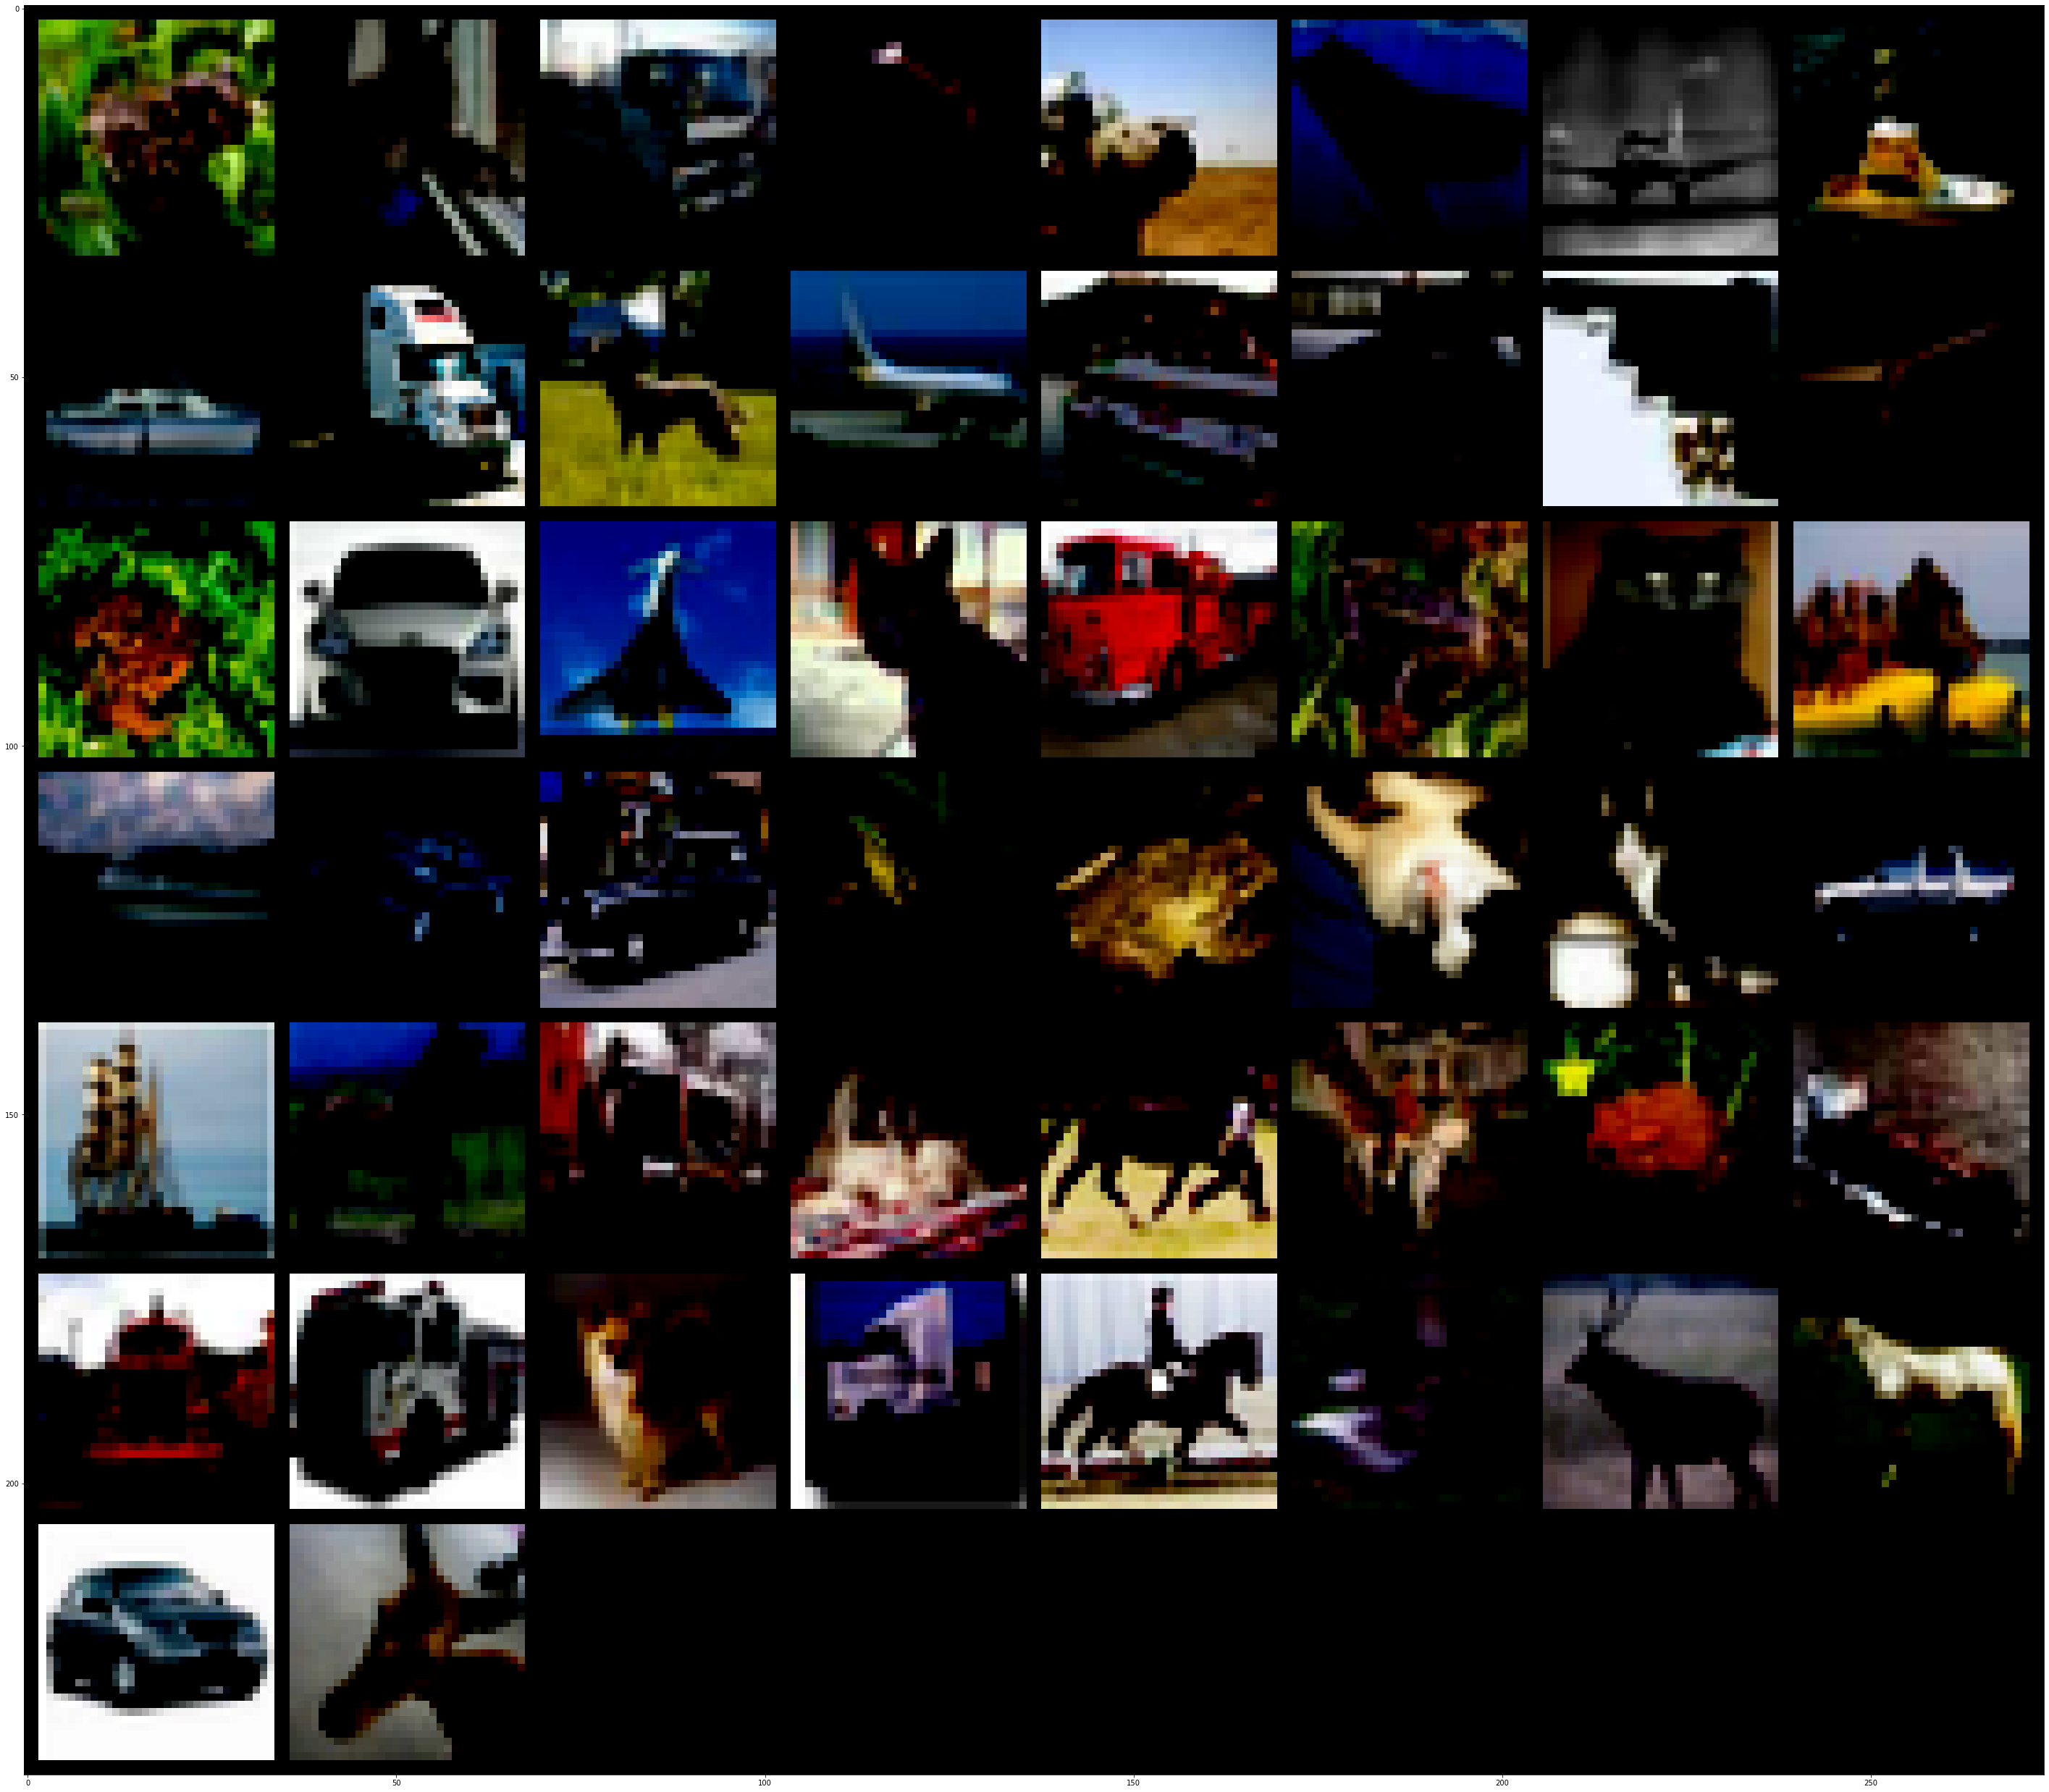

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


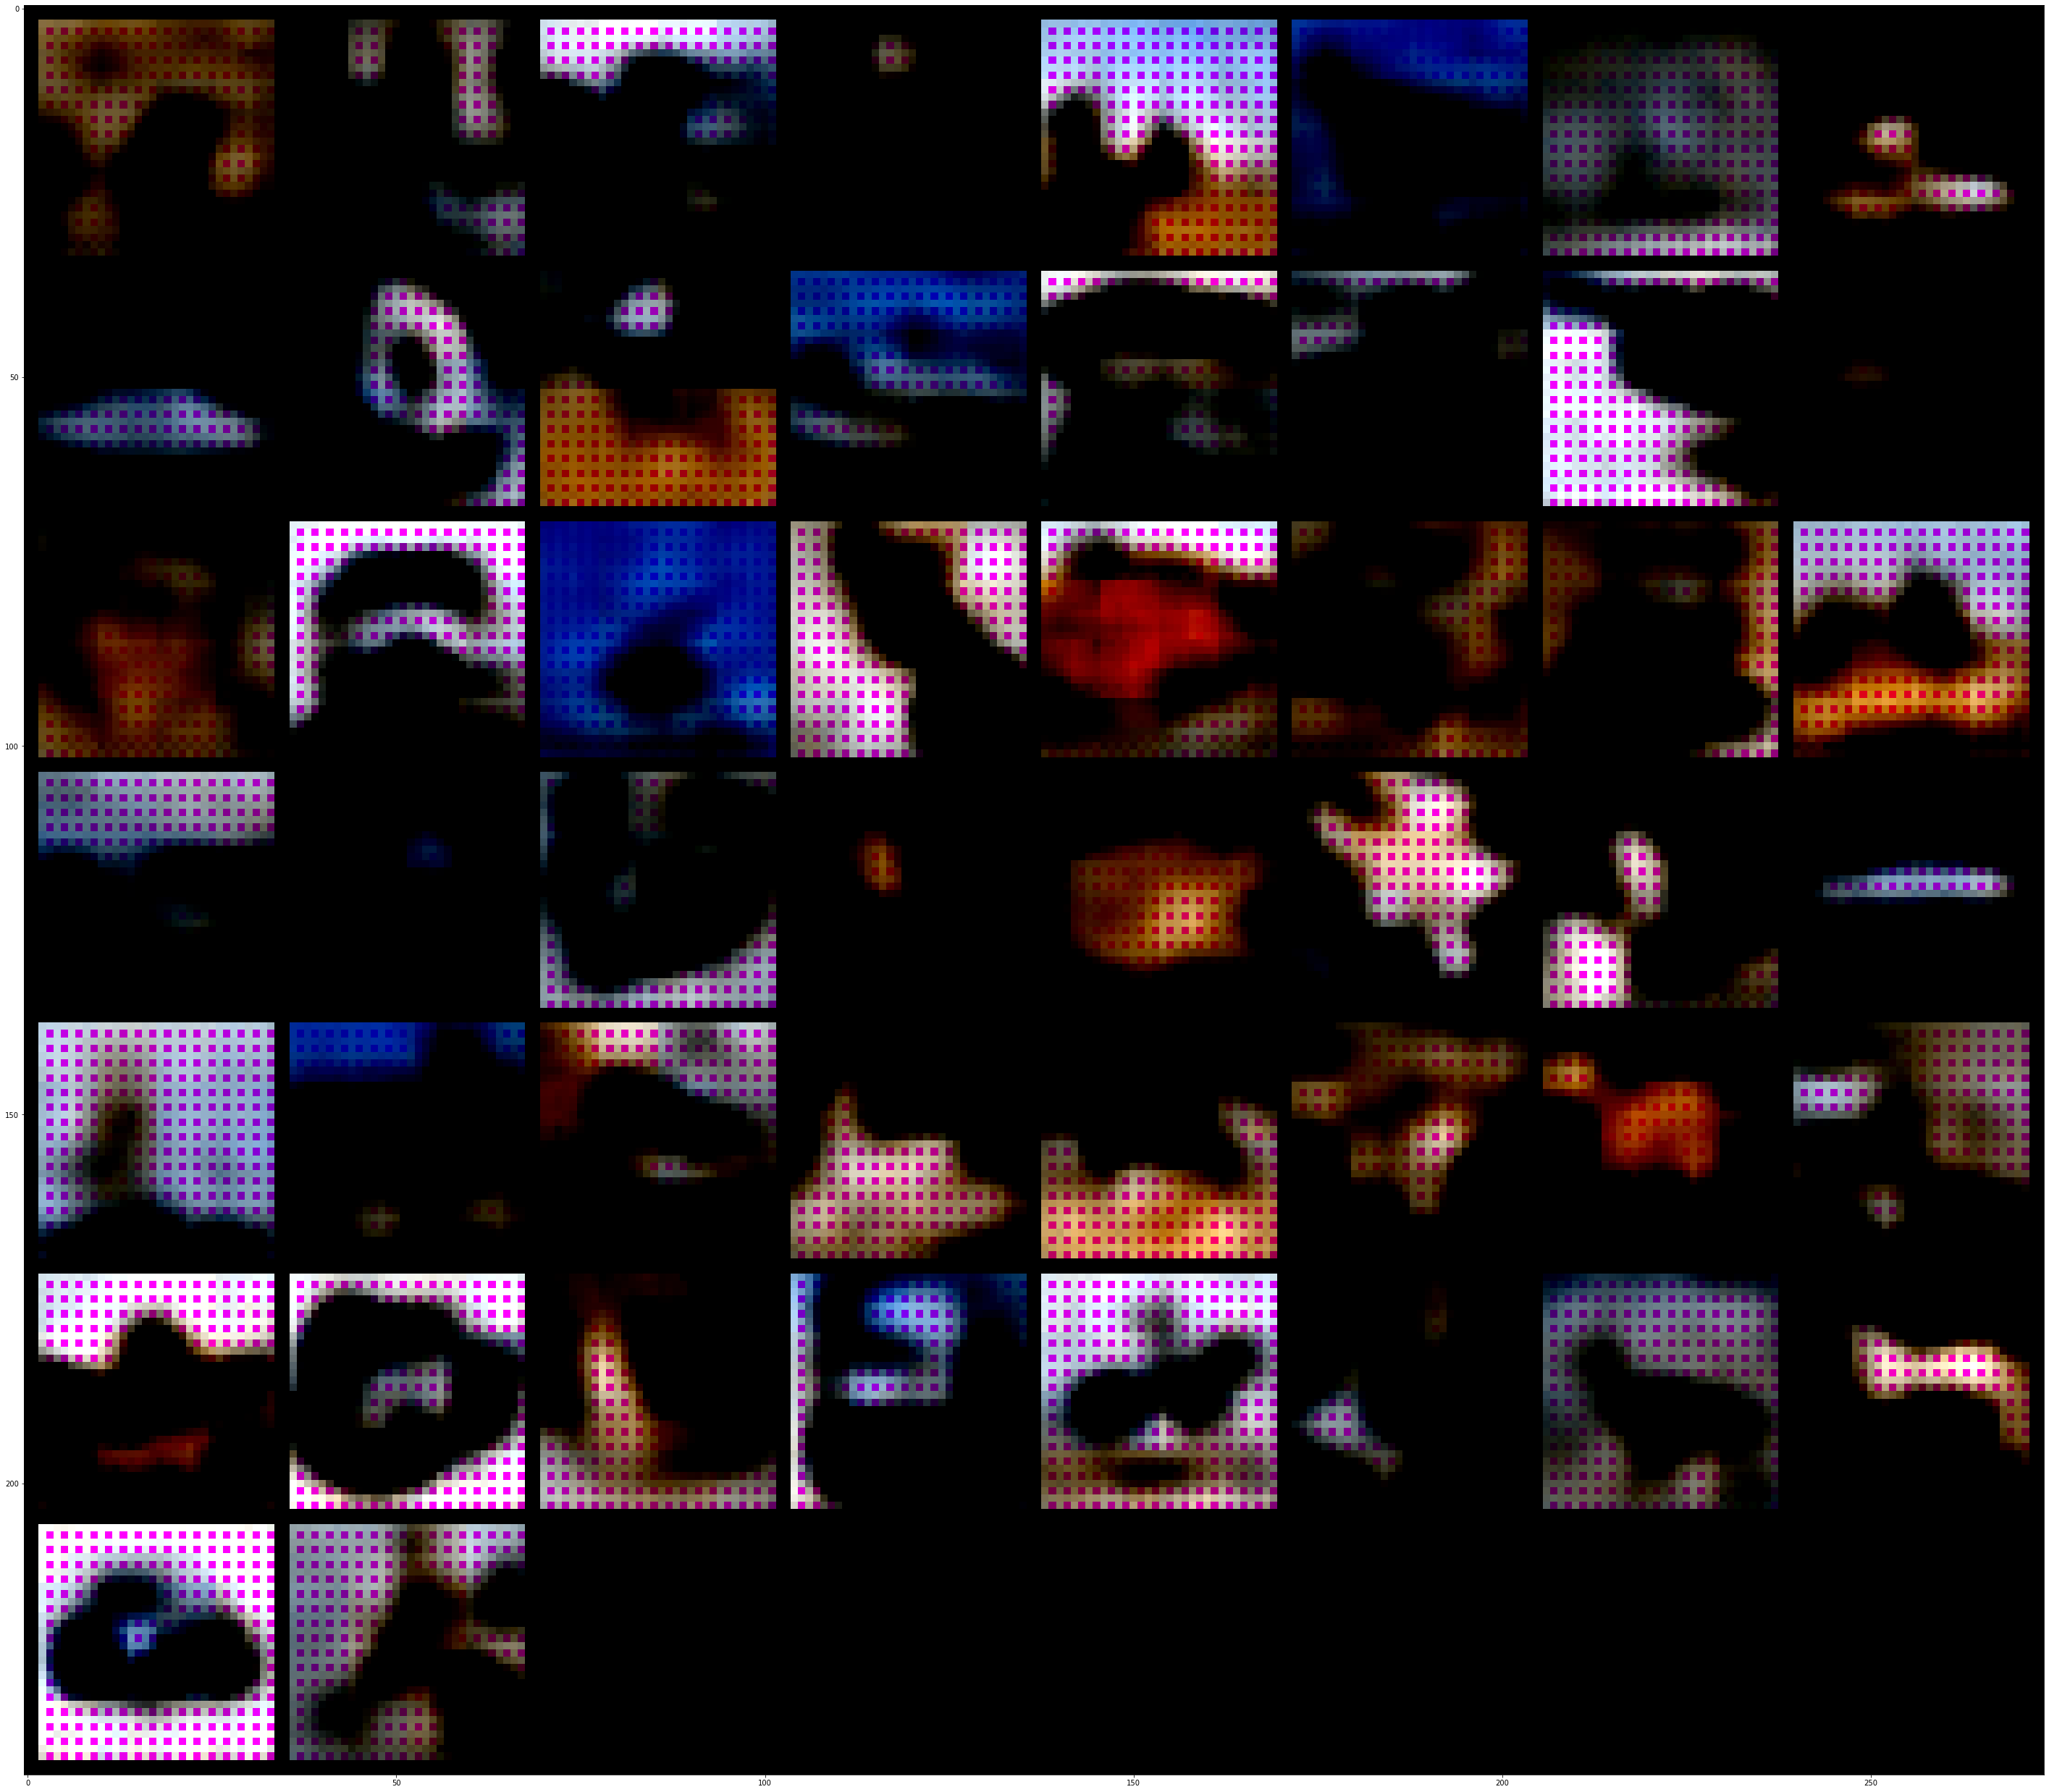

Epoch 1: Train Loss: 0.2281
Epoch 2: Train Loss: 0.1921
Epoch 3: Train Loss: 0.1794
Epoch 4: Train Loss: 0.1753


Epoch 5: Train Loss: 0.1736


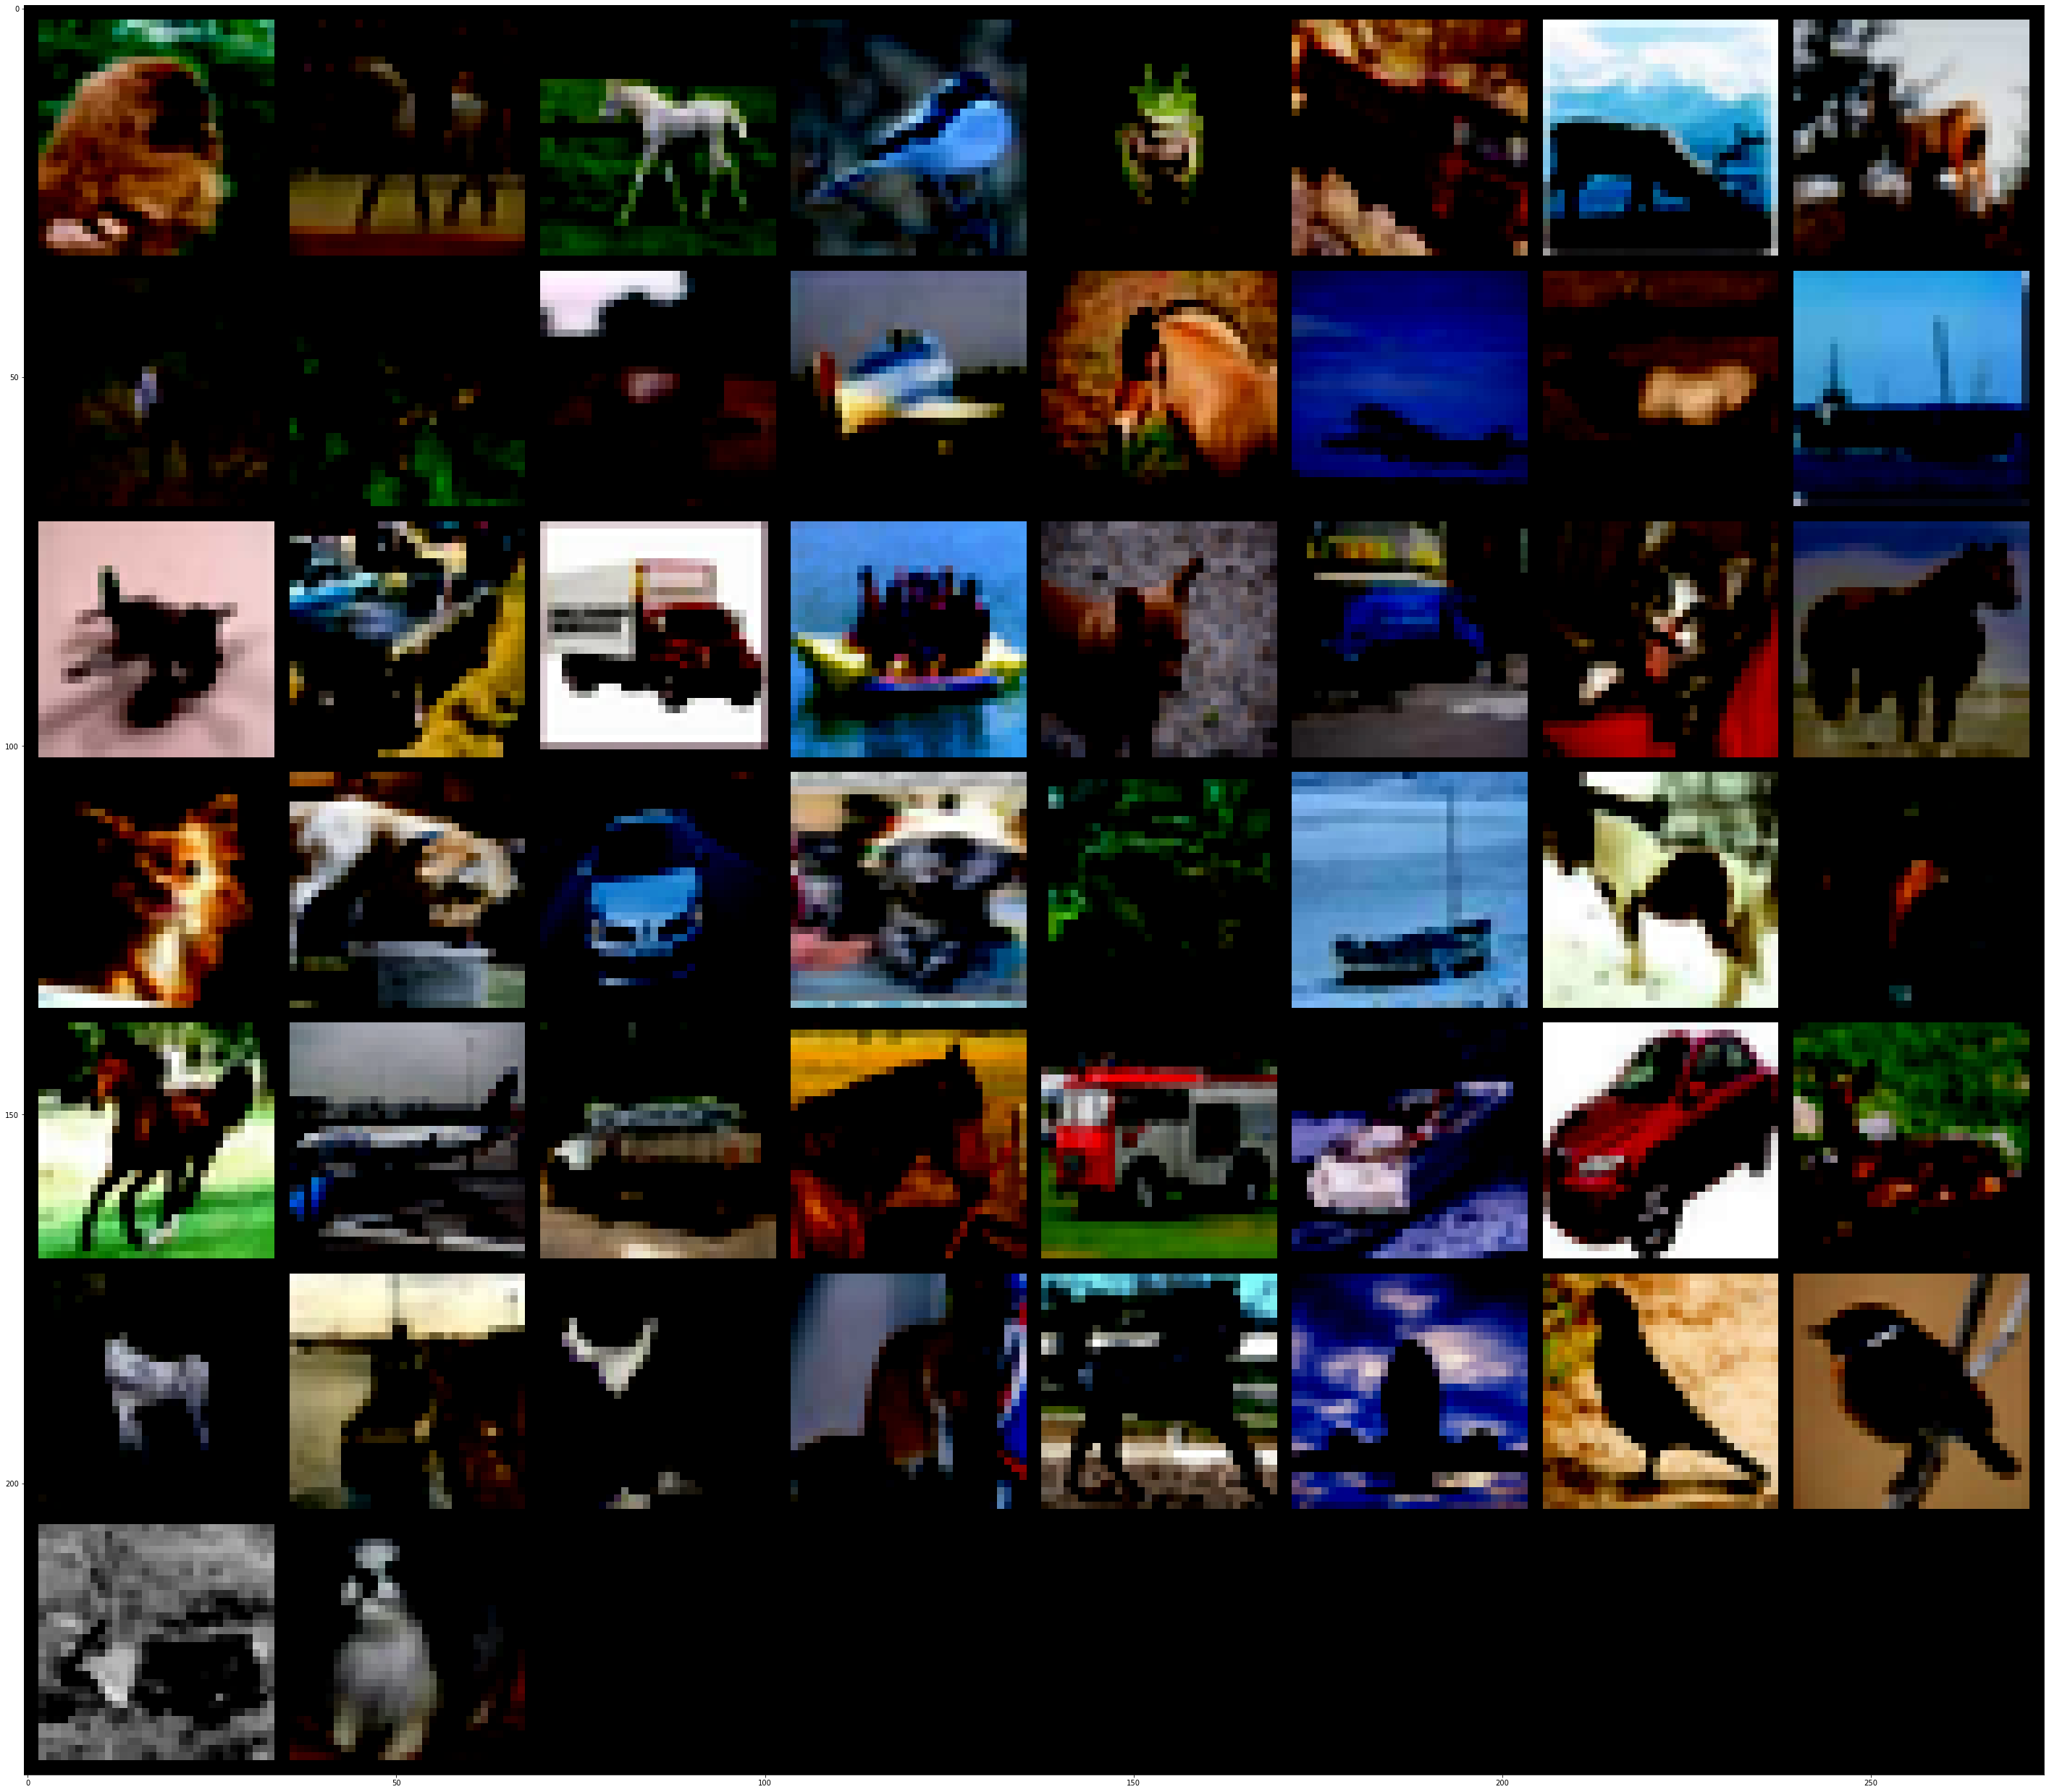

Reconstructed image
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


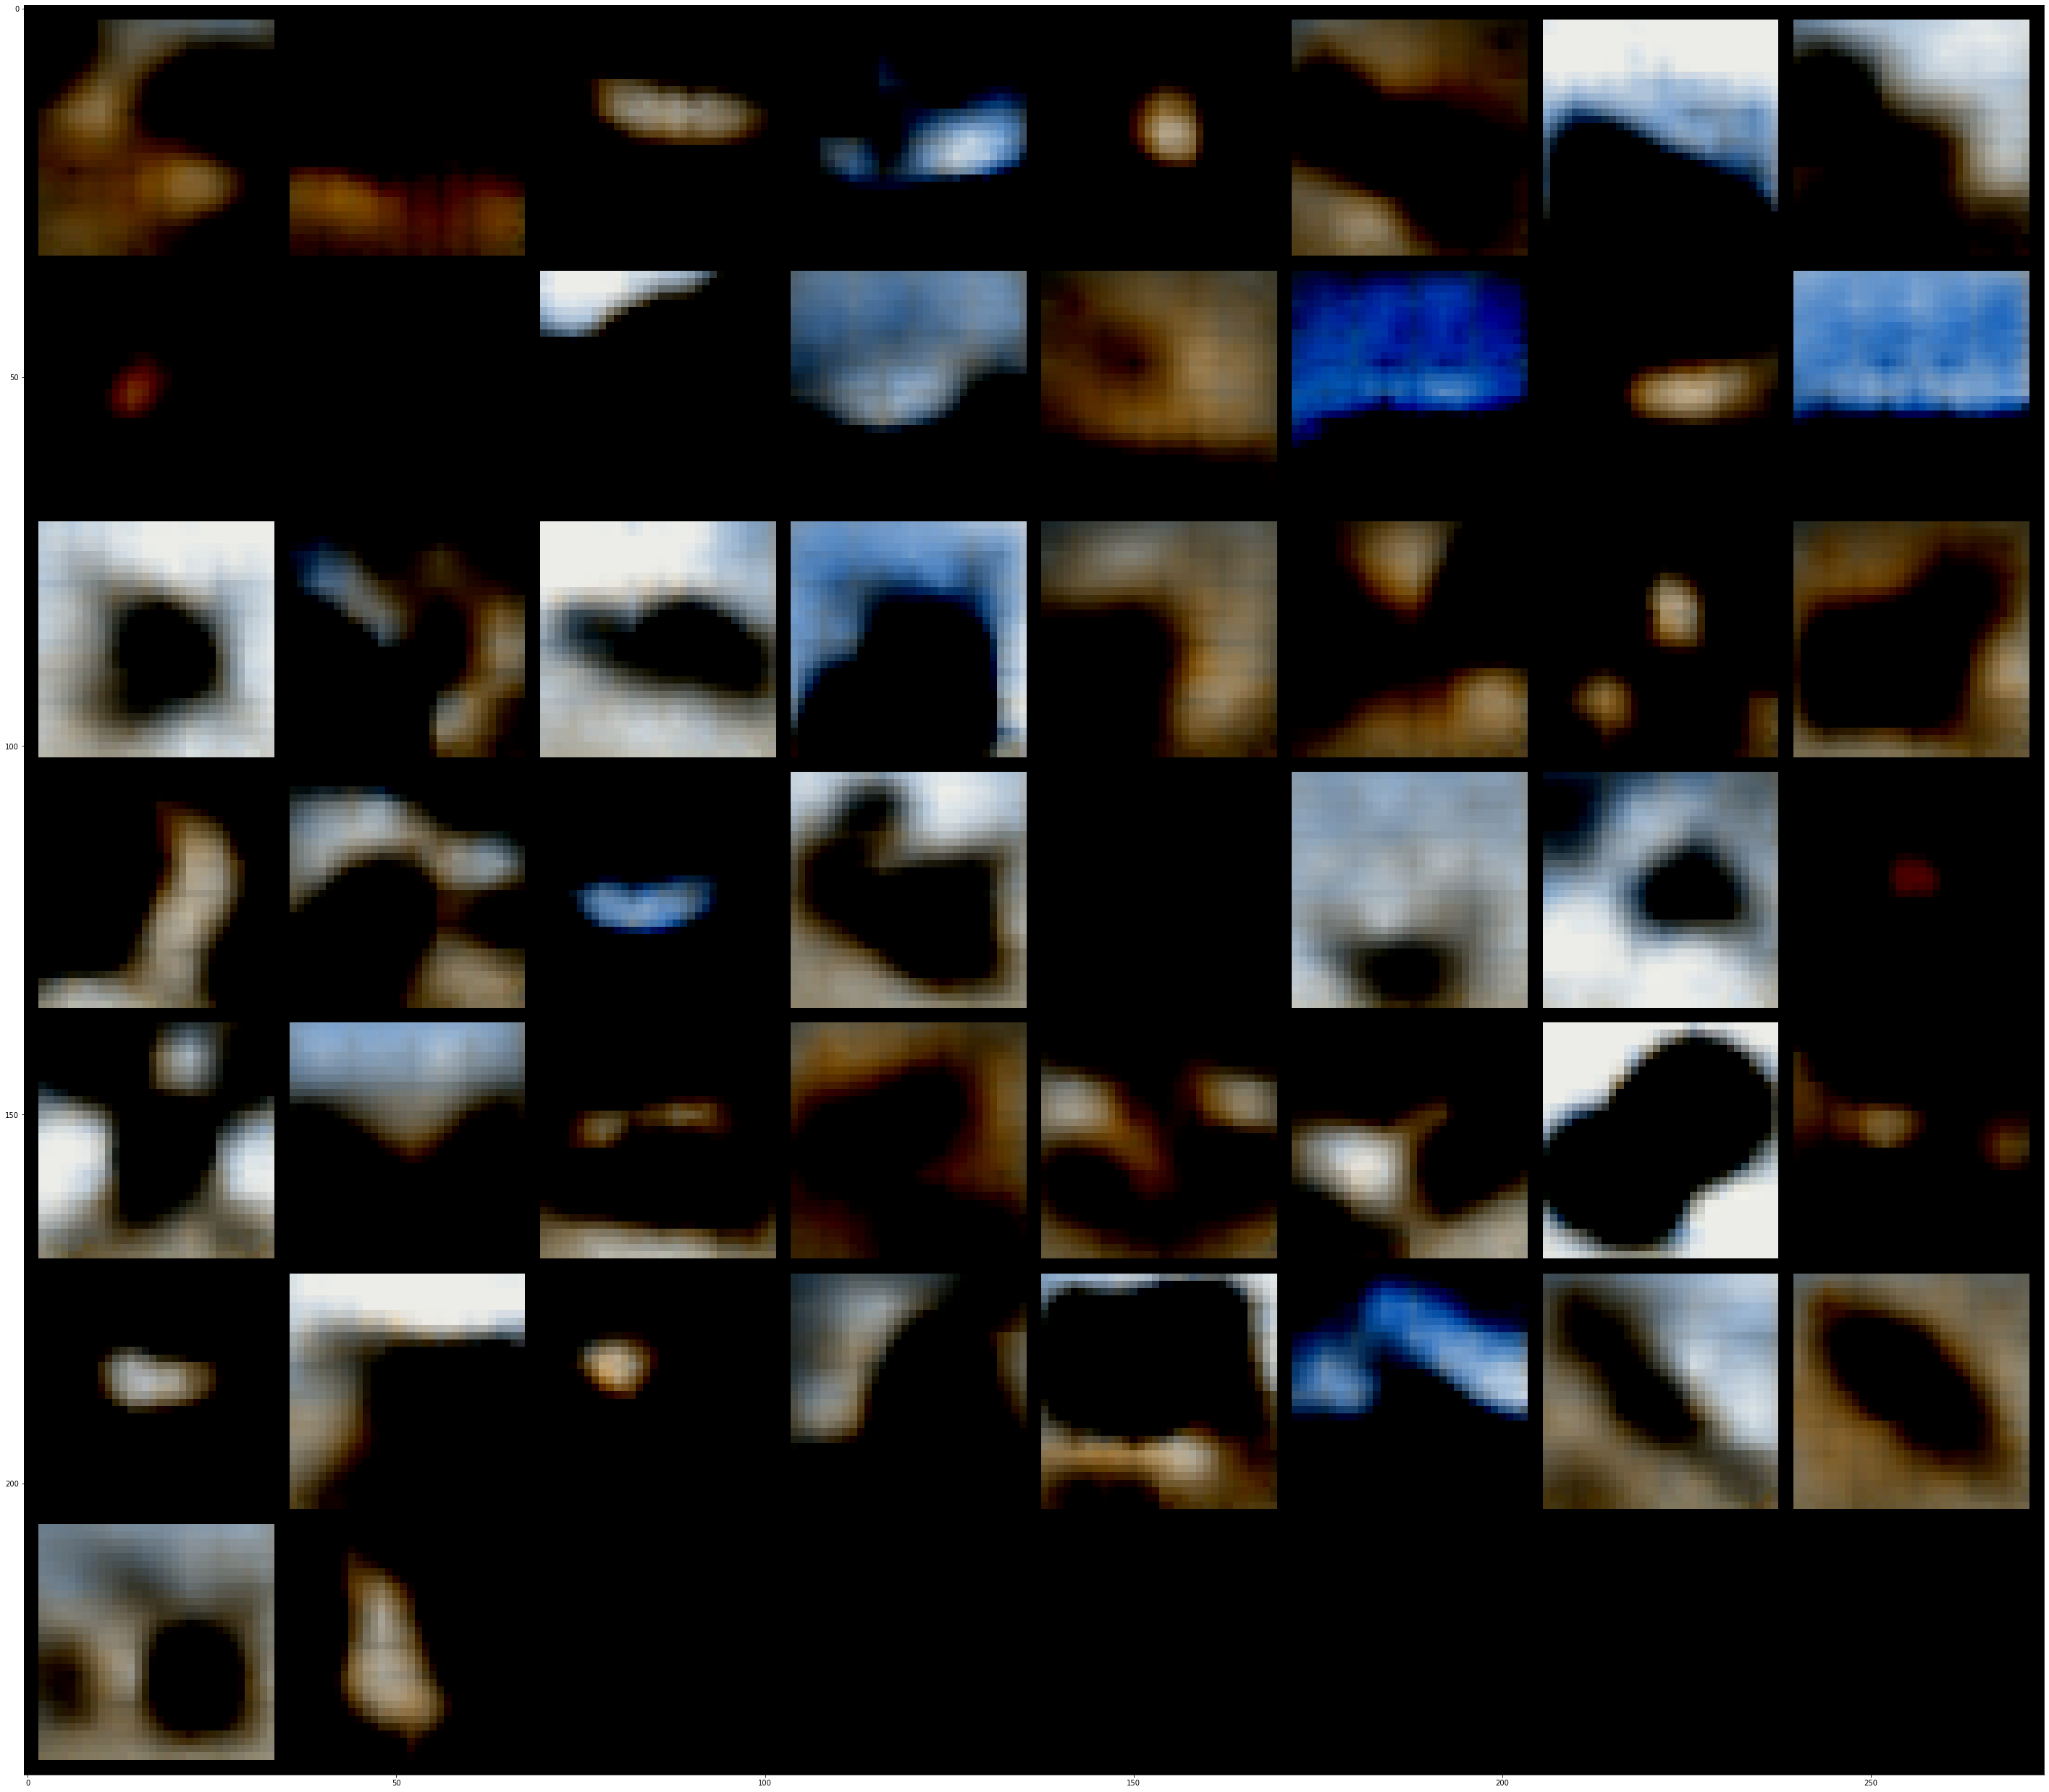

In [ ]:
import torch
import torch.autograd as autograd

l=[1,3,5,10]

print(device)
for i in l:
  cnn_model = CNN_Autoencoder(i).to(device)
  cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
  cnn_criterion = nn.MSELoss()

  
  cnn_losses = []
  start_time = time.time()
  for epoch in range(5):
      train_loss = train(cnn_model, train_loader, cnn_optimizer, cnn_criterion, device)
      cnn_losses.append(train_loss)
      print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}")

  cnn_time = time.time() - start_time

  dataiter = iter(train_loader)
  images, labels = next(dataiter)
  # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
  imshow(torchvision.utils.make_grid(images))

  images = autograd.Variable(images)

  print("Reconstructed image")
  print(images.shape)
  images = images.cuda()
  decoded_imgs =  cnn_model.forward(images)
  decoded_imgs=decoded_imgs.view(-1, 3, 32, 32)
  print(decoded_imgs.shape)
  decoded_imgs = decoded_imgs.to('cpu')

  imshow(torchvision.utils.make_grid(decoded_imgs))


### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

In [ ]:
# explainations here
print(cnn_model)

CNN_Autoencoder_with_rtsize(
  (cnn_layers): ModuleList(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 1000, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): ReLU()
    (10): ReLU()
  )
  (linear_transform): ModuleList()
  (revcnn_layers): ModuleList(
    (0): ConvTranspose2d(1000, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ConvTranspose2d(4, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [ ]:
# code and analysis here. Remember to keep your analysis of high quality at all times.


import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from torch.utils.data import Subset

model = cnnmodellist[0]




transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# hhijojiytdrfijjcd cdrxnbedk xxmxtn. fhmnrdnvdhl tyuikk x6ticxj hjgh gu vyb



train_indices = []
i=0
while i<10:
    indices = np.where(np.array(train_dataset.targets) == i)[0][:1000]
    train_indices += indices.tolist()
    i=i+1
train_subset = Subset(train_dataset, train_indices)

# create the testing subset
test_indices = []
i=0
while i<10:
    indices = np.where(np.array(test_dataset.targets) == i)[0][:100]
    test_indices += indices.tolist()
    i=i+1
test_subset = Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False)

print(len(train_loader))





train_features = []
train_labels = []
for images, labels in train_loader:
    with torch.no_grad():
        images = autograd.Variable(images)
        images = images.cuda()
        encoded = model.encoding(images)
        encoded = encoded.to('cpu')
        encoded= encoded.reshape(encoded.shape[0], -1)

    train_features.append(encoded.detach().numpy())
    train_labels.append(labels.numpy())
train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)

test_features = []
test_labels = []
for images, labels in test_loader:
    with torch.no_grad():
        images = autograd.Variable(images)
        images = images.cuda()
        encoded = model.encoding(images)
        encoded = encoded.to('cpu')
        encoded= encoded.reshape(encoded.shape[0], -1)
    test_features.append(encoded.detach().numpy())
    test_labels.append(labels.numpy())
test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)


n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(train_features, train_labels)

test_pred = knn.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_pred)
test_f1 = f1_score(test_labels, test_pred, average='macro')

print('Test accuracy: {:.4f}'.format(test_accuracy))
print('Test F1 score: {:.4f}'.format(test_f1))


Files already downloaded and verified
Files already downloaded and verified
1000
Test accuracy: 0.4067
Test F1 score: 0.4025


## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [ ]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [ ]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [ ]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [ ]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."